In [2]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

tf.compat.v1.random.set_random_seed(42)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from math import floor

from utils import concordance_index_censored_scorer,concordance_index_ipcw_scorer,integrated_brier_scorer,cumulative_dynamic_auc_scorer
from utils import log_rank_test,log_rank_test_scorer
from utils import reduce_T_max,reduce_uncensored

from sklearn.model_selection import KFold

import json
import os

from sksurv.nonparametric import kaplan_meier_estimator

from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize,LogNorm
from matplotlib.cm import ScalarMappable

In [3]:
NAME = "support2"
NAME_PLOT = "SUPPORT2"

plt.rcParams.update({'font.size': 20})

pd.set_option('display.max_columns', None)
df = df = pd.read_csv("Data/support2.csv", index_col="id")
drop_list = ["sps","aps","surv2m","surv6m","prg2m","prg6m","dnr","dnrday"] # These are predictions...
df = df.drop(drop_list,axis=1)

timeline_resolution = 200

T_maxs = [1.0,0.75,0.5,0.25]
red_rates = [1.0,0.75,0.5,0.25]

from itertools import product
sensitivity_grid = np.array(list(product(T_maxs,red_rates))) # [:,0] -> T_maxs, [:,1] -> red_rates

# Preprocessing

In [4]:
# Fix Income to be numeric (there's ordering between the categories!!)
income = []
for value in df.income:
    if value == "under $11k":
        income.append(0.)
    elif value == "$11-$25k":
        income.append(1.)
    elif value == "$25-$50k":
        income.append(2.)
    elif value == ">$50k":
        income.append(3.)
    else:
        income.append(np.NaN)
df.income = income
# fix sfdm2 to be numeric (there's ordering between the categories!!)
sfdm2 = []
for value in df.sfdm2:
    if value == "no(M2 and SIP pres)":
        sfdm2.append(0.)
    elif value == "adl>=4 (>=5 if sur)":
        sfdm2.append(1.)
    elif value == "SIP>=30":
        sfdm2.append(2.)
    elif value == "Coma or Intub":
        sfdm2.append(3.)
    elif value == "<2 mo. follow-up":
        sfdm2.append(4.)
    else:
        sfdm2.append(np.NaN)
df.sfdm2 = sfdm2
# fix normal values, whenever available:
normal_values = {"alb":3.5,
                 "pafi":333.3,
                 "bili":1.01,
                 "crea":1.01,
                 "bun":6.51,
                 "wblc":9,
                 "urine":2502}
df = df.fillna(normal_values)

In [5]:
df.head()

age  death     sex  hospdead  slos  d.time            dzgroup  \
id                                                                       
1   62.84998      0    male         0     5    2029        Lung Cancer   
2   60.33899      1  female         1     4       4          Cirrhosis   
3   52.74698      1  female         0    17      47          Cirrhosis   
4   42.38498      1  female         0     3     133        Lung Cancer   
5   79.88495      0  female         0    16    2029  ARF/MOSF w/Sepsis   

               dzclass  num.co   edu  income  scoma  charges  totcst  totmcst  \
id                                                                              
1               Cancer       0  11.0     1.0    0.0   9715.0     NaN      NaN   
2   COPD/CHF/Cirrhosis       2  12.0     1.0   44.0  34496.0     NaN      NaN   
3   COPD/CHF/Cirrhosis       2  12.0     0.0    0.0  41094.0     NaN      NaN   
4               Cancer       2  11.0     0.0    0.0   3075.0     NaN      NaN   
5             ARF/MOSF       1   NaN     NaN   26.0  50127.0     NaN      NaN   

      avtisst   race  hday  diabetes  dementia          ca  meanbp       wblc  \
id                                                                              
1    7.000000  other     1         0         0  metastatic    97.0   6.000000   
2   29.000000  white     3         0         0          no    43.0  17.097656   
3   13.000000  white     4         0         0          no    70.0   8.500000   
4    7.000000  white     1         0         0  metastatic    75.0   9.099609   
5   18.666656  white     3         0         0          no    59.0  13.500000   

      hrt  resp      temp       pafi       alb      bili      crea    sod  \
id                                                                          
1    69.0  22.0  36.00000  388.00000  1.799805  0.199982  1.199951  141.0   
2   112.0  34.0  34.59375   98.00000  3.500000  1.010000  5.500000  132.0   
3    88.0  28.0  37.39844  231.65625  3.500000  2.199707  2.000000  134.0   
4    88.0  32.0  35.00000  333.30000  3.500000  1.010000  0.799927  139.0   
5   112.0  20.0  37.89844  173.31250  3.500000  1.010000  0.799927  143.0   

          ph  glucose   bun   urine  adlp  adls  sfdm2  adlsc  
id                                                             
1   7.459961      NaN  6.51  2502.0   7.0   7.0    NaN    7.0  
2   7.250000      NaN  6.51  2502.0   NaN   1.0    4.0    1.0  
3   7.459961      NaN  6.51  2502.0   1.0   0.0    4.0    0.0  
4        NaN      NaN  6.51  2502.0   0.0   0.0    0.0    0.0  
5   7.509766      NaN  6.51  2502.0   NaN   2.0    0.0    2.0

In [6]:
df_original = df.copy()

In [7]:
from sklearn.preprocessing import MinMaxScaler
time_scaler = MinMaxScaler()
df["d.time"]= time_scaler.fit_transform(df["d.time"].to_numpy().reshape(-1, 1))
t = np.float32(df["d.time"].to_numpy())
delta = df["death"].to_numpy().astype(np.float32)

In [8]:
from preprocessing import Preprocessor
cat_feats = ["sex","hospdead","dzgroup","dzclass",
             "race","diabetes","dementia","ca"]
num_feats = ["age","slos","num.co","edu","income",
             "scoma","charges","avtisst","hday",
             "meanbp","wblc","hrt","resp","temp",
             "pafi","alb","bili","crea","sod",
             "bun","urine","sfdm2","adlsc"]

df = Preprocessor(cat_feat_strat="mode",
                  num_feat_strat="knn",
                  scaling_strategy="minmax").fit_transform(df,
                                                           cat_feats=cat_feats,
                                                           num_feats=num_feats)

In [9]:
df.head()

age      slos    num.co       edu    income  scoma   charges  \
id                                                                      
1   0.534663  0.005882  0.000000  0.354839  0.333333   0.00  0.005958   
2   0.504702  0.002941  0.222222  0.387097  0.333333   0.44  0.023236   
3   0.414111  0.041176  0.222222  0.387097  0.000000   0.00  0.027837   
4   0.290468  0.000000  0.222222  0.354839  0.000000   0.00  0.001329   
5   0.737930  0.038235  0.111111  0.341935  0.066667   0.26  0.034135   

     avtisst      hday    meanbp      wblc       hrt      resp      temp  \
id                                                                         
1   0.073171  0.000000  0.497436  0.030000  0.230000  0.244444  0.430246   
2   0.341463  0.013605  0.220513  0.085488  0.373333  0.377778  0.289566   
3   0.146341  0.020408  0.358974  0.042500  0.293333  0.311111  0.570145   
4   0.073171  0.000000  0.384615  0.045498  0.293333  0.355556  0.330207   
5   0.215447  0.013605  0.302564  0.067500  0.373333  0.222222  0.620164   

        pafi       alb      bili      crea       sod       bun  urine  sfdm2  \
id                                                                             
1   0.428063  0.048945  0.001590  0.051400  0.436620  0.018428  0.278   0.45   
2   0.097908  0.108393  0.014468  0.252337  0.309859  0.018428  0.278   1.00   
3   0.250071  0.108393  0.033382  0.088785  0.338028  0.018428  0.278   1.00   
4   0.365789  0.108393  0.014468  0.032707  0.408451  0.018428  0.278   0.00   
5   0.183649  0.108393  0.014468  0.032707  0.464789  0.018428  0.278   0.00   

       adlsc  sex_male  hospdead_1  dzgroup_CHF  dzgroup_COPD  \
id                                                              
1   0.989645         1           0            0             0   
2   0.141378         0           1            0             0   
3   0.000000         0           0            0             0   
4   0.000000         0           0            0             0   
5   0.282756         0           0            0             0   

    dzgroup_Cirrhosis  dzgroup_Colon Cancer  dzgroup_Coma  \
id                                                          
1                   0                     0             0   
2                   1                     0             0   
3                   1                     0             0   
4                   0                     0             0   
5                   0                     0             0   

    dzgroup_Lung Cancer  dzgroup_MOSF w/Malig  dzclass_COPD/CHF/Cirrhosis  \
id                                                                          
1                     1                     0                           0   
2                     0                     0                           1   
3                     0                     0                           1   
4                     1                     0                           0   
5                     0                     0                           0   

    dzclass_Cancer  dzclass_Coma  race_black  race_hispanic  race_other  \
id                                                                        
1                1             0           0              0           1   
2                0             0           0              0           0   
3                0             0           0              0           0   
4                1             0           0              0           0   
5                0             0           0              0           0   

    race_white  diabetes_1  dementia_1  ca_no  ca_yes  
id                                                     
1            0           0           0      0       0  
2            1           0           0      1       0  
3            1           0           0      1       0  
4            1           0           0      0       0  
5            1           0           0      1       0

In [10]:
# Divide the data
X = df.copy()
x_size = len(X.columns)
X = np.float32(X.to_numpy())
y = np.stack([t,delta],axis = 1)

In [11]:
# Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min < y_test[:,0]) & (y_test[:,0] < t_max)
X_test = X_test[mask]
y_test = y_test[mask]

# Create a timeline for evaluation
t_max = min([t_max,max(y_test[:,0])])
t_min = max([t_min,min(y_test[:,0])])
timeline = np.linspace(t_min,t_max,timeline_resolution,endpoint=False).astype(np.float32)

# Exploration

In [41]:
# Dataset statistics

properties = {"Dataset": NAME_PLOT,
              "Num. of Patients": len(df_original),
              "Num. of Features": len(df_original.columns),
              "Num. of Numeric Features": len(num_feats),
              "Num. of Categorical Features": len(df_original.columns)-len(num_feats),
              "Mean Survival": round(np.mean(df_original["d.time"]),2),
              "Min. Survival": round(min(df_original["d.time"]),2),
              "Max. Survival": round(max(df_original["d.time"]),2),
              "Num. of Censored": len(df_original[df_original["death"] == 0]),
              "Censored %": round(len(df_original[df_original["death"] == 0])/len(df_original)*100,2),
              "Censored Mean Survival": round(np.mean(df_original["d.time"][df_original["death"] == 0]),2),
              "Censored Min. Survival": round(min(df_original["d.time"][df_original["death"] == 0]),2),
              "Censored Max. Survival": round(max(df_original["d.time"][df_original["death"] == 0]),2),
              "Num. of Uncensored": len(df_original[df_original["death"] == 1]),
              "Uncensored %": round(len(df_original[df_original["death"] == 1])/len(df_original)*100,2),
              "Uncensored Mean Survival": round(np.mean(df_original["d.time"][df_original["death"] == 1]),2),
              "Uncensored Min. Survival": round(min(df_original["d.time"][df_original["death"] == 1]),2),
              "Uncensored Max. Survival": round(max(df_original["d.time"][df_original["death"] == 1]),2)}

_ = [print(key,':',value) for key, value in properties.items()]

Dataset : SUPPORT2
Num. of Patients : 9105
Num. of Features : 39
Num. of Numeric Features : 23
Num. of Categorical Features : 16
Mean Survival : 478.45
Min. Survival : 3
Max. Survival : 2029
Num. of Censored : 2904
Censored % : 31.89
Censored Mean Survival : 1060.22
Censored Min. Survival : 344
Censored Max. Survival : 2029
Num. of Uncensored : 6201
Uncensored % : 68.11
Uncensored Mean Survival : 206.0
Uncensored Min. Survival : 3
Uncensored Max. Survival : 1944


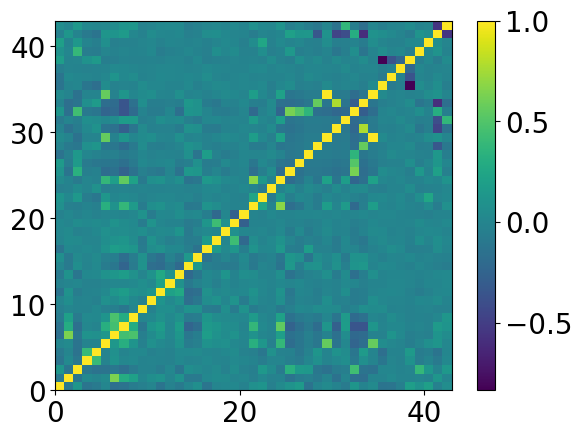

In [42]:
plt.pcolor(df.corr())
plt.colorbar()

In [43]:
from lifelines.fitters.coxph_fitter import CoxPHFitter
cox_test_df = pd.DataFrame(np.append(np.vstack([y_train,y_test]),np.hstack([np.zeros(len(y_train)).T,np.ones(len(y_test))]).reshape(-1,1),axis=1))

cph = CoxPHFitter()
cph.fit(df = cox_test_df,
        duration_col = 0,
        event_col = 1)

print(cph.summary)

#cph.check_assumptions(cox_test_df,
#                      show_plots=True,
#                      p_value_threshold=0.7)

print(cph.log_likelihood_ratio_test())

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2         -0.059012   0.942696  0.028036       -0.113962       -0.004061   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.892292             0.995947     0.0 -2.104825   

                  p  -log2(p)  
covariate                      
2          0.035307  4.823919  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           4.47 0.03      4.85


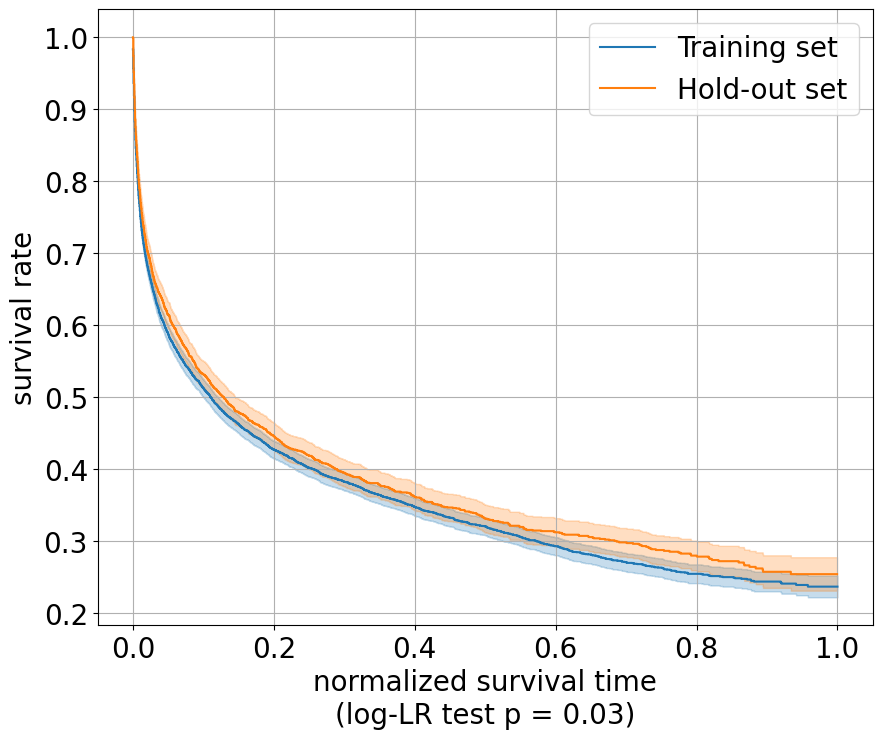

In [44]:
from lifelines.fitters.kaplan_meier_fitter import KaplanMeierFitter

plt.figure(figsize=(10,8))

kmf1 = KaplanMeierFitter(label="Training set")
kmf1.fit(y_train[:,0], y_train[:,1])
kmf1.plot()

kmf2 = KaplanMeierFitter(label="Hold-out set")
kmf2.fit(y_test[:,0], y_test[:,1])
kmf2.plot()

#plt.title("KM estimator of the training and hold-out sets")
plt.xlabel(f"normalized survival time\n(log-LR test p = {round(cph.log_likelihood_ratio_test().p_value,2)})")
plt.ylabel("survival rate")
plt.grid()
plt.show()

## Testing the 5Fold Cross Validation Data

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.014486   1.014592  0.037685       -0.059376        0.088348   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to       z         p  \
covariate                                                                       
2                     0.942353             1.092368     0.0  0.3844  0.700682   

           -log2(p)  
covariate            
2          0.513168  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.15 0.70      0.51


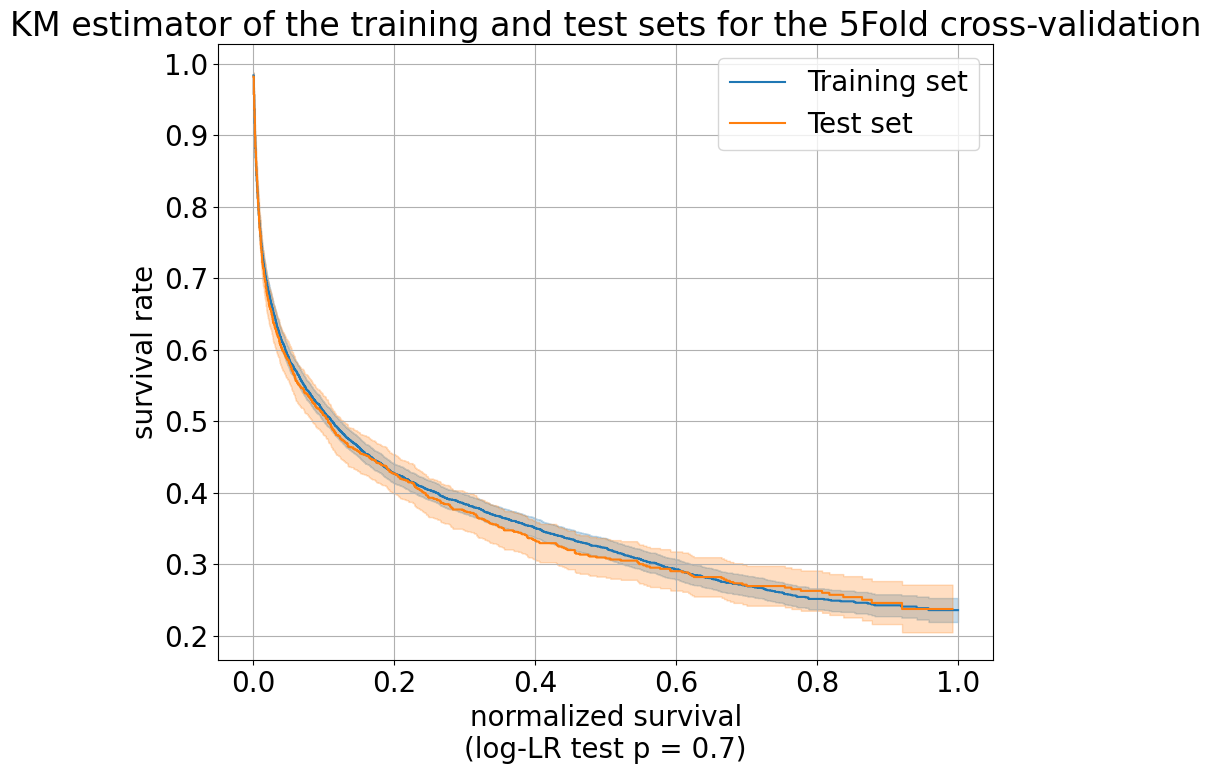

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.001375   1.001376  0.037994       -0.073092        0.075843   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.929515             1.078793     0.0  0.036198   

                  p  -log2(p)  
covariate                      
2          0.971125  0.042272  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.00 0.97      0.04


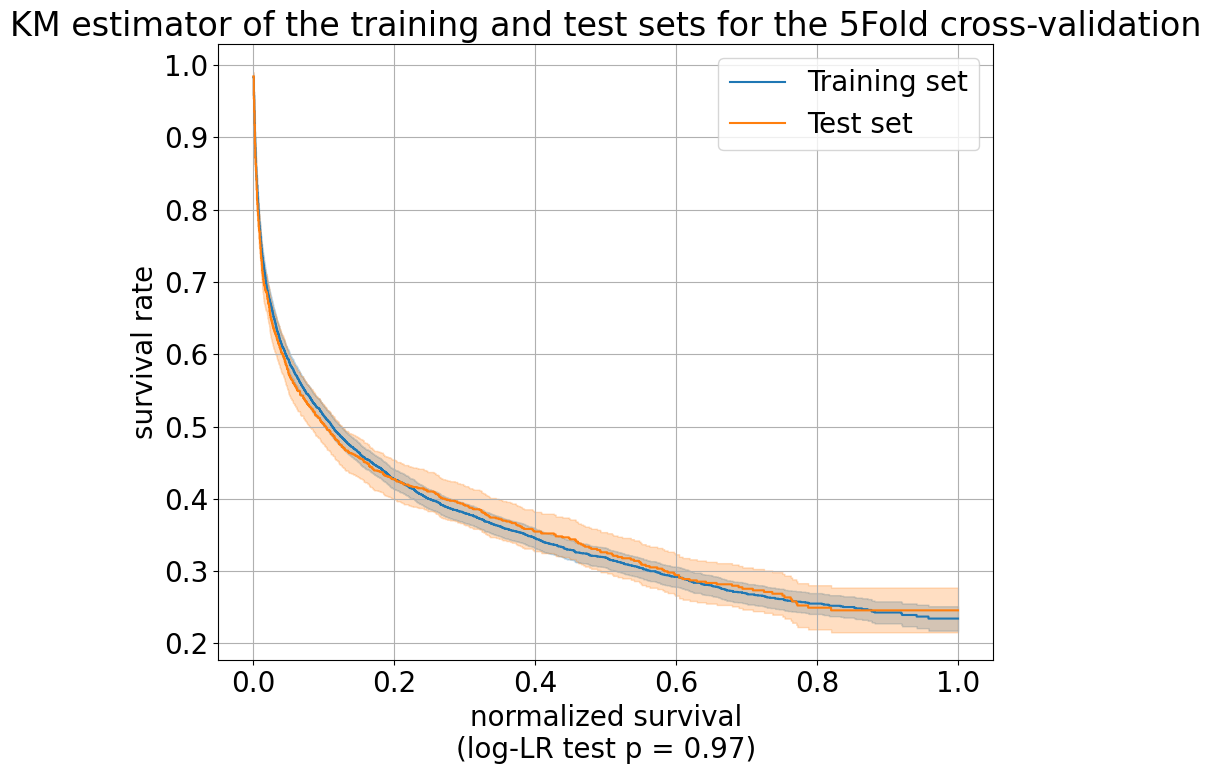

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.038801   1.039563  0.037499       -0.034695        0.112297   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                       0.9659             1.118845     0.0  1.034723   

                  p  -log2(p)  
covariate                      
2          0.300798  1.733132  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.06 0.30      1.72


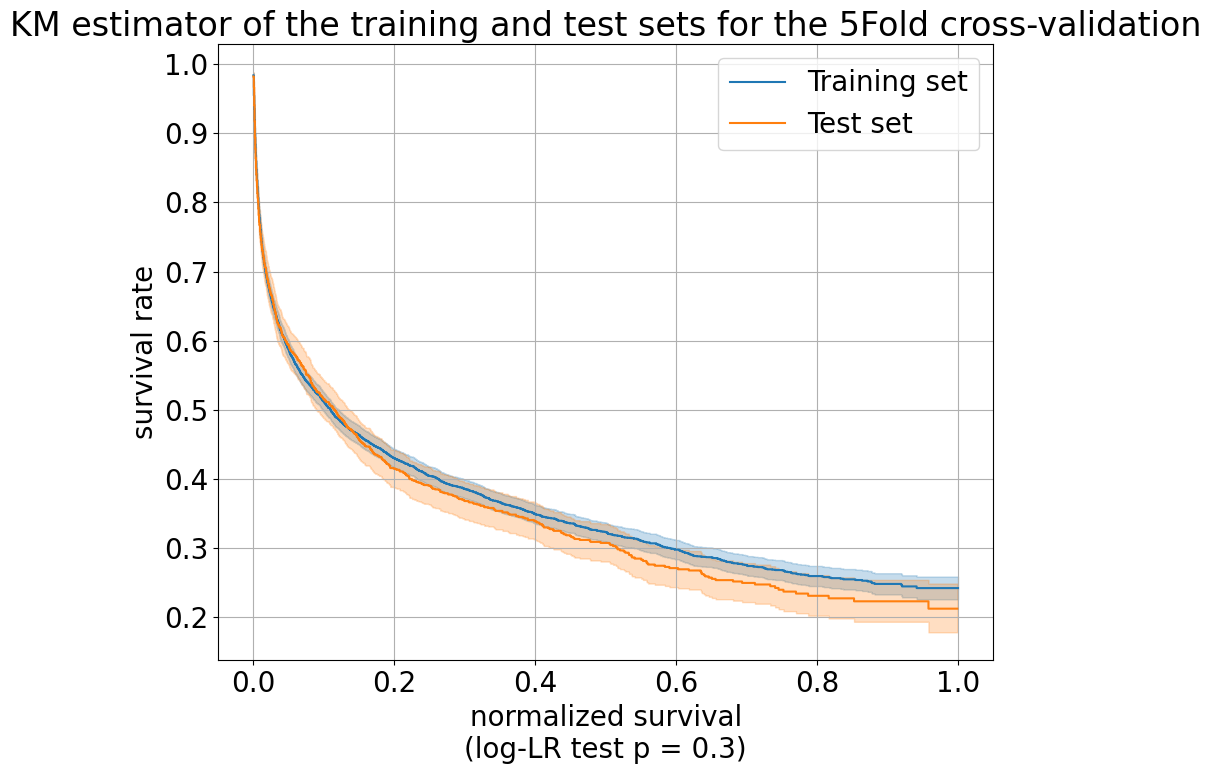

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2         -0.073803   0.928855  0.038287       -0.148843        0.001238   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.861704             1.001239     0.0 -1.927635   

                  p  -log2(p)  
covariate                      
2          0.053901  4.213557  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           3.77 0.05      4.26


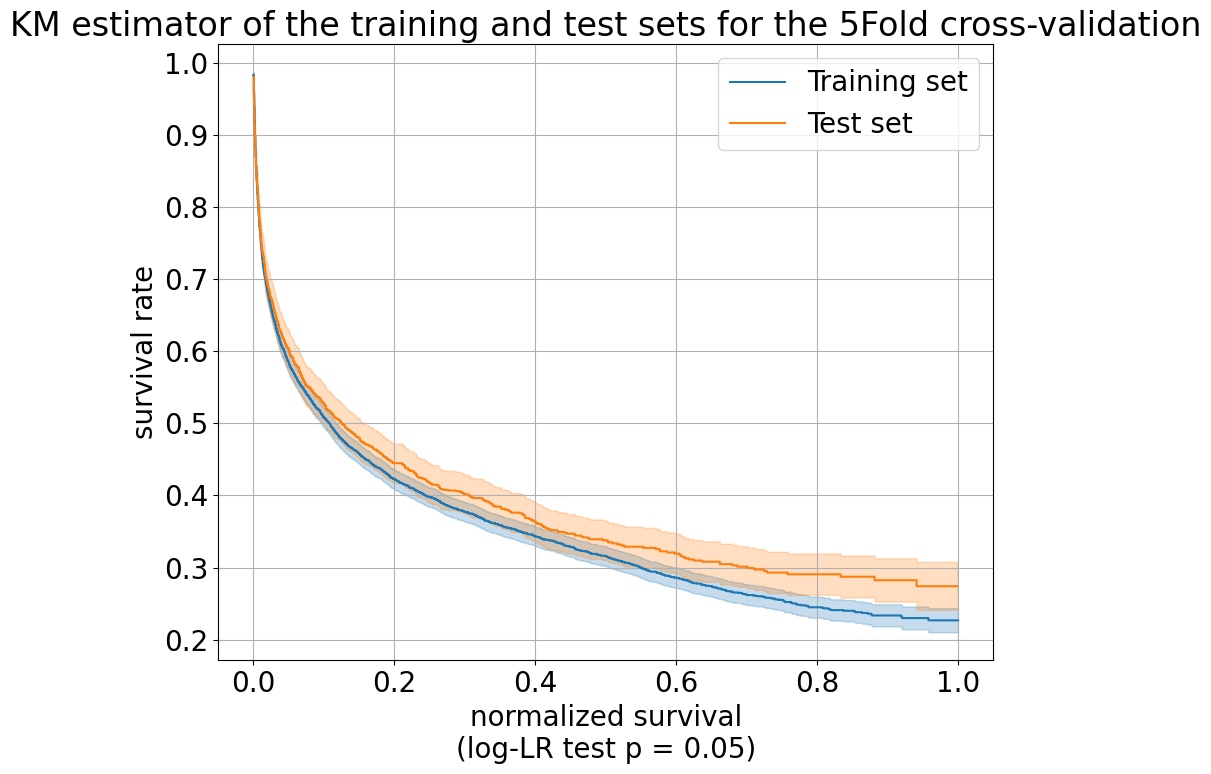

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.018582   1.018756  0.037558       -0.055031        0.092194   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to        z  \
covariate                                                              
2                     0.946456             1.096578     0.0  0.49475   

                  p  -log2(p)  
covariate                      
2          0.620777  0.687853  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.24 0.62      0.69


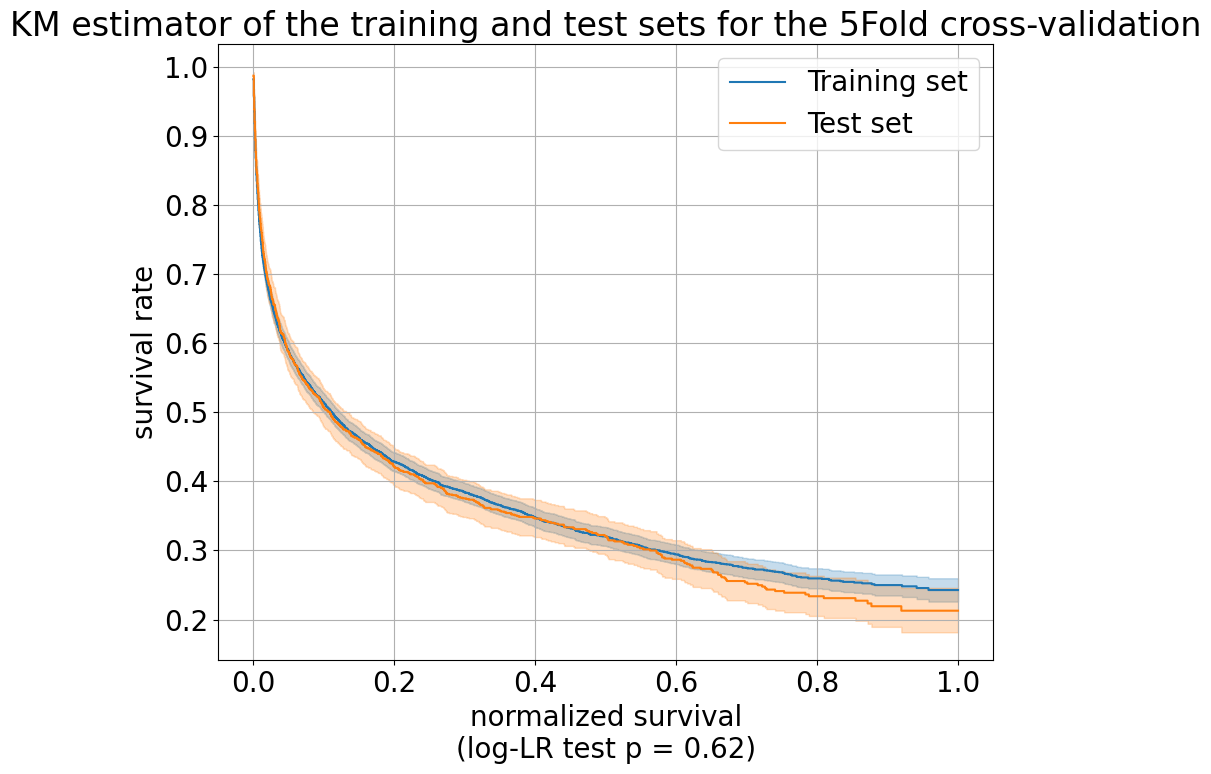

In [45]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)
for train_index, test_index in kf.split(y_train):
    y_train_train, y_train_test = y_train[train_index], y_train[test_index]

    #COX analysis

    cox_test_df = pd.DataFrame(np.append(np.vstack([y_train_train,y_train_test]),np.hstack([np.zeros(len(y_train_train)).T,np.ones(len(y_train_test))]).reshape(-1,1),axis=1))

    cph = CoxPHFitter()
    cph.fit(df = cox_test_df,
            duration_col = 0,
            event_col = 1)

    print(cph.summary)

    #cph.check_assumptions(cox_test_df,show_plots=True,p_value_threshold=0.7)
    #plt.show()

    print(cph.log_likelihood_ratio_test())
    p_val = round(cph.log_likelihood_ratio_test().p_value,2)

    # KM Plot
    plt.figure(figsize=(10,8))
    kmf1 = KaplanMeierFitter(label="Training set")
    kmf1.fit(y_train_train[:,0], y_train_train[:,1])
    kmf1.plot()
    kmf2 = KaplanMeierFitter(label="Test set")
    kmf2.fit(y_train_test[:,0], y_train_test[:,1])
    kmf2.plot()
    plt.title("KM estimator of the training and test sets for the 5Fold cross-validation")
    plt.xlabel(f"normalized survival\n(log-LR test p = {p_val})")
    plt.ylabel("survival rate")
    plt.grid()
    plt.show()

# Censoring Sensitivity Analysis

In [16]:
# Dictionary where all the results can be saved
results_table = {"Model":[],
                 "Optimized_LogRank":[],
                 "T_max":[],
                 "Uncensored_Reduction":[],
                 "5Fold":{"HarrelC":{"mean":[],
                                     "std":[]},
                          "UnoC":{"mean":[],
                                  "std":[]},
                          "iBrier":{"mean":[],
                                    "std":[]},
                          "AUROC":{"mean":[],
                                   "std":[]},
                          "LogRank":{"mean":[],
                                     "std":[]}},
                 "Hold-out":{"HarrelC":[],
                             "UnoC":[],
                             "iBrier":[],
                             "AUROC":[],
                             "LogRank":[]},
                 "Timeline":[],
                 "Overall_Survival_Function":[]}

with open(f"Logs/{NAME}_results.json", "w") as write_file:
        json.dump(results_table, write_file)

## MDN Model

### Shared Parameters

In [17]:
from model import MDN
from utils import NLLLoss, CensoredNLLLoss, AlternativeNLLLoss
from csa import MDNCensoringSensitivityAnalysis

# Fixed
num_epochs = 200
batch_size = 512
input_shape = x_size
learning_rate = 1e-3

<frozen importlib._bootstrap>:228: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


### Use LogRank in Optimizer

In [ ]:
# Hyperparameters [Optimized]
n_hidden = 1024
mixture_components = 5
use_sparse_layer = False
use_sparse_loss = False #Default
lmbd = 1e-4 #Default
use_batchnorm = False
use_dropout = False
dropout = 0.1 #Default
mlp_size_1 = 6
mlp_size_2 = 1
mlp_size_3 = 0
kernel = "Normal"
loss_name = AlternativeNLLLoss

# Properties
Model = MDN
model_name = "MDN"
Optimized_LogRank = True

MDNCSA = MDNCensoringSensitivityAnalysis(Model = Model,
                                         model_name = model_name,
                                         dataset_name = NAME,
                                         X = X,
                                         y = y,
                                         Optimized_LogRank = Optimized_LogRank)

MDNCSA.analyze(n_hidden = n_hidden,
               mixture_components = mixture_components,
               use_sparse_layer = use_sparse_layer,
               use_sparse_loss = use_sparse_loss,
               lmbd = lmbd,
               use_batchnorm = use_batchnorm,
               use_dropout = use_dropout,
               dropout = dropout,
               mlp_size_1 = mlp_size_1,
               mlp_size_2 = mlp_size_2,
               mlp_size_3 = mlp_size_3,
               kernel = kernel,
               loss_name = loss_name,
               num_epochs = num_epochs,
               batch_size = batch_size,
               input_shape = input_shape,
               learning_rate = learning_rate,
               timeline_resolution = timeline_resolution,
               sensitivity_grid = sensitivity_grid)

### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparameters [Optimized]
n_hidden = 2048
mixture_components = 5
use_sparse_layer = False
use_sparse_loss = False #Default
lmbd = 1e-4 #Default
use_batchnorm = False
use_dropout = False
dropout = 0.1 #Default
mlp_size_1 = 7
mlp_size_2 = 1
mlp_size_3 = 0
kernel = "Normal"
loss_name = AlternativeNLLLoss

# Properties
Model = MDN
model_name = "MDN"
Optimized_LogRank = False

MDNCSA = MDNCensoringSensitivityAnalysis(Model = Model,
                                         model_name = model_name,
                                         dataset_name = NAME,
                                         X = X,
                                         y = y,
                                         Optimized_LogRank = Optimized_LogRank)

MDNCSA.analyze(n_hidden = n_hidden,
               mixture_components = mixture_components,
               use_sparse_layer = use_sparse_layer,
               use_sparse_loss = use_sparse_loss,
               lmbd = lmbd,
               use_batchnorm = use_batchnorm,
               use_dropout = use_dropout,
               dropout = dropout,
               mlp_size_1 = mlp_size_1,
               mlp_size_2 = mlp_size_2,
               mlp_size_3 = mlp_size_3,
               kernel = kernel,
               loss_name = loss_name,
               num_epochs = num_epochs,
               batch_size = batch_size,
               input_shape = input_shape,
               learning_rate = learning_rate,
               timeline_resolution = timeline_resolution,
               sensitivity_grid = sensitivity_grid)

### Compare LogRank vs. No LogRank

In [ ]:
with open(f"Logs/{NAME}_results.json", "r") as read_file:
    results_table = json.load(read_file)

In [ ]:
for i in range(len(results_table["Model"])):
    if (results_table["Model"][i] == "MDN") & (results_table["Optimized_LogRank"][i] == True) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
        tl_lr = np.array(results_table["Timeline"][i])
        osf_lr = np.array(results_table["Overall_Survival_Function"][i])

for i in range(len(results_table["Model"])):
    if (results_table["Model"][i] == "MDN") & (results_table["Optimized_LogRank"][i] == False) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
        tl_nlr = np.array(results_table["Timeline"][i])
        osf_nlr = np.array(results_table["Overall_Survival_Function"][i])

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]

km_timeline, km_prob_survival = kaplan_meier_estimator(y_test[:,1].astype(bool),y_test[:,0])
plt.plot(tl_lr, osf_lr, label = "LogRank")
plt.plot(tl_nlr, osf_nlr, label = "No LogRank")
plt.plot(km_timeline,km_prob_survival, label = "KM")
plt.legend()
plt.show()

## Other Models

In [31]:
from csa import MLCensoringSensitivityAnalysis

### CPH

In [32]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
alpha = 1.902531234373698
ties = "breslow"
n_iter = 2000

# Properties
Model = CoxPHSurvivalAnalysis
model_name = "CoxPH"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       alpha = alpha,
                                       ties = ties,
                                       n_iter = n_iter)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
alpha = 1.901950441915944
ties = "breslow"
n_iter = 2000

# Properties
Model = CoxPHSurvivalAnalysis
model_name = "CoxPH"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       alpha = alpha,
                                       ties = ties,
                                       n_iter = n_iter)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

### Tree

In [35]:
from sksurv.tree import SurvivalTree

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
splitter = "random"
min_samples_split = 0.055712934537462955
min_samples_leaf = 0.03408515454971367
min_weight_fraction_leaf = 0.02670977990584805
max_features = 0.922010288159367
random_state = 42

# Properties
Model = SurvivalTree
model_name = "SurvivalTree"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       splitter = splitter,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
splitter = "random"
min_samples_split = 0.16757347345383158
min_samples_leaf = 0.016931189695610048
min_weight_fraction_leaf = 0.06830819473749297
max_features = 0.929829119479573
random_state = 42

# Properties
Model = SurvivalTree
model_name = "SurvivalTree"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       splitter = splitter,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

### Forest

In [ ]:
from sksurv.ensemble import RandomSurvivalForest

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
n_estimators = 205
min_samples_split = 0.020291985051448524
min_samples_leaf = 0.1385578826583956
min_weight_fraction_leaf = 0.008989451494319872
max_features = 0.8506371302781686
bootstrap = False
max_samples = 0.9787021656147553
oob_score = False
n_jobs = 10
random_state = 42

# Properties
Model = RandomSurvivalForest
model_name = "RandomSurvivalForest"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       n_estimators = n_estimators,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       bootstrap = bootstrap,
                                       max_samples = max_samples,
                                       oob_score = oob_score,
                                       n_jobs = n_jobs,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
n_estimators = 124
min_samples_split = 0.03761532050050915
min_samples_leaf = 0.13645173002854044
min_weight_fraction_leaf = 0.04666117897858357
max_features = 0.8542962778415047
bootstrap = False
max_samples = 0.3443573258239851
oob_score = False
n_jobs = 10
random_state = 42

# Properties
Model = RandomSurvivalForest
model_name = "RandomSurvivalForest"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       n_estimators = n_estimators,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       bootstrap = bootstrap,
                                       max_samples = max_samples,
                                       oob_score = oob_score,
                                       n_jobs = n_jobs,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

### Boosting

In [ ]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
loss="coxph"
learning_rate=0.05326036681207171
n_estimators=413
criterion="friedman_mse"
min_samples_split=6
min_samples_leaf=10
min_weight_fraction_leaf=0.0013256181705589669
min_impurity_decrease=0.10302668262176118
max_features=0.6380604646352928
subsample=0.32060745061710066
dropout_rate=0.027233809246884743
ccp_alpha=0.0021238506677129228
random_state = 42

# Properties
Model = GradientBoostingSurvivalAnalysis
model_name = "GradientBoosting"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       loss=loss,
                                       learning_rate=learning_rate,
                                       n_estimators=n_estimators,
                                       criterion=criterion,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                                       min_impurity_decrease=min_impurity_decrease,
                                       max_features=max_features,
                                       subsample=subsample,
                                       dropout_rate=dropout_rate,
                                       ccp_alpha=ccp_alpha,
                                       random_state=random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
loss="coxph"
learning_rate=0.09450938081019804
n_estimators=152
criterion="friedman_mse"
min_samples_split=3
min_samples_leaf=3
min_weight_fraction_leaf=0.01641918596620047
min_impurity_decrease=0.6059208066615676
max_features=0.6360435181524643
subsample=0.1099890912801106
dropout_rate=0.00042444183152235
ccp_alpha=0.0018042303936572587
random_state = 42

# Properties
Model = GradientBoostingSurvivalAnalysis
model_name = "GradientBoosting"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       loss=loss,
                                       learning_rate=learning_rate,
                                       n_estimators=n_estimators,
                                       criterion=criterion,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                                       min_impurity_decrease=min_impurity_decrease,
                                       max_features=max_features,
                                       subsample=subsample,
                                       dropout_rate=dropout_rate,
                                       ccp_alpha=ccp_alpha,
                                       random_state=random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

# Results

In [12]:
with open(f"Logs/{NAME}_results.json", "r") as read_file:
    results_table = json.load(read_file)

## 5-Fold

In [13]:
# 5FOLD

models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True,False]
trials = list(product(models,opts))

main_results_5fold  = {"Model":[],
                       "c-index $\\uparrow$":[],
                       "iBrier $\\downarrow$":[],
                       "AUROC $\\uparrow$":[],
                       "LogRank $\\uparrow$":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            main_results_5fold["Model"].append(f"{trial[0]} " + ["$^{^{LogRank}}$" if trial[1] == True else ""][0])
            main_results_5fold["c-index $\\uparrow$"].append( str(round(results_table["5Fold"]["UnoC"]["mean"][i],4)).ljust(6,"0") +"$\pm$" + str(round(1.96*results_table["5Fold"]["UnoC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            main_results_5fold["iBrier $\\downarrow$"].append( str(round(results_table["5Fold"]["iBrier"]["mean"][i],4)).ljust(6,"0") +"$\pm$" + str(round(1.96*results_table["5Fold"]["iBrier"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            main_results_5fold["AUROC $\\uparrow$"].append( str(round(results_table["5Fold"]["AUROC"]["mean"][i],4)).ljust(6,"0") +" $\pm$" + str(round(1.96*results_table["5Fold"]["AUROC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            main_results_5fold["LogRank $\\uparrow$"].append( str(round(results_table["5Fold"]["LogRank"]["mean"][i],4)).ljust(6,"0") +" $\pm$" + str(round(1.96*results_table["5Fold"]["LogRank"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )

main_results_5fold = pd.DataFrame.from_dict(main_results_5fold)

In [14]:
main_results_5fold

Model c-index $\uparrow$  \
0                 CoxPH $^{^{LogRank}}$  0.8260$\pm$0.0069   
1                                CoxPH   0.8260$\pm$0.0069   
2          SurvivalTree $^{^{LogRank}}$  0.8195$\pm$0.0033   
3                         SurvivalTree   0.8118$\pm$0.0044   
4  RandomSurvivalForest $^{^{LogRank}}$  0.8378$\pm$0.0056   
5                 RandomSurvivalForest   0.8377$\pm$0.0063   
6      GradientBoosting $^{^{LogRank}}$  0.8557$\pm$0.0054   
7                     GradientBoosting   0.8584$\pm$0.0050   
8                   MDN $^{^{LogRank}}$  0.8472$\pm$0.0050   
9                                  MDN   0.8489$\pm$0.0090   

  iBrier $\downarrow$    AUROC $\uparrow$  LogRank $\uparrow$  
0   0.1409$\pm$0.0088  0.8611 $\pm$0.0099  0.1447 $\pm$0.0415  
1   0.1409$\pm$0.0088  0.8611 $\pm$0.0099  0.1447 $\pm$0.0415  
2   0.1308$\pm$0.0041  0.8863 $\pm$0.0049  0.5367 $\pm$0.1861  
3   0.1316$\pm$0.0053  0.8818 $\pm$0.0061  0.8604 $\pm$0.0745  
4   0.1339$\pm$0.0053  0.8922 $\pm$0.0066  0.3308 $\pm$0.1000  
5   0.1337$\pm$0.0052  0.8921 $\pm$0.0066  0.3419 $\pm$0.1120  
6   0.1495$\pm$0.0078  0.8810 $\pm$0.0070  0.2363 $\pm$0.1416  
7   0.1344$\pm$0.0069  0.8803 $\pm$0.0059  0.0317 $\pm$0.0104  
8   0.1299$\pm$0.0060  0.8724 $\pm$0.0063  0.4816 $\pm$0.2881  
9   0.1300$\pm$0.0088  0.8721 $\pm$0.0096  0.5426 $\pm$0.2124

In [15]:
# Latex version for the Paper
print(main_results_5fold.style.hide(axis="index").to_latex(hrules=True))

\begin{tabular}{lllll}
\toprule
Model & c-index $\uparrow$ & iBrier $\downarrow$ & AUROC $\uparrow$ & LogRank $\uparrow$ \\
\midrule
CoxPH $^{^{LogRank}}$ & 0.8260$\pm$0.0069 & 0.1409$\pm$0.0088 & 0.8611 $\pm$0.0099 & 0.1447 $\pm$0.0415 \\
CoxPH  & 0.8260$\pm$0.0069 & 0.1409$\pm$0.0088 & 0.8611 $\pm$0.0099 & 0.1447 $\pm$0.0415 \\
SurvivalTree $^{^{LogRank}}$ & 0.8195$\pm$0.0033 & 0.1308$\pm$0.0041 & 0.8863 $\pm$0.0049 & 0.5367 $\pm$0.1861 \\
SurvivalTree  & 0.8118$\pm$0.0044 & 0.1316$\pm$0.0053 & 0.8818 $\pm$0.0061 & 0.8604 $\pm$0.0745 \\
RandomSurvivalForest $^{^{LogRank}}$ & 0.8378$\pm$0.0056 & 0.1339$\pm$0.0053 & 0.8922 $\pm$0.0066 & 0.3308 $\pm$0.1000 \\
RandomSurvivalForest  & 0.8377$\pm$0.0063 & 0.1337$\pm$0.0052 & 0.8921 $\pm$0.0066 & 0.3419 $\pm$0.1120 \\
GradientBoosting $^{^{LogRank}}$ & 0.8557$\pm$0.0054 & 0.1495$\pm$0.0078 & 0.8810 $\pm$0.0070 & 0.2363 $\pm$0.1416 \\
GradientBoosting  & 0.8584$\pm$0.0050 & 0.1344$\pm$0.0069 & 0.8803 $\pm$0.0059 & 0.0317 $\pm$0.0104 \\
MDN $

## Hold-out

In [16]:
# HOLD-OUT

models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True,False]
trials = list(product(models,opts))

main_results_hold_out  = {"Model":[],
                          "c-index $\\uparrow$":[],
                          "iBrier $\\downarrow$":[],
                          "AUROC $\\uparrow$":[],
                          "LogRank $\\uparrow$":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            main_results_hold_out["Model"].append(f"{trial[0]} " + ["$^{^{LogRank}}$" if trial[1] == True else ""][0])
            main_results_hold_out["c-index $\\uparrow$"].append( str(round(results_table["Hold-out"]["UnoC"][i],4)).ljust(6,"0") )
            main_results_hold_out["iBrier $\\downarrow$"].append( str(round(results_table["Hold-out"]["iBrier"][i],4)).ljust(6,"0") )
            main_results_hold_out["AUROC $\\uparrow$"].append( str(round(results_table["Hold-out"]["AUROC"][i],4)).ljust(6,"0") )
            main_results_hold_out["LogRank $\\uparrow$"].append( str(round(results_table["Hold-out"]["LogRank"][i],4)).ljust(6,"0") )

main_results_hold_out = pd.DataFrame.from_dict(main_results_hold_out)

In [17]:
main_results_hold_out

Model c-index $\uparrow$  \
0                 CoxPH $^{^{LogRank}}$             0.8269   
1                                CoxPH              0.8269   
2          SurvivalTree $^{^{LogRank}}$             0.8292   
3                         SurvivalTree              0.8174   
4  RandomSurvivalForest $^{^{LogRank}}$             0.8440   
5                 RandomSurvivalForest              0.8454   
6      GradientBoosting $^{^{LogRank}}$             0.8678   
7                     GradientBoosting              0.8692   
8                   MDN $^{^{LogRank}}$             0.8562   
9                                  MDN              0.8560   

  iBrier $\downarrow$ AUROC $\uparrow$ LogRank $\uparrow$  
0              0.1423           0.8599             0.0495  
1              0.1423           0.8599             0.0495  
2              0.1270           0.8935             0.1376  
3              0.1287           0.8867             0.9378  
4              0.1309           0.8965             0.1922  
5              0.1307           0.8963             0.2204  
6              0.1529           0.8945             0.0917  
7              0.1354           0.8919             0.0047  
8              0.1266           0.8790             0.5749  
9              0.1282           0.8802             0.1639

In [18]:
print(main_results_hold_out.style.hide(axis="index").to_latex(hrules=True))

\begin{tabular}{lllll}
\toprule
Model & c-index $\uparrow$ & iBrier $\downarrow$ & AUROC $\uparrow$ & LogRank $\uparrow$ \\
\midrule
CoxPH $^{^{LogRank}}$ & 0.8269 & 0.1423 & 0.8599 & 0.0495 \\
CoxPH  & 0.8269 & 0.1423 & 0.8599 & 0.0495 \\
SurvivalTree $^{^{LogRank}}$ & 0.8292 & 0.1270 & 0.8935 & 0.1376 \\
SurvivalTree  & 0.8174 & 0.1287 & 0.8867 & 0.9378 \\
RandomSurvivalForest $^{^{LogRank}}$ & 0.8440 & 0.1309 & 0.8965 & 0.1922 \\
RandomSurvivalForest  & 0.8454 & 0.1307 & 0.8963 & 0.2204 \\
GradientBoosting $^{^{LogRank}}$ & 0.8678 & 0.1529 & 0.8945 & 0.0917 \\
GradientBoosting  & 0.8692 & 0.1354 & 0.8919 & 0.0047 \\
MDN $^{^{LogRank}}$ & 0.8562 & 0.1266 & 0.8790 & 0.5749 \\
MDN  & 0.8560 & 0.1282 & 0.8802 & 0.1639 \\
\bottomrule
\end{tabular}



## Main results - Plots

In [19]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["green","purple","orange","red","blue"]
opts = [True,False]
typs = ["5Fold","Hold-out"]
scores = ["UnoC","iBrier","AUROC","LogRank"]
trials = list(product(models,opts,typs,scores))

main_results_plot  = {"Model":[],
                      "Color":[],
                      "Type":[],
                      "Score":[],
                      "mean":[],
                      "std":[]}

for trial in trials:
    main_results_plot["Model"].append(f"{trial[0]} " + ["$^{^{LogRank}}$" if trial[1] == True else ""][0])
    main_results_plot["Color"].append([item[1] for item in zip(models,colors) if item[0] == trial[0]][0])
    main_results_plot["Type"].append(trial[2])
    if trial[3] == "iBrier":
        main_results_plot["Score"].append("$\\leftarrow$ " + trial[3])
    else:
        main_results_plot["Score"].append(trial[3] + " $\\rightarrow$")
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            if trial[2] == "5Fold":
                main_results_plot["mean"].append(results_table[trial[2]][trial[3]]["mean"][i])
                main_results_plot["std"].append(1.96*results_table[trial[2]][trial[3]]["std"][i]/np.sqrt(5))
            else:
                main_results_plot["mean"].append(results_table[trial[2]][trial[3]][i])
                main_results_plot["std"].append(0)

main_results_plot = pd.DataFrame.from_dict(main_results_plot)

### 5Fold

C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_17912\403590824.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_17912\403590824.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_17912\403590824.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_17912\403590824.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")


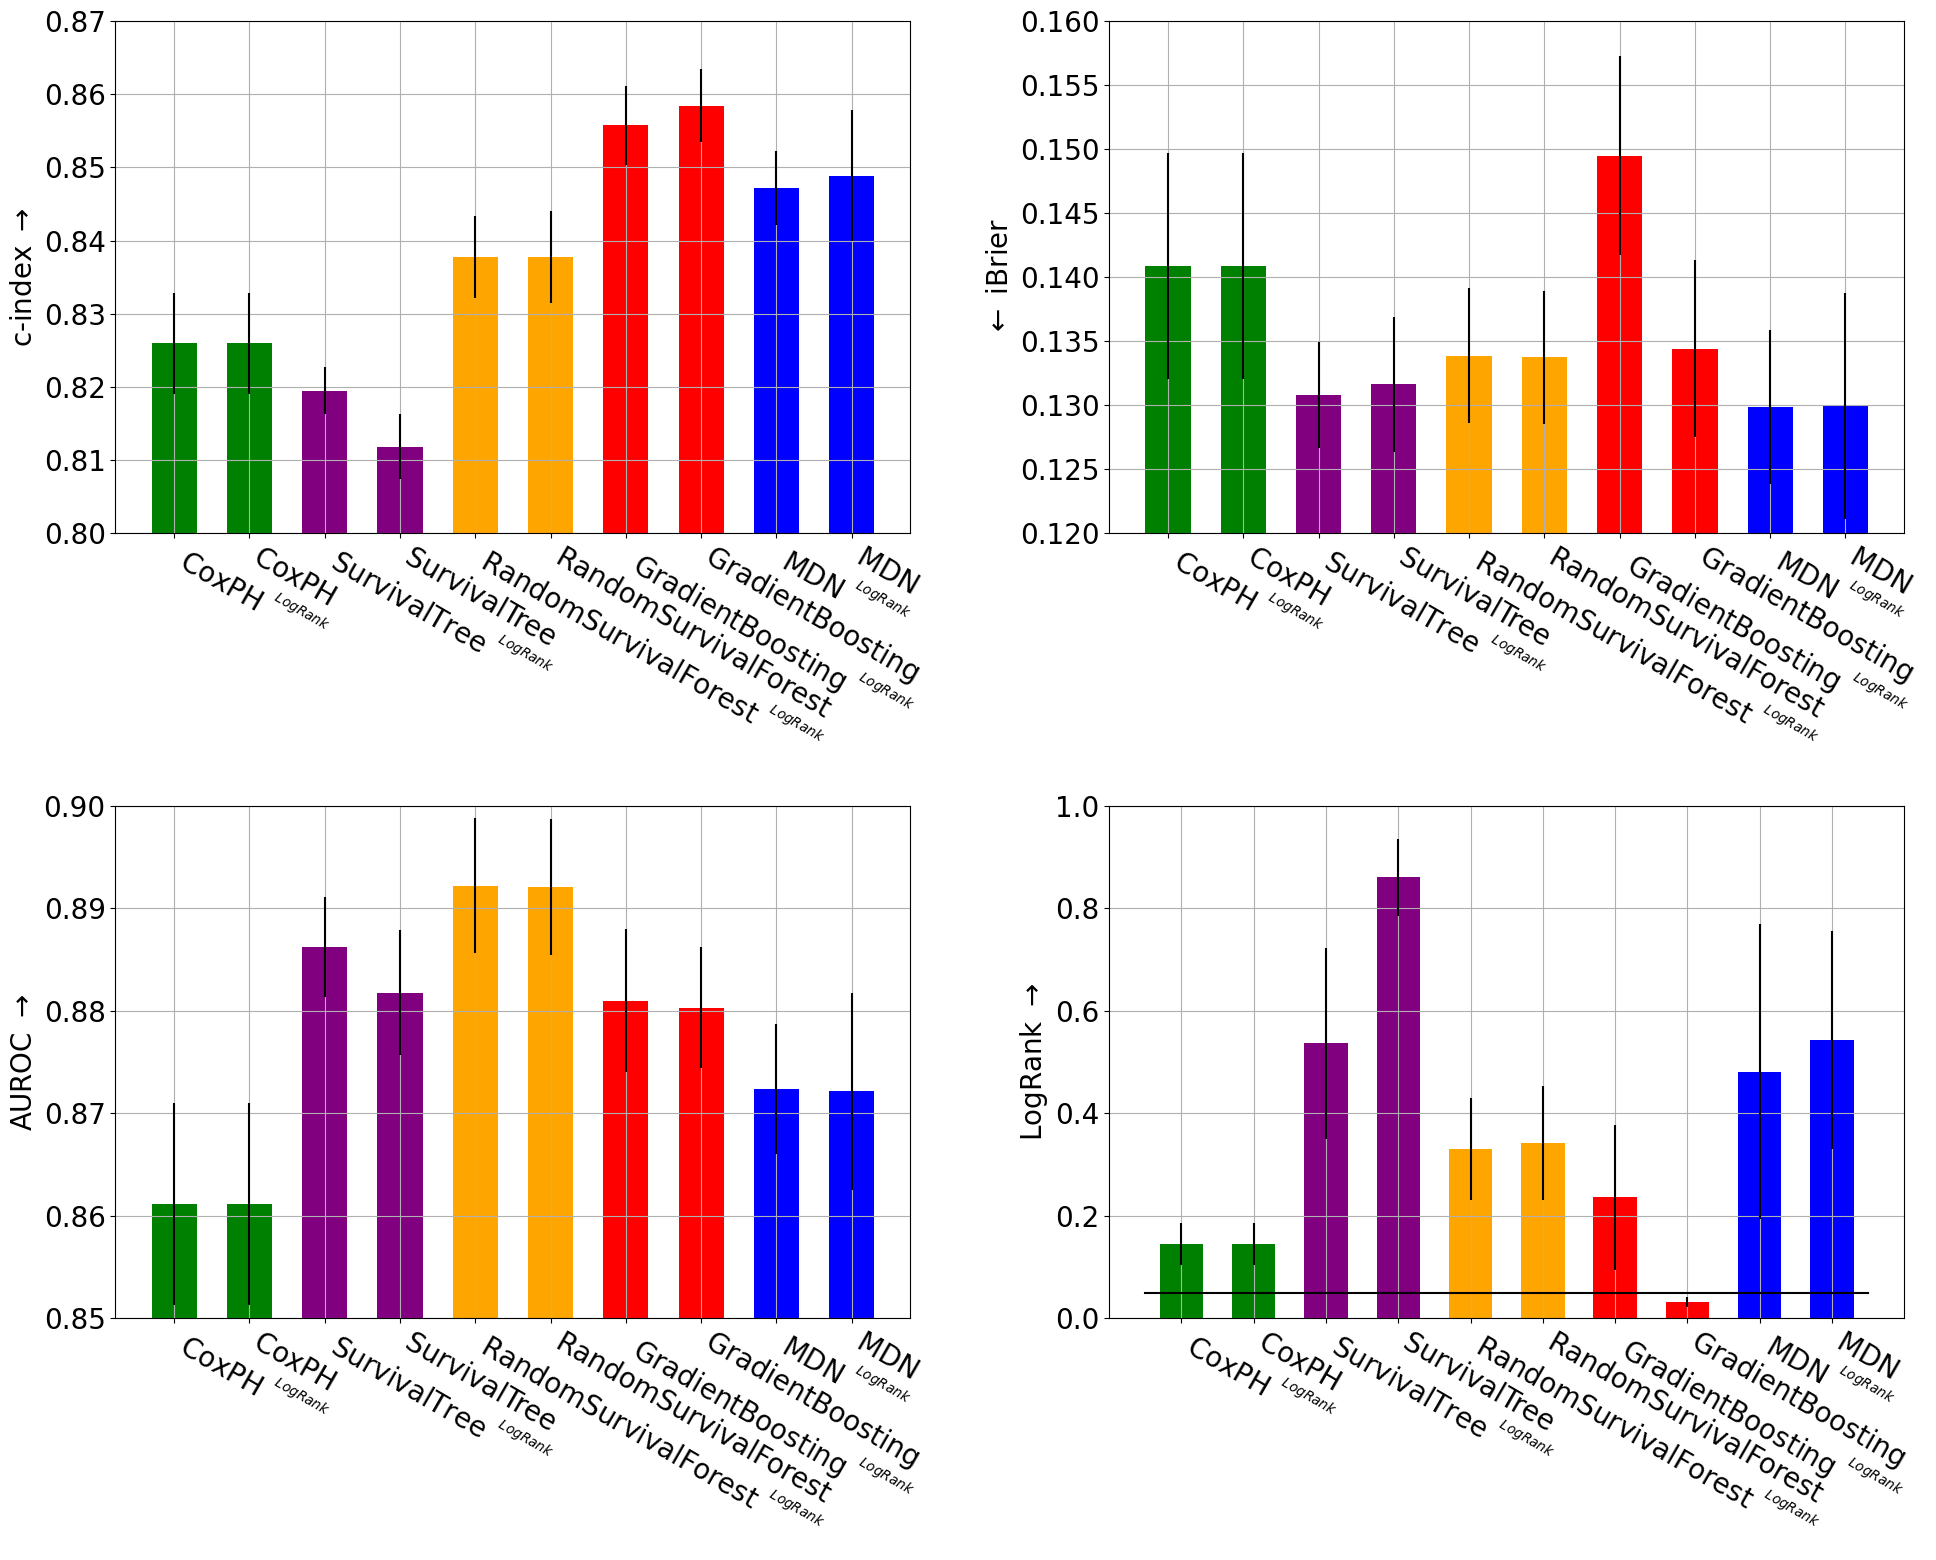

In [20]:
typ = "5Fold"

fig, axs = plt.subplots(2,2,figsize=(20,16))
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
locs = [[0,0],[0,1],[1,0],[1,1]]
ylims = [[0.8,0.87],[0.12,0.16],[0.85,0.9],[0,1]]

for scr,loc,ylim in zip(scores,locs,ylims):
    for _,row in main_results_plot[(main_results_plot.Type == typ) & (main_results_plot.Score == scr)].iterrows():
        b = axs[loc[0]][loc[1]].bar(row.Model, height = row["mean"],width = 0.6, yerr = row["std"], color = row.Color)
    if scr == "LogRank $\\rightarrow$":
        #axs[loc[0]][loc[1]].set_yscale("log")
        axs[loc[0]][loc[1]].plot(np.linspace(-0.5,9.5,100),0.05*np.ones(100),marker = "", color = "black", label = "LogRank success > 0.05")
    #axs[loc[0]][loc[1]].tick_params(axis='x', labelrotation=-45, length = 40)
    axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
    if scr == "UnoC $\\rightarrow$":
        axs[loc[0]][loc[1]].set_ylabel("c-index $\\rightarrow$")
    else:
        axs[loc[0]][loc[1]].set_ylabel(scr)
    axs[loc[0]][loc[1]].set_ylim((ylim[0],ylim[1]))
    axs[loc[0]][loc[1]].grid("x")

#_ = fig.suptitle(f"{NAME_PLOT} advantage of LogRank optimization {typ} scores")
fig.tight_layout()

### Hold-out

C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_17912\714010366.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_17912\714010366.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_17912\714010366.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_17912\714010366.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")


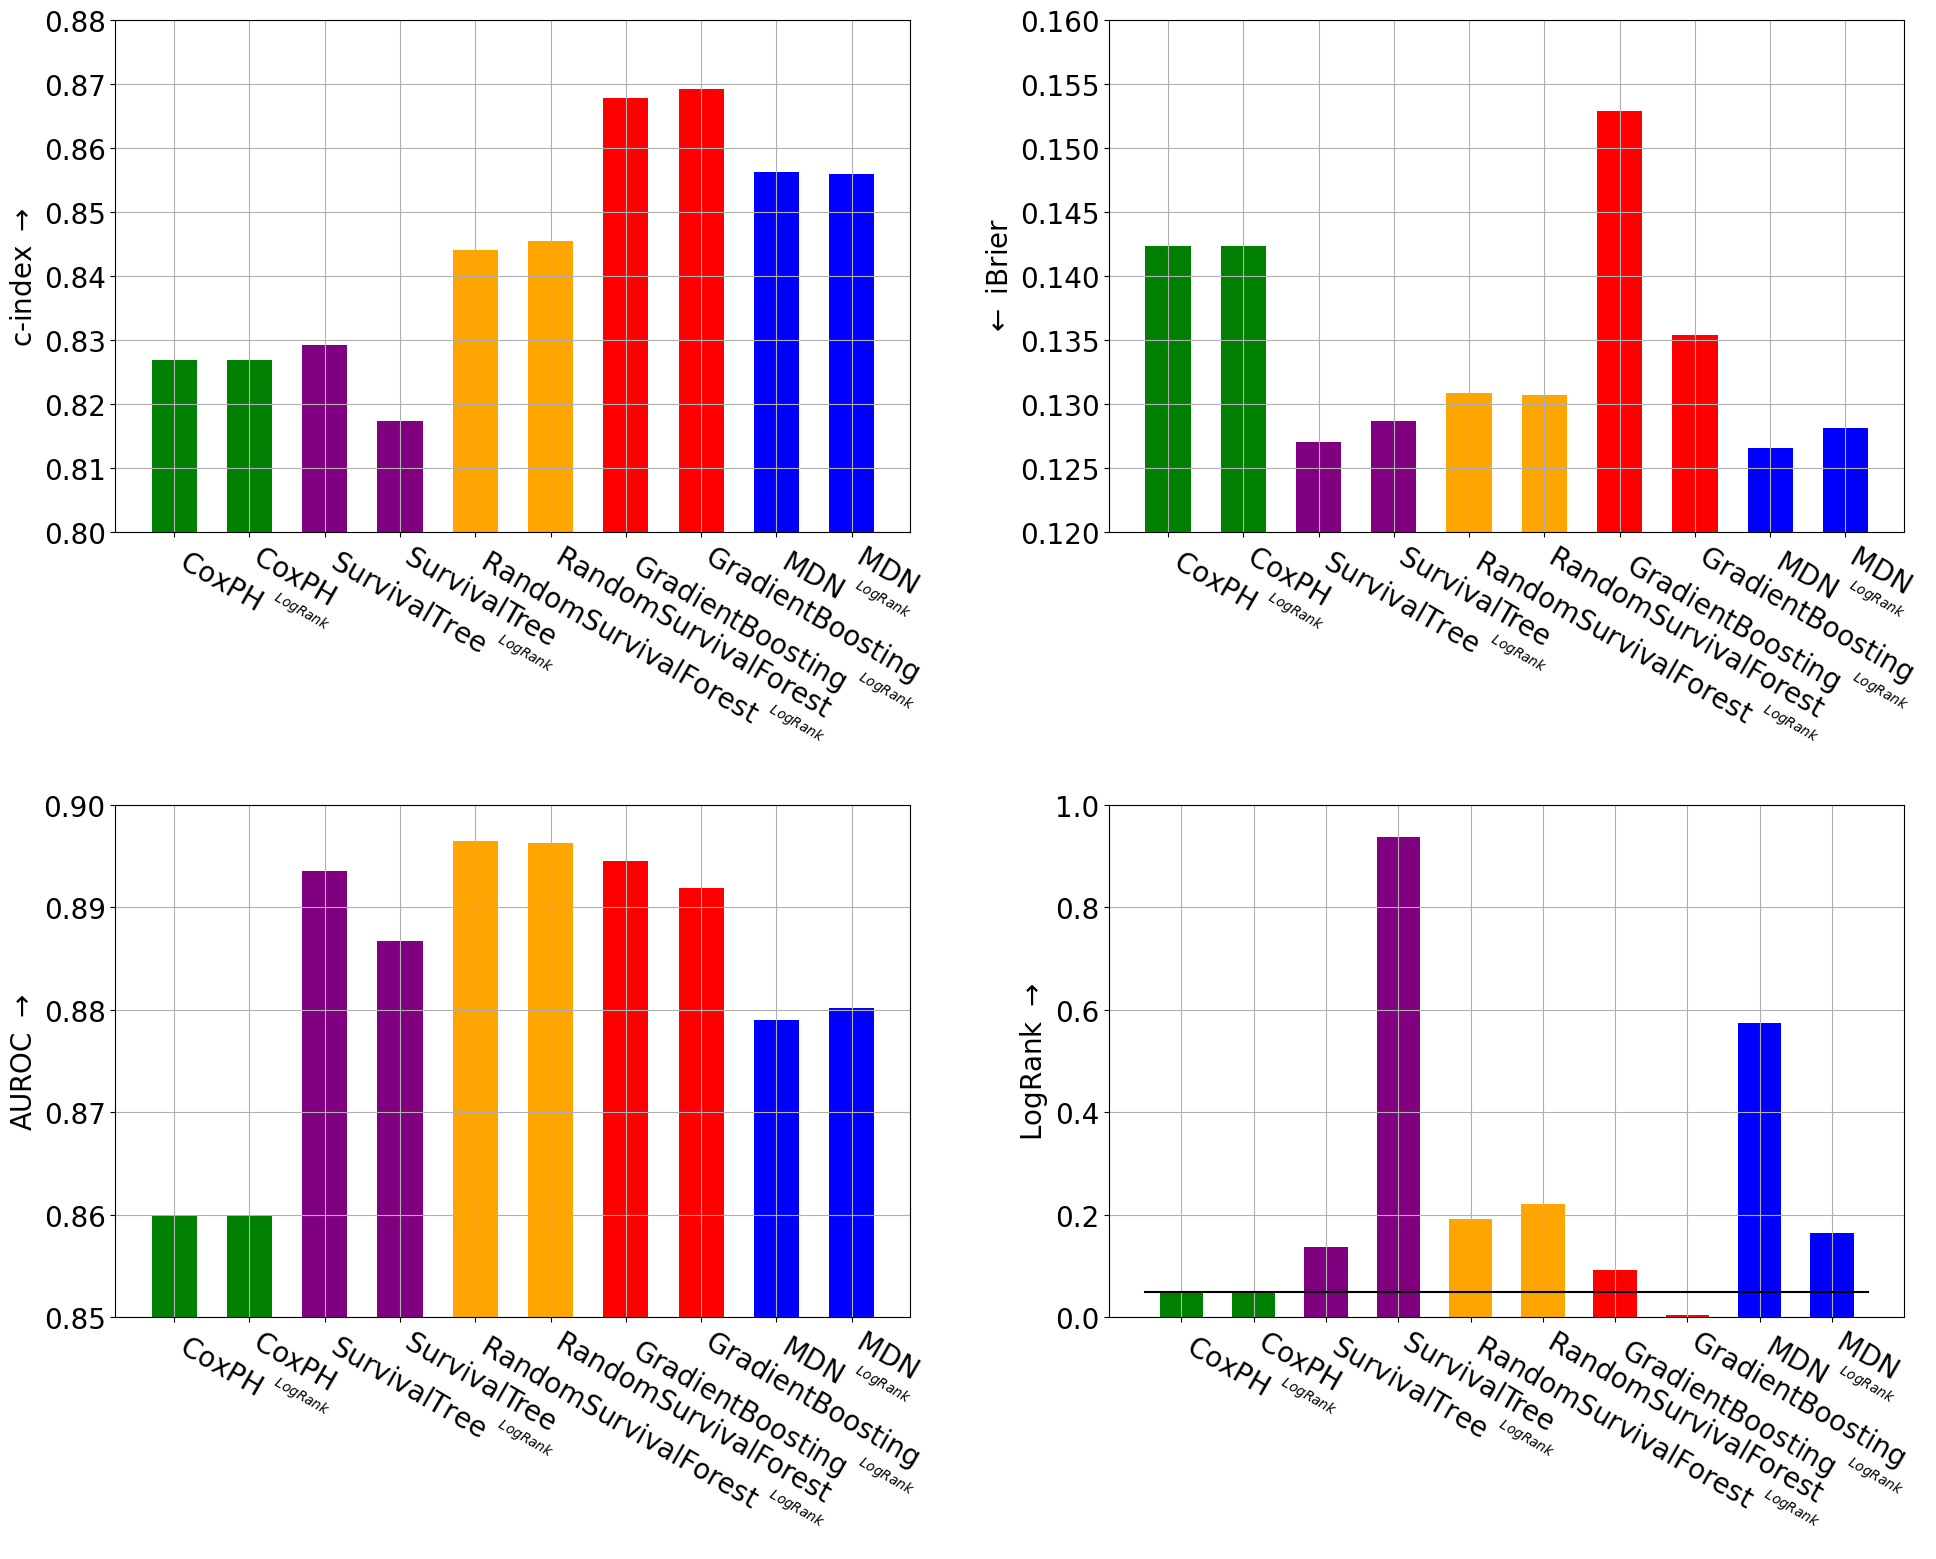

In [21]:
typ = "Hold-out"

fig, axs = plt.subplots(2,2,figsize=(20,16))
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
locs = [[0,0],[0,1],[1,0],[1,1]]
ylims = [[0.8,0.88],[0.12,0.16],[0.85,0.9],[0,1]]

for scr,loc,ylim in zip(scores,locs,ylims):
    for _,row in main_results_plot[(main_results_plot.Type == typ) & (main_results_plot.Score == scr)].iterrows():
        b = axs[loc[0]][loc[1]].bar(row.Model, height = row["mean"],width = 0.6, yerr = row["std"], color = row.Color)
    if scr == "LogRank $\\rightarrow$":
        #axs[loc[0]][loc[1]].set_yscale("log")
        axs[loc[0]][loc[1]].plot(np.linspace(-0.5,9.5,100),0.05*np.ones(100),marker = "", color = "black", label = "LogRank success > 0.05")
    #axs[loc[0]][loc[1]].tick_params(axis='x', labelrotation=-45)
    axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
    if scr == "UnoC $\\rightarrow$":
        axs[loc[0]][loc[1]].set_ylabel("c-index $\\rightarrow$")
    else:
        axs[loc[0]][loc[1]].set_ylabel(scr)
    axs[loc[0]][loc[1]].set_ylim((ylim[0],ylim[1]))
    axs[loc[0]][loc[1]].grid("x")

#_ = fig.suptitle(f"{NAME_PLOT} advantage of LogRank optimization {typ} scores")
fig.tight_layout()#rect=[0, 0.03, 1, 0.99])

## Compare Survival functions

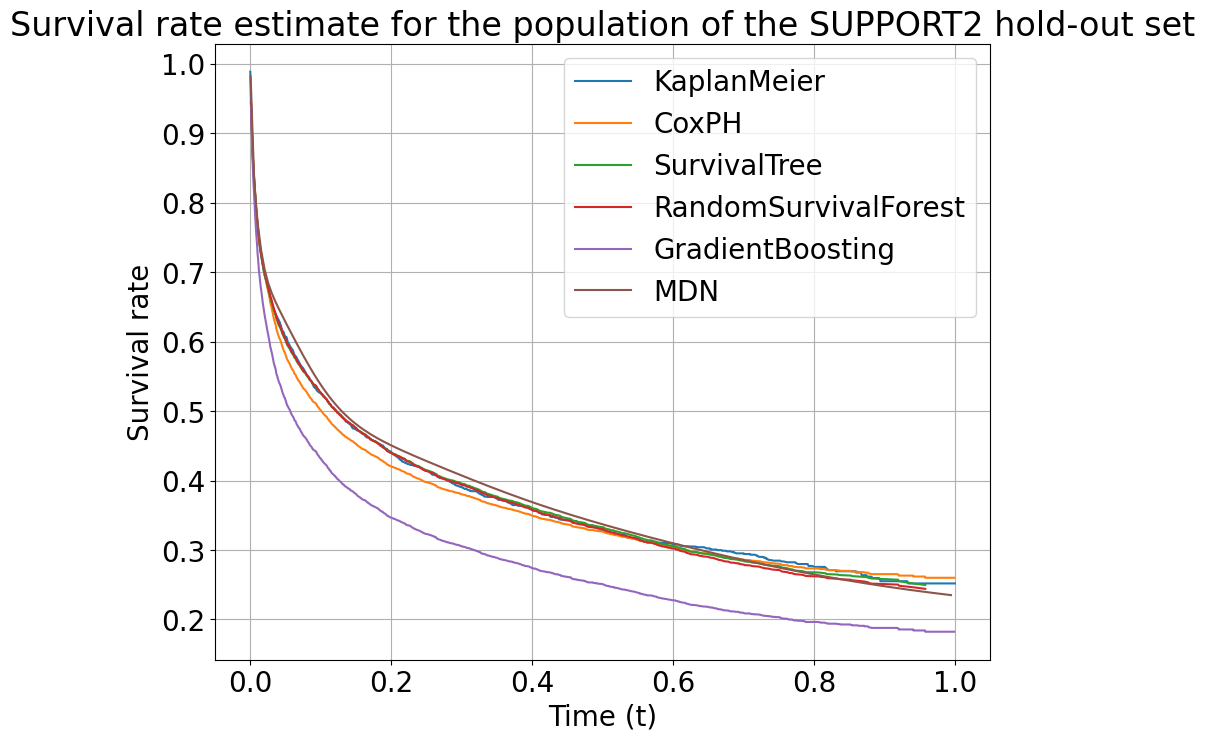

In [22]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True]
trials = list(product(models,opts))

compare_survival  = {"Model":[],
                     "Timeline":[],
                     "Survival_Function":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            compare_survival["Model"].append(f"{trial[0]}")
            compare_survival["Timeline"].append(results_table["Timeline"][i])
            compare_survival["Survival_Function"].append(results_table["Overall_Survival_Function"][i])
            

plt.figure(figsize=(10,8))
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]
km_timeline, km_prob_survival = kaplan_meier_estimator(y_test[:,1].astype(bool),y_test[:,0])
plt.plot(km_timeline,km_prob_survival, label = "KaplanMeier")

for i in range(len(compare_survival["Model"])):
    plt.plot(compare_survival["Timeline"][i], compare_survival["Survival_Function"][i], label = compare_survival["Model"][i])
plt.legend()
plt.grid()
plt.title(f"Survival rate estimate for the population of the {NAME_PLOT} hold-out set")
plt.xlabel("Time (t)")
plt.ylabel("Survival rate")
#plt.xscale("log")
#plt.yscale("log")
plt.show()

## Sensitivity analysis
### Stratify by Score & Quantile

In [23]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["green","purple","orange","red","blue"]
opts = [True]
T_maxs = [0.25,0.5,0.75,1.0]
typs = ["5Fold","Hold-out"]
scores = ["UnoC","iBrier","AUROC","LogRank"]
trials = list(product(models,opts,T_maxs,typs,scores))

sensitivity_analysis_  = {"Model":[],
                         "Color":[],
                         "Legend":[],
                         "Type":[],
                         "Score":[],
                         "T_max":[],
                         "Ts":[],
                         "means":[],
                         "stds":[]}

for trial in trials:
    sensitivity_analysis_["Model"].append(trial[0])
    sensitivity_analysis_["Color"].append([item[1] for item in zip(models,colors) if item[0] == trial[0]][0])
    sensitivity_analysis_["Legend"].append(trial[0])
    sensitivity_analysis_["Type"].append(trial[3])
    if trial[4] == "iBrier":
        sensitivity_analysis_["Score"].append("$\\leftarrow$ " + trial[4])
    else:
        sensitivity_analysis_["Score"].append(trial[4] + " $\\rightarrow$")
    sensitivity_analysis_["T_max"].append(trial[2])

    ts = []
    means = []
    stds = []
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == trial[2]):
            ts.append([(results_table["Uncensored_Reduction"][i]-0.05) if results_table["Model"][i] == "CoxPH" else
                       (results_table["Uncensored_Reduction"][i]-0.025) if results_table["Model"][i] == "SurvivalTree" else
                       (results_table["Uncensored_Reduction"][i]) if results_table["Model"][i] == "RandomSurvivalForest" else
                       (results_table["Uncensored_Reduction"][i]+0.025) if results_table["Model"][i] == "GradientBoosting" else
                       (results_table["Uncensored_Reduction"][i]+0.05) if results_table["Model"][i] == "MDN" else
                       results_table["Uncensored_Reduction"][i]
                      ][0])

            if trial[3] == "5Fold":
                means.append(results_table[trial[3]][trial[4]]["mean"][i])
                stds.append(1.96*results_table[trial[3]][trial[4]]["std"][i]/np.sqrt(5))
            else:
                means.append(results_table[trial[3]][trial[4]][i])
                stds.append(0)

    sensitivity_analysis_["Ts"].append(ts)
    sensitivity_analysis_["means"].append(means)
    sensitivity_analysis_["stds"].append(stds)

sensitivity_analysis_ = pd.DataFrame.from_dict(sensitivity_analysis_)

### Heatmap

In [24]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["Green","Purple","Orange","Red","Blue"]
markers = ["o","v","s","D","*"]
opts = [True]
typs = ["5Fold","Hold-out"]
scores = ["UnoC","iBrier","AUROC","LogRank"]
trials = list(product(models,opts,typs,scores))

sensitivity_analysis_heatmap  = {"Model":[],
                         "Color":[],
                         "Marker":[],
                         "Type":[],
                         "Score":[],
                         "xs":[],
                         "ys":[],
                         "means":[],
                         "stds":[]}

for trial in trials:
    sensitivity_analysis_heatmap["Model"].append(trial[0])
    sensitivity_analysis_heatmap["Color"].append([item[1] for item in zip(models,colors) if item[0] == trial[0]][0])
    sensitivity_analysis_heatmap["Marker"].append([item[1] for item in zip(models,markers) if item[0] == trial[0]][0])
    sensitivity_analysis_heatmap["Type"].append(trial[2])
    if trial[3] == "iBrier":
        sensitivity_analysis_heatmap["Score"].append("$\\leftarrow$ " + trial[3])
    else:
        sensitivity_analysis_heatmap["Score"].append(trial[3] + " $\\rightarrow$")
    #colors = []
    xs = []
    ys = []
    means = []
    stds = []
    for i in range(len(results_table["Model"])):
        if ((results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1])):
            xs.append(results_table["Uncensored_Reduction"][i])
            ys.append(results_table["T_max"][i])
            if trial[2] == "5Fold":
                means.append(results_table[trial[2]][trial[3]]["mean"][i])
                stds.append(1.96*results_table[trial[2]][trial[3]]["std"][i]/np.sqrt(5))
            else:
                means.append(results_table[trial[2]][trial[3]][i])
                stds.append(0)

    sensitivity_analysis_heatmap["xs"].append(xs)
    sensitivity_analysis_heatmap["ys"].append(ys)
    sensitivity_analysis_heatmap["means"].append(means)
    sensitivity_analysis_heatmap["stds"].append(stds)

sensitivity_analysis_heatmap = pd.DataFrame.from_dict(sensitivity_analysis_heatmap)

### Plots
#### 5Fold

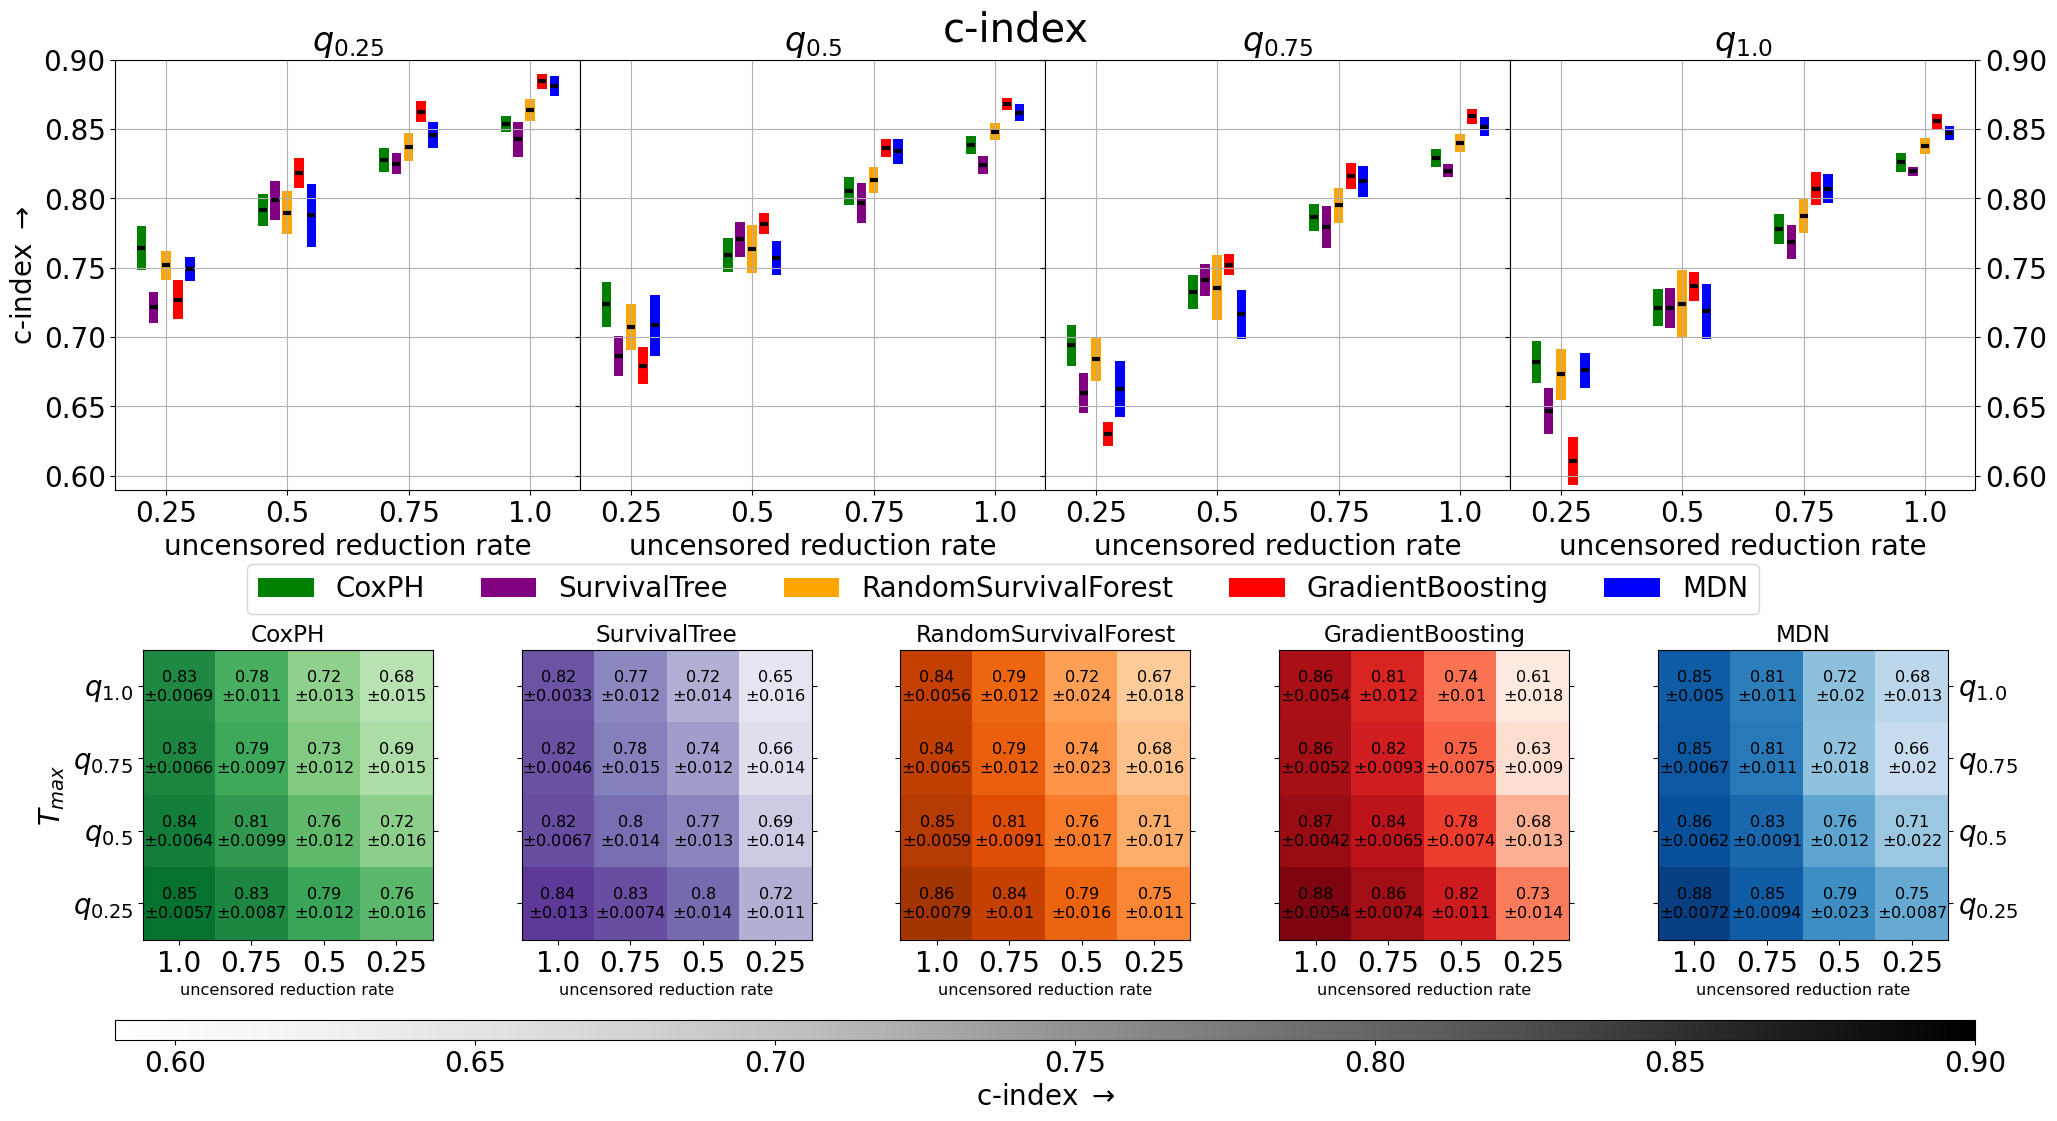

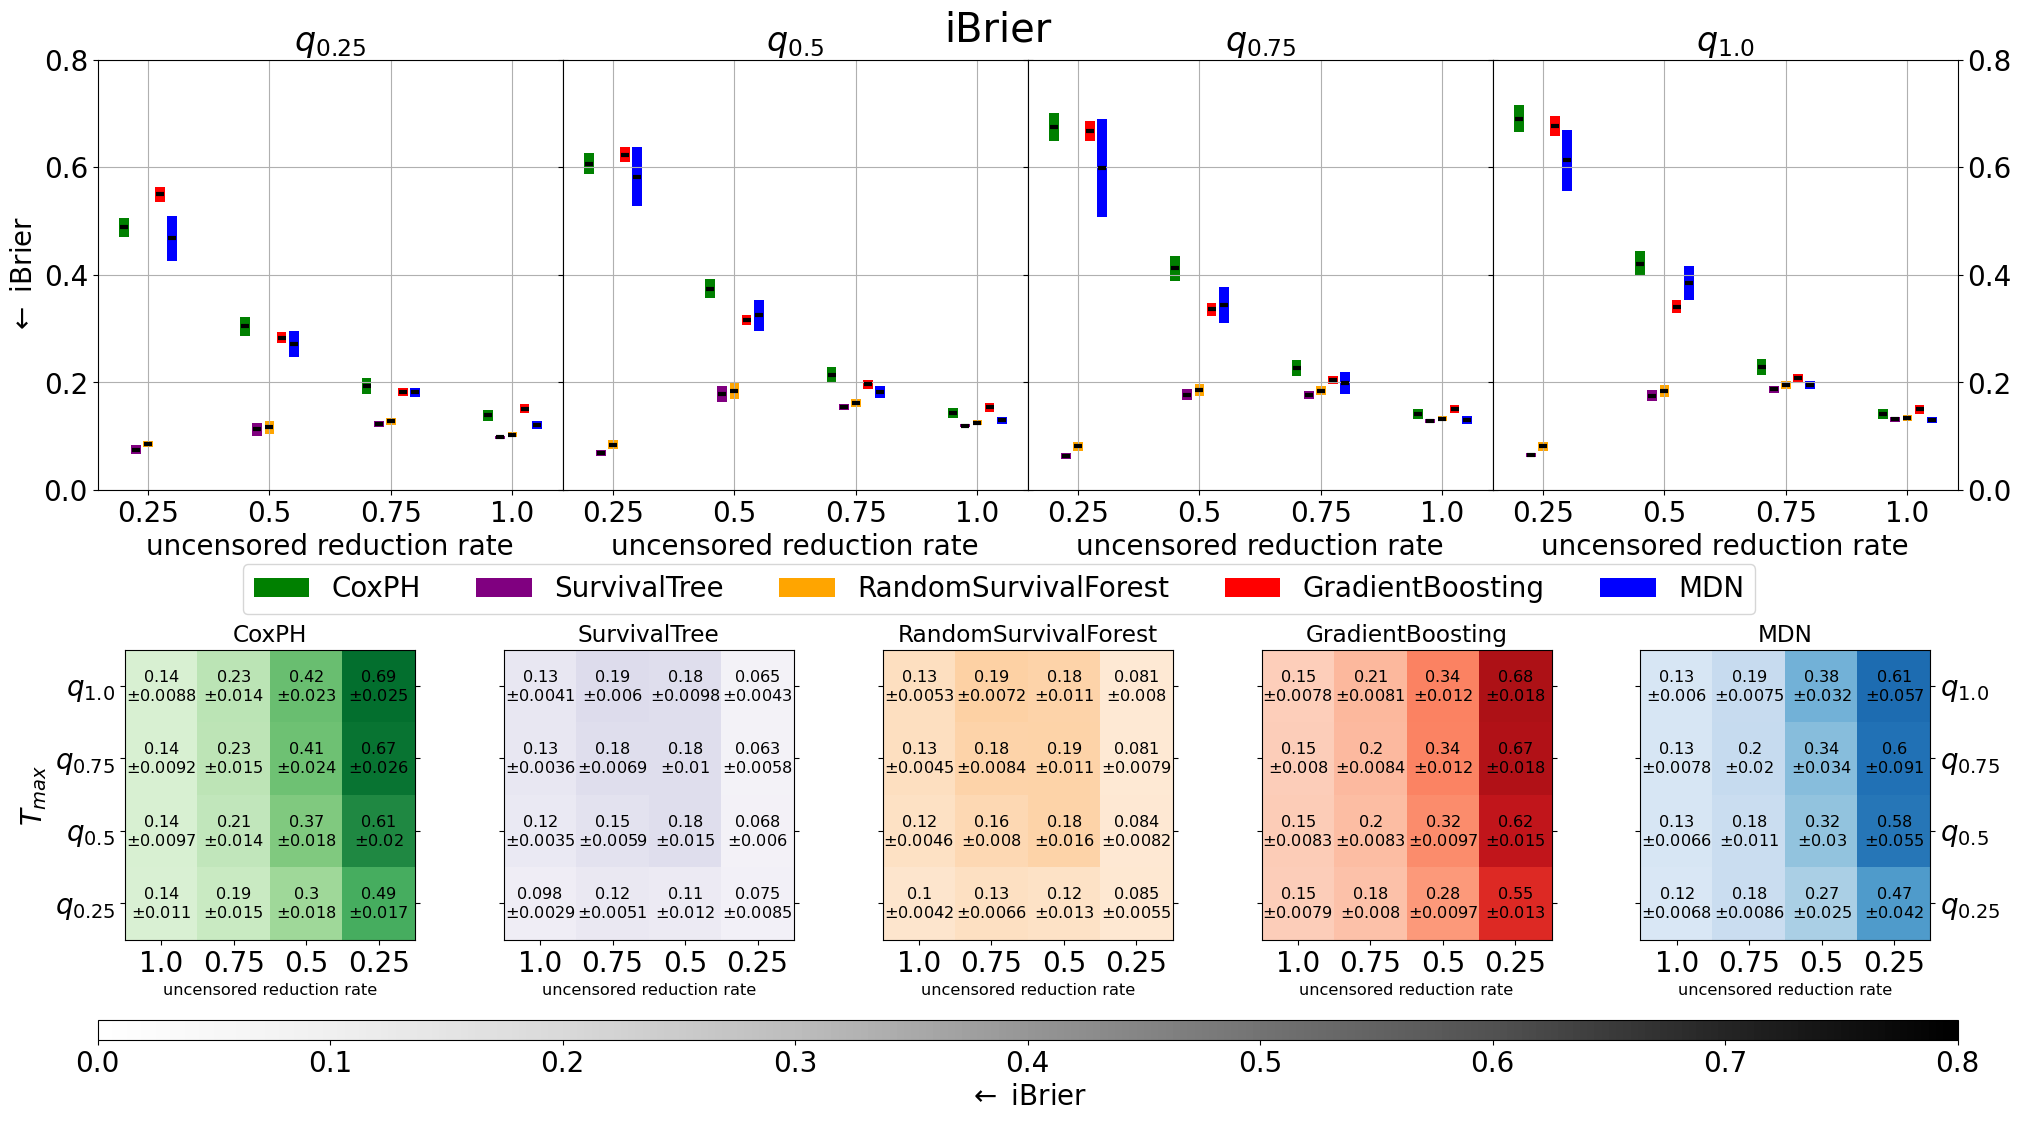

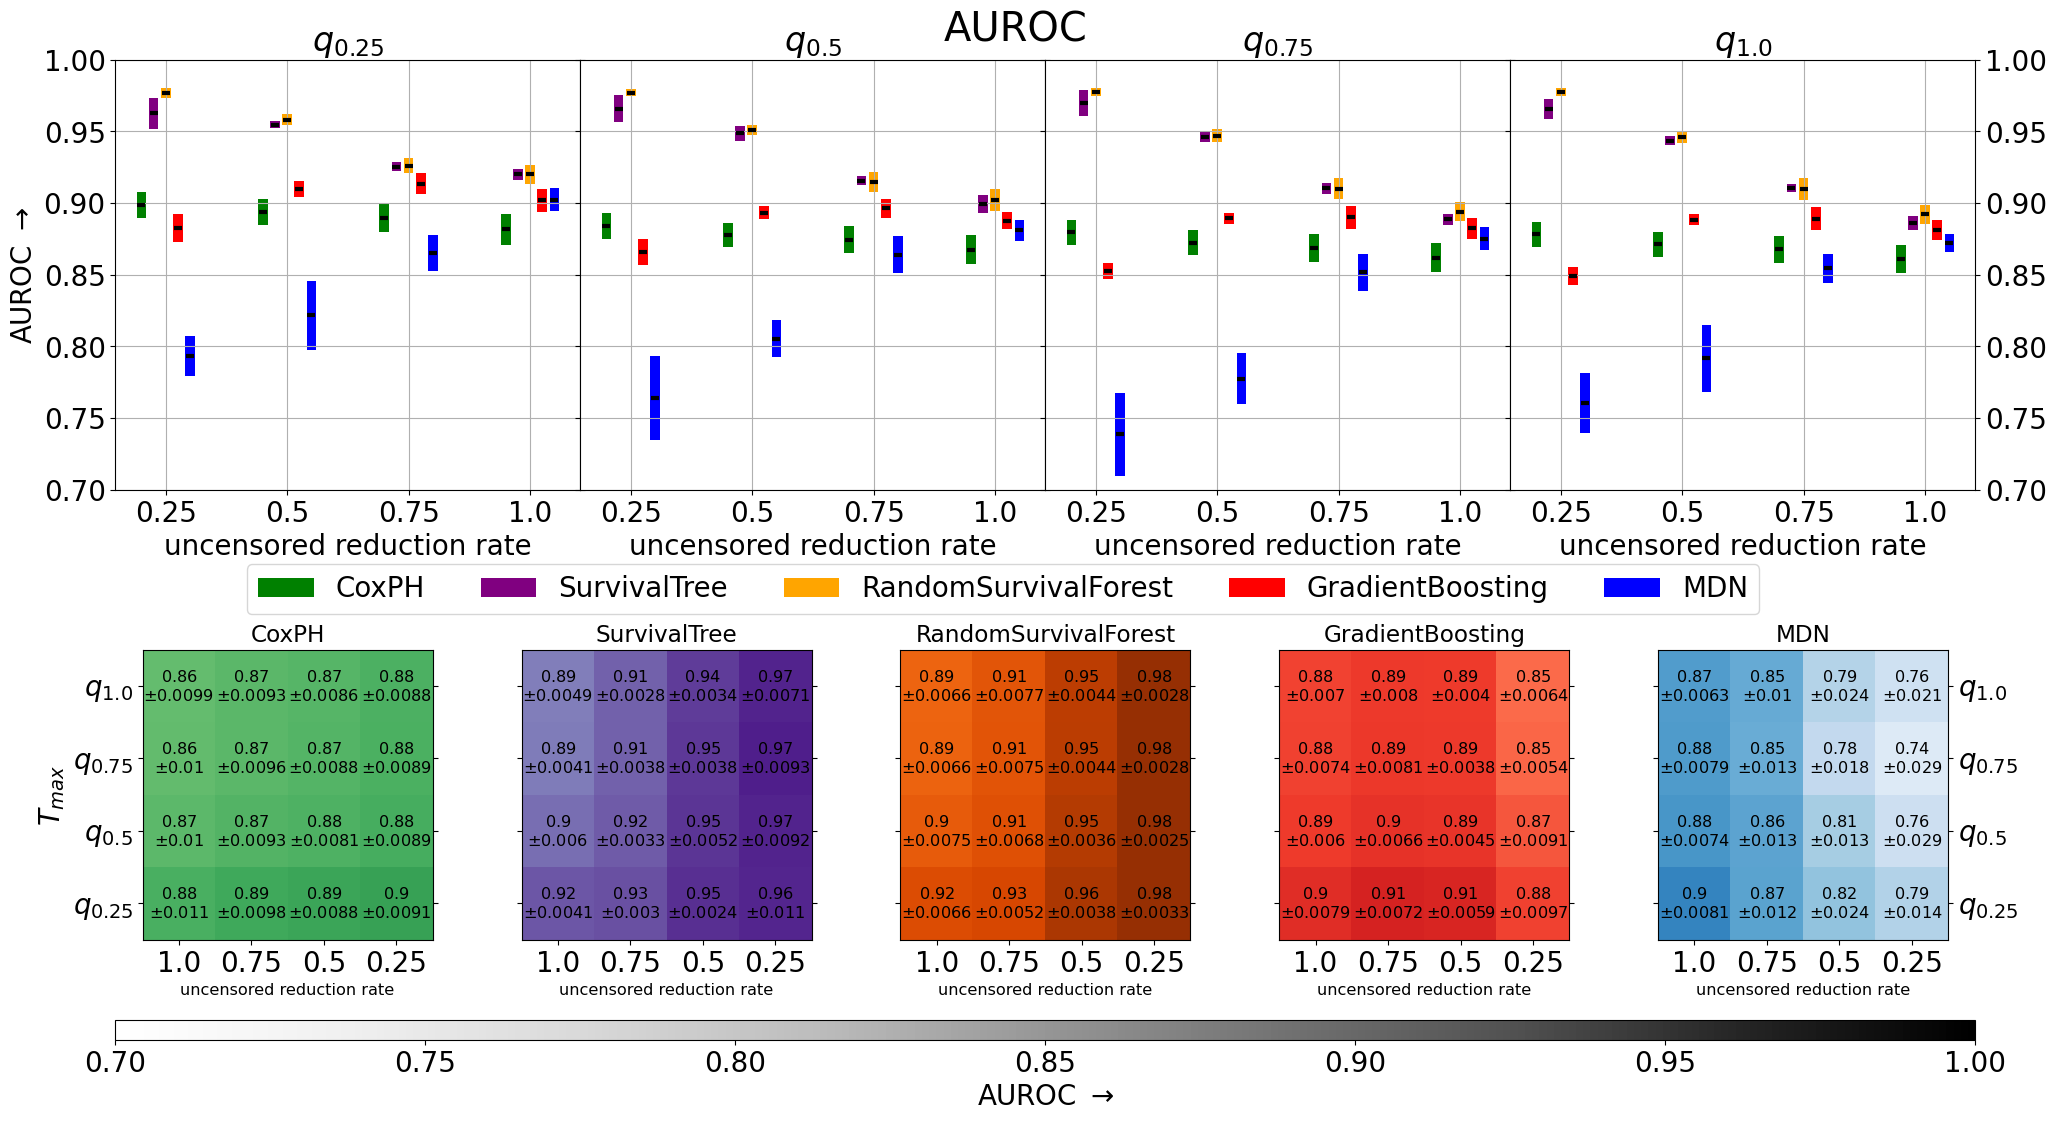

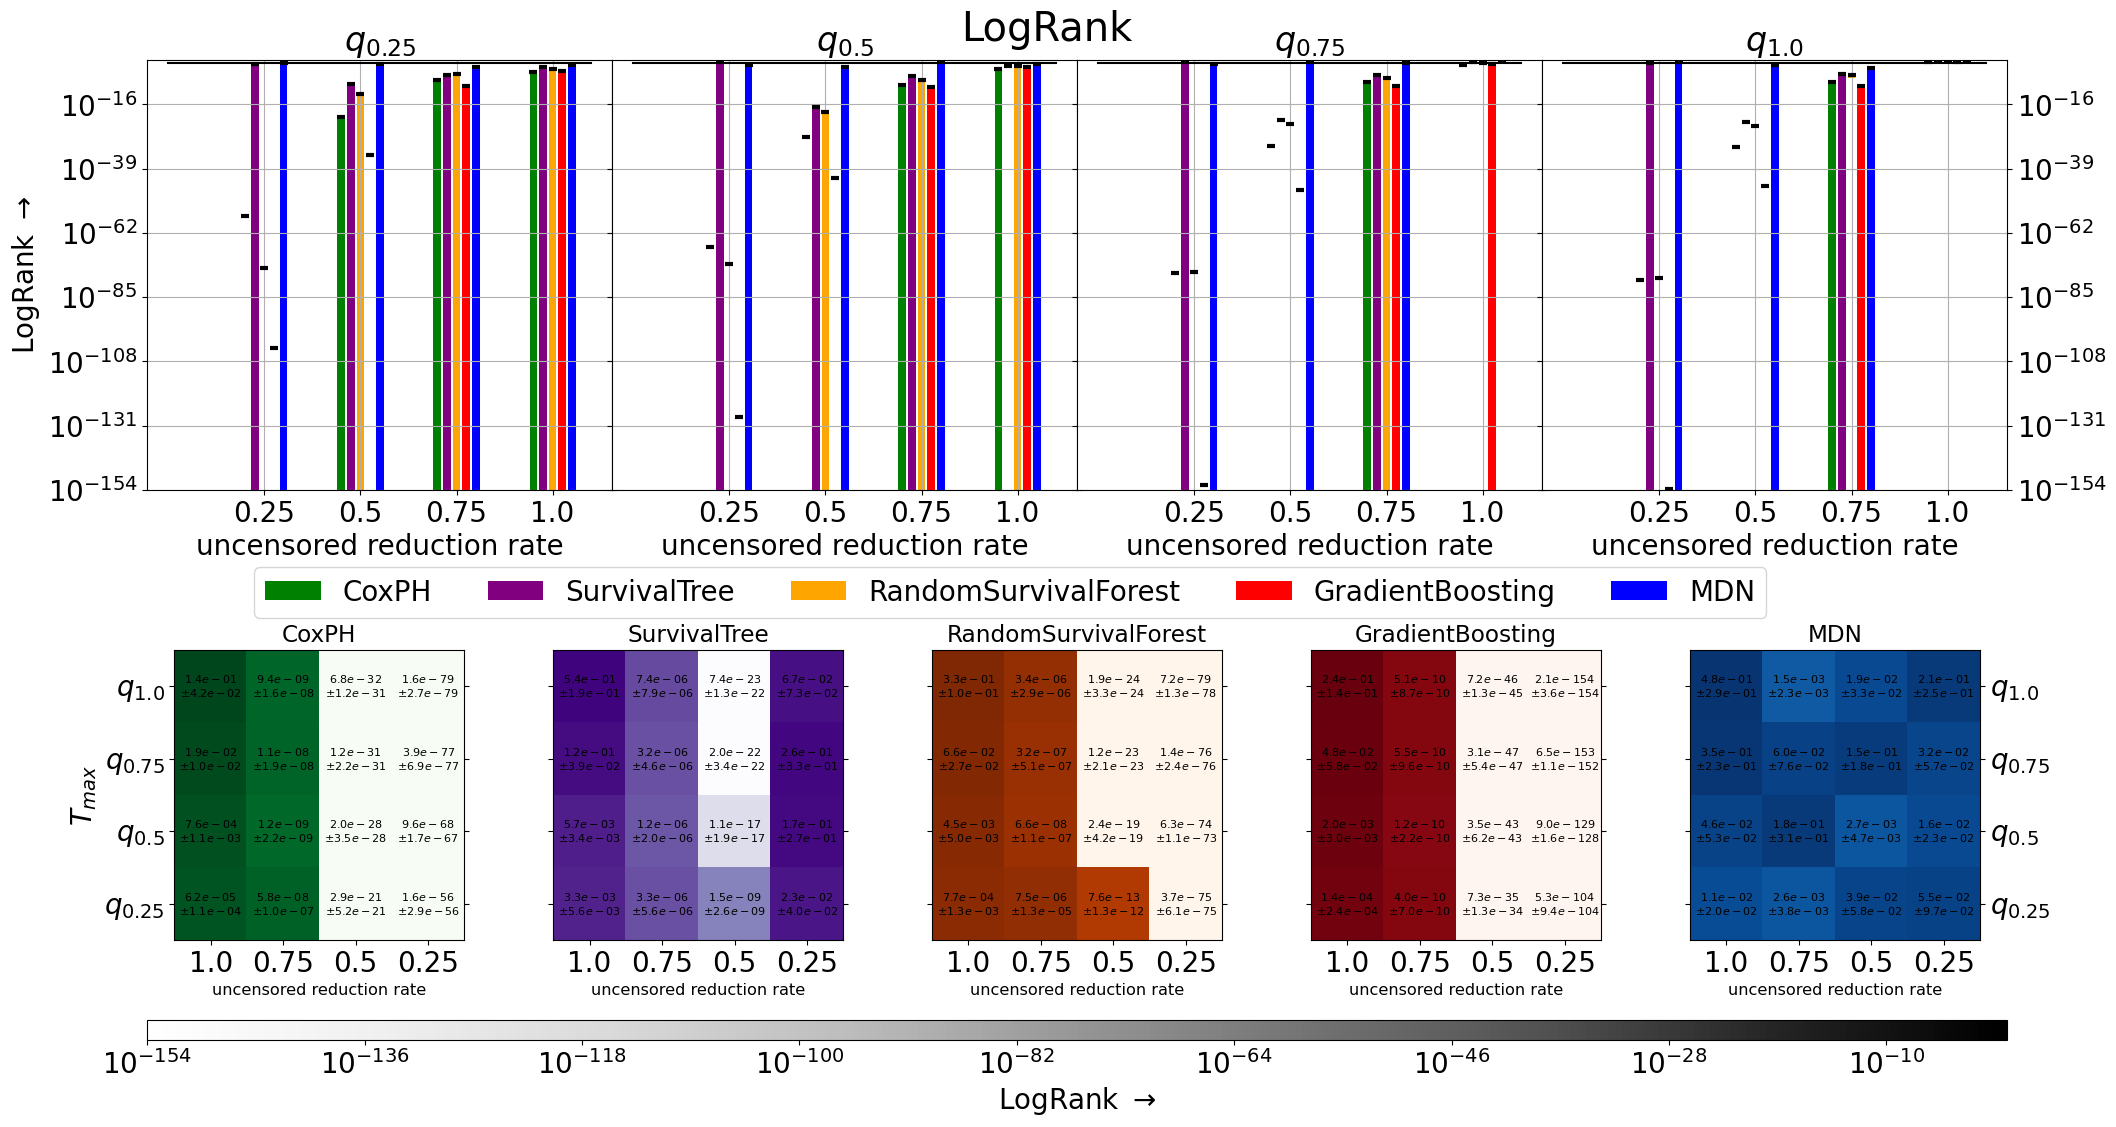

In [27]:
typ = "5Fold"
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
score_names = ["c-index","iBrier","AUROC","LogRank"]
ylims = [[0.59,0.9],[0.0,0.8],[0.7,1.0],[1e-154,1]]

for scr,scr_nm,ylim in zip(scores,score_names,ylims):
    #print(scr)
    fig = plt.figure(figsize=(20,10))

    # GridSpec for the barplots
    gs1 = GridSpec(1, 4, figure = fig, bottom=0.55, top=0.98, left=0.05, right=0.98, wspace = 0.0)
    bar_axs = []
    bar_locs = [0,1,2,3]
    for loc in bar_locs:
        bar_axs.append(fig.add_subplot(gs1[loc]))

    T_maxs = [0.25,0.5,0.75,1.0]
    for loc,T_max in zip(bar_locs,T_maxs):
        for _,row in sensitivity_analysis_[(sensitivity_analysis_.Type == typ) & (sensitivity_analysis_.Score == scr) & (sensitivity_analysis_.T_max == T_max)].iterrows():
            # Do the Japanese candles
            bar_axs[loc].plot(row["Ts"], row["means"], ls = "", marker = "_", markeredgewidth = 3, color = "black")
            bar_axs[loc].bar(row["Ts"], height = np.array(row["stds"])*2,width = 0.02, bottom = np.array(row["means"]) - np.array(row["stds"]), color = row.Color, label = row["Model"])

        if scr == "LogRank $\\rightarrow$":
            bar_axs[loc].set_yscale("log")
            bar_axs[loc].plot(np.linspace(0,1.1,100),0.05*np.ones(100),marker = "", color = "black")#, label = "LogRank success > 0.05")

        bar_axs[loc].set_xticks([0.25,0.5,0.75,1.0],["0.25","0.5","0.75","1.0"])
        bar_axs[loc].set_xlabel("uncensored reduction rate")
        if scr == "UnoC $\\rightarrow$":
            bar_axs[loc].set_ylabel("c-index $\\rightarrow$")
        else:
            bar_axs[loc].set_ylabel(scr)
        bar_axs[loc].yaxis.set_ticks_position('both')
        bar_axs[loc].tick_params(labelbottom=True, labeltop=False, labelleft = True, labelright = True)
        bar_axs[loc].set_ylim((ylim[0],ylim[1]))
        bar_axs[loc].grid()
        bar_axs[loc].set_title("$q_{" + f"{T_max}" +"}$")
        bar_axs[loc].label_outer()

    # GridSpec for the Heatmaps
    gs2 = GridSpec(1,5, figure = fig, bottom=0.1, top=0.39, left=0.05, right=0.98, wspace = 0.1)
    heat_axs = []
    heat_locs = [0,1,2,3,4]
    for loc in heat_locs:
        heat_axs.append(fig.add_subplot(gs2[loc]))
    # GridSpec for the Colorbar
    gs3 = GridSpec(1,1, figure = fig, bottom=0.00, top=0.02, left=0.05, right=0.98, wspace = 0.1)
    cbar_ax = fig.add_subplot(gs3[0])

    models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
    for loc,model in zip(heat_locs,models):
        for _,row in sensitivity_analysis_heatmap[(sensitivity_analysis_heatmap.Model == model) & (sensitivity_analysis_heatmap.Type == typ) & (sensitivity_analysis_heatmap.Score == scr)].iterrows():
            # Normalization
            if scr == "LogRank $\\rightarrow$":
                norm = LogNorm(vmin = ylim[0], vmax = ylim[1])
            else:
                norm = Normalize(vmin = ylim[0], vmax = ylim[1])

            # Heatmap
            im = heat_axs[loc].imshow(np.array(row.means).reshape(4,4), norm = norm, cmap = f"{row.Color}s")

            # Colorbar
            if loc == heat_locs[-1]:
                cbar = fig.colorbar(ScalarMappable(cmap = "Greys", norm = norm), cax = cbar_ax, orientation='horizontal')
                # Colorbar labels
                if scr == "UnoC $\\rightarrow$":
                    cbar.set_label("c-index $\\rightarrow$")
                else:
                    cbar.set_label(scr)

            # Ticks & Tick labels
            heat_axs[loc].set_xticks(np.arange(np.array(row.means).reshape(4,4).shape[1]), labels=[1.0,0.75,0.5,0.25])
            heat_axs[loc].set_xlabel("uncensored reduction rate", fontsize = "xx-small")
            heat_axs[loc].set_yticks(np.arange(np.array(row.means).reshape(4,4).shape[0]), labels=["$q_{1.0}$","$q_{0.75}$","$q_{0.5}$","$q_{0.25}$"])
            heat_axs[loc].yaxis.set_ticks_position('both')
            heat_axs[loc].tick_params(labelbottom=True, labeltop=False, labelleft = True, labelright = True)
            heat_axs[loc].set_ylabel("$T_{max}$")
            heat_axs[loc].label_outer()

            heat_axs[loc].set_title(model, fontsize = "small")



            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    clr = "black"
                    if scr == "LogRank $\\rightarrow$":
                        #if np.array(row.means).reshape(4,4)[i,j] < 0.05:
                        #    clr = "red"
                        mean = "{:.1e}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.1e}".format(np.array(row.stds).reshape(4,4)[i,j])
                        text_size = 8
                    else:
                        mean = "{:.2}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.2}".format(np.array(row.stds).reshape(4,4)[i,j])
                        text_size = "xx-small"
                    if typ == "5Fold":
                        scr_str = f"${mean}$\n$\pm {std}$"
                    else:
                        scr_str = f"{mean}"
                    text = heat_axs[loc].text(j, i, scr_str,ha="center", va="center", size = text_size, color = clr)

    handles, labels = bar_axs[bar_locs[-1]].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.12,0.452),ncol = 5)
    fig.suptitle(scr_nm, y = 1.03, fontsize = "x-large")
    plt.show()

#### Hold-out

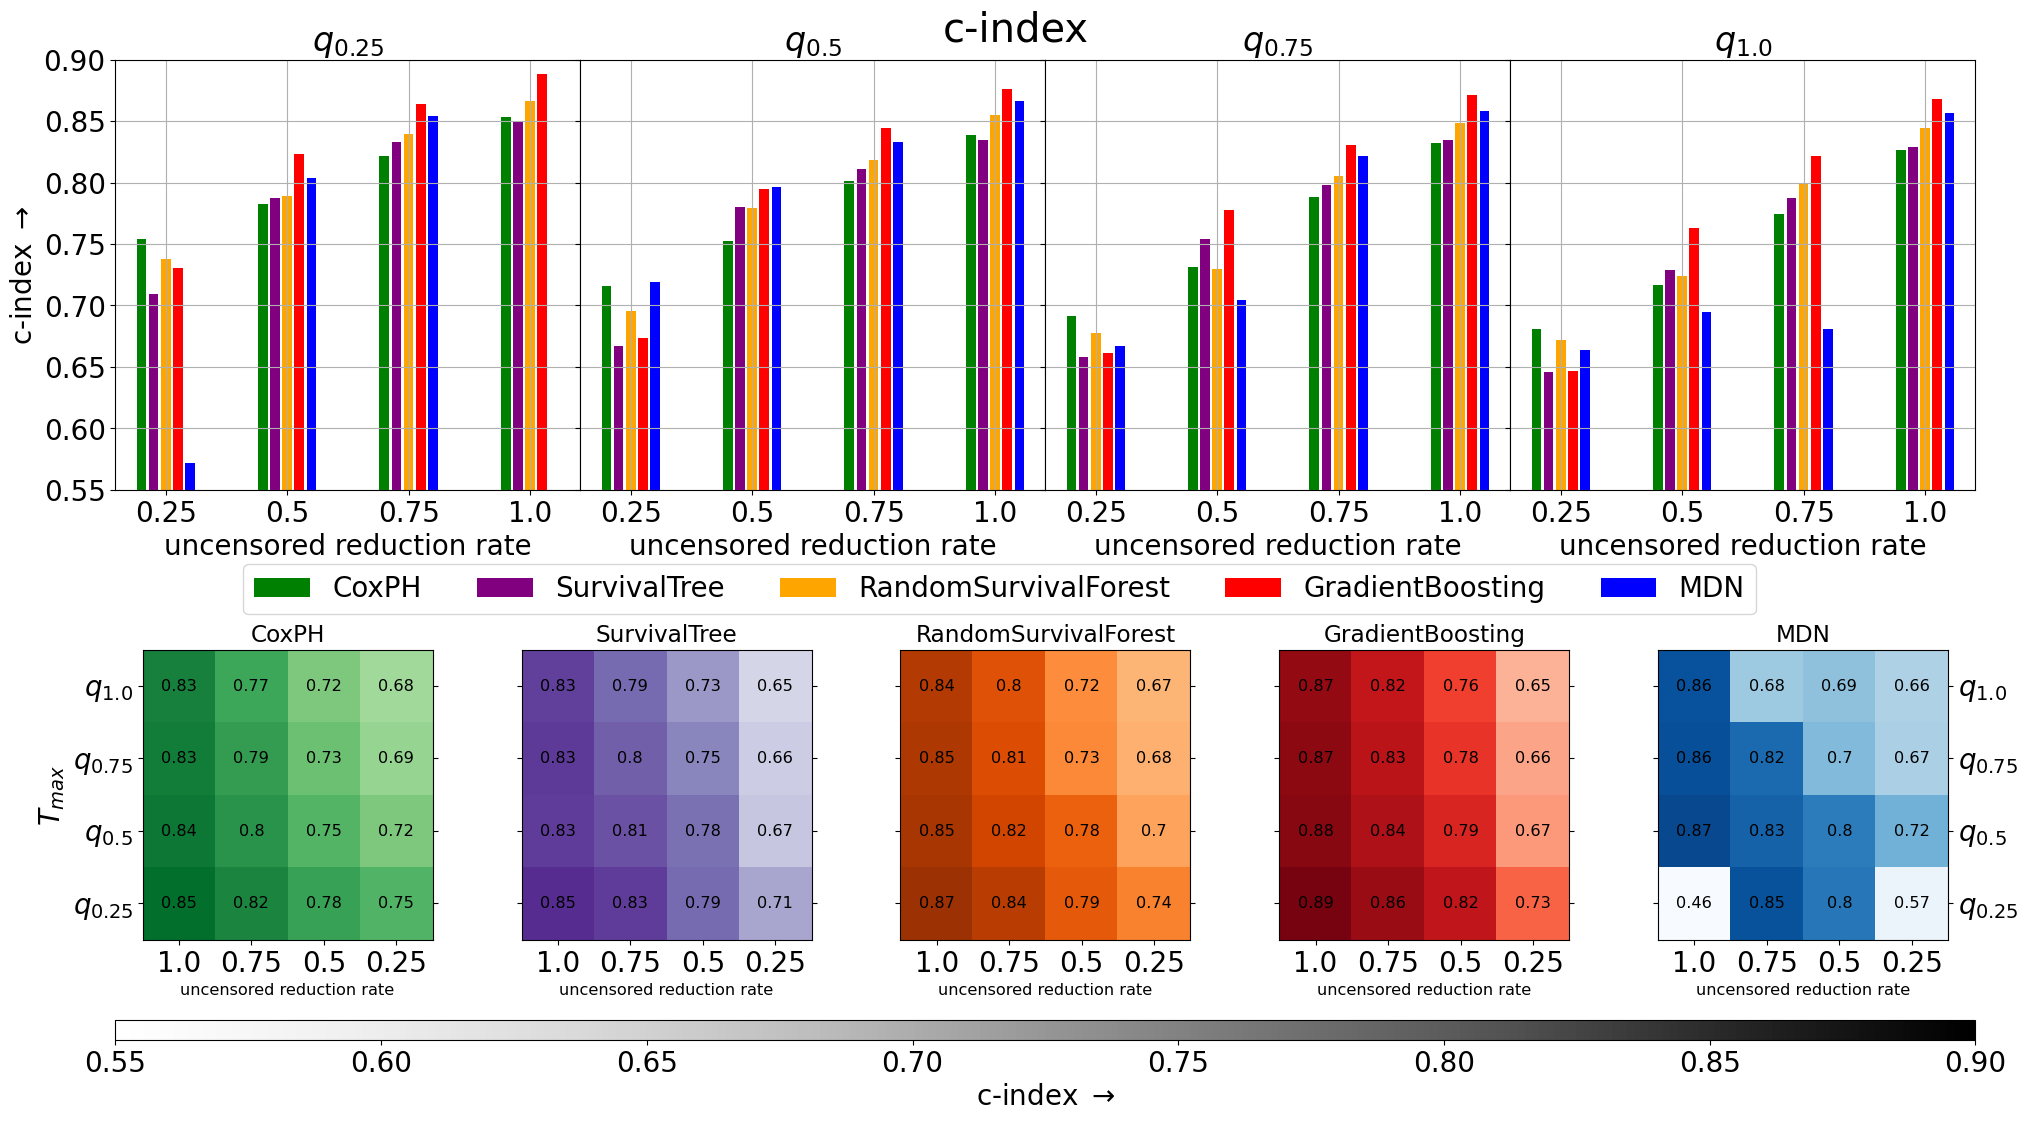

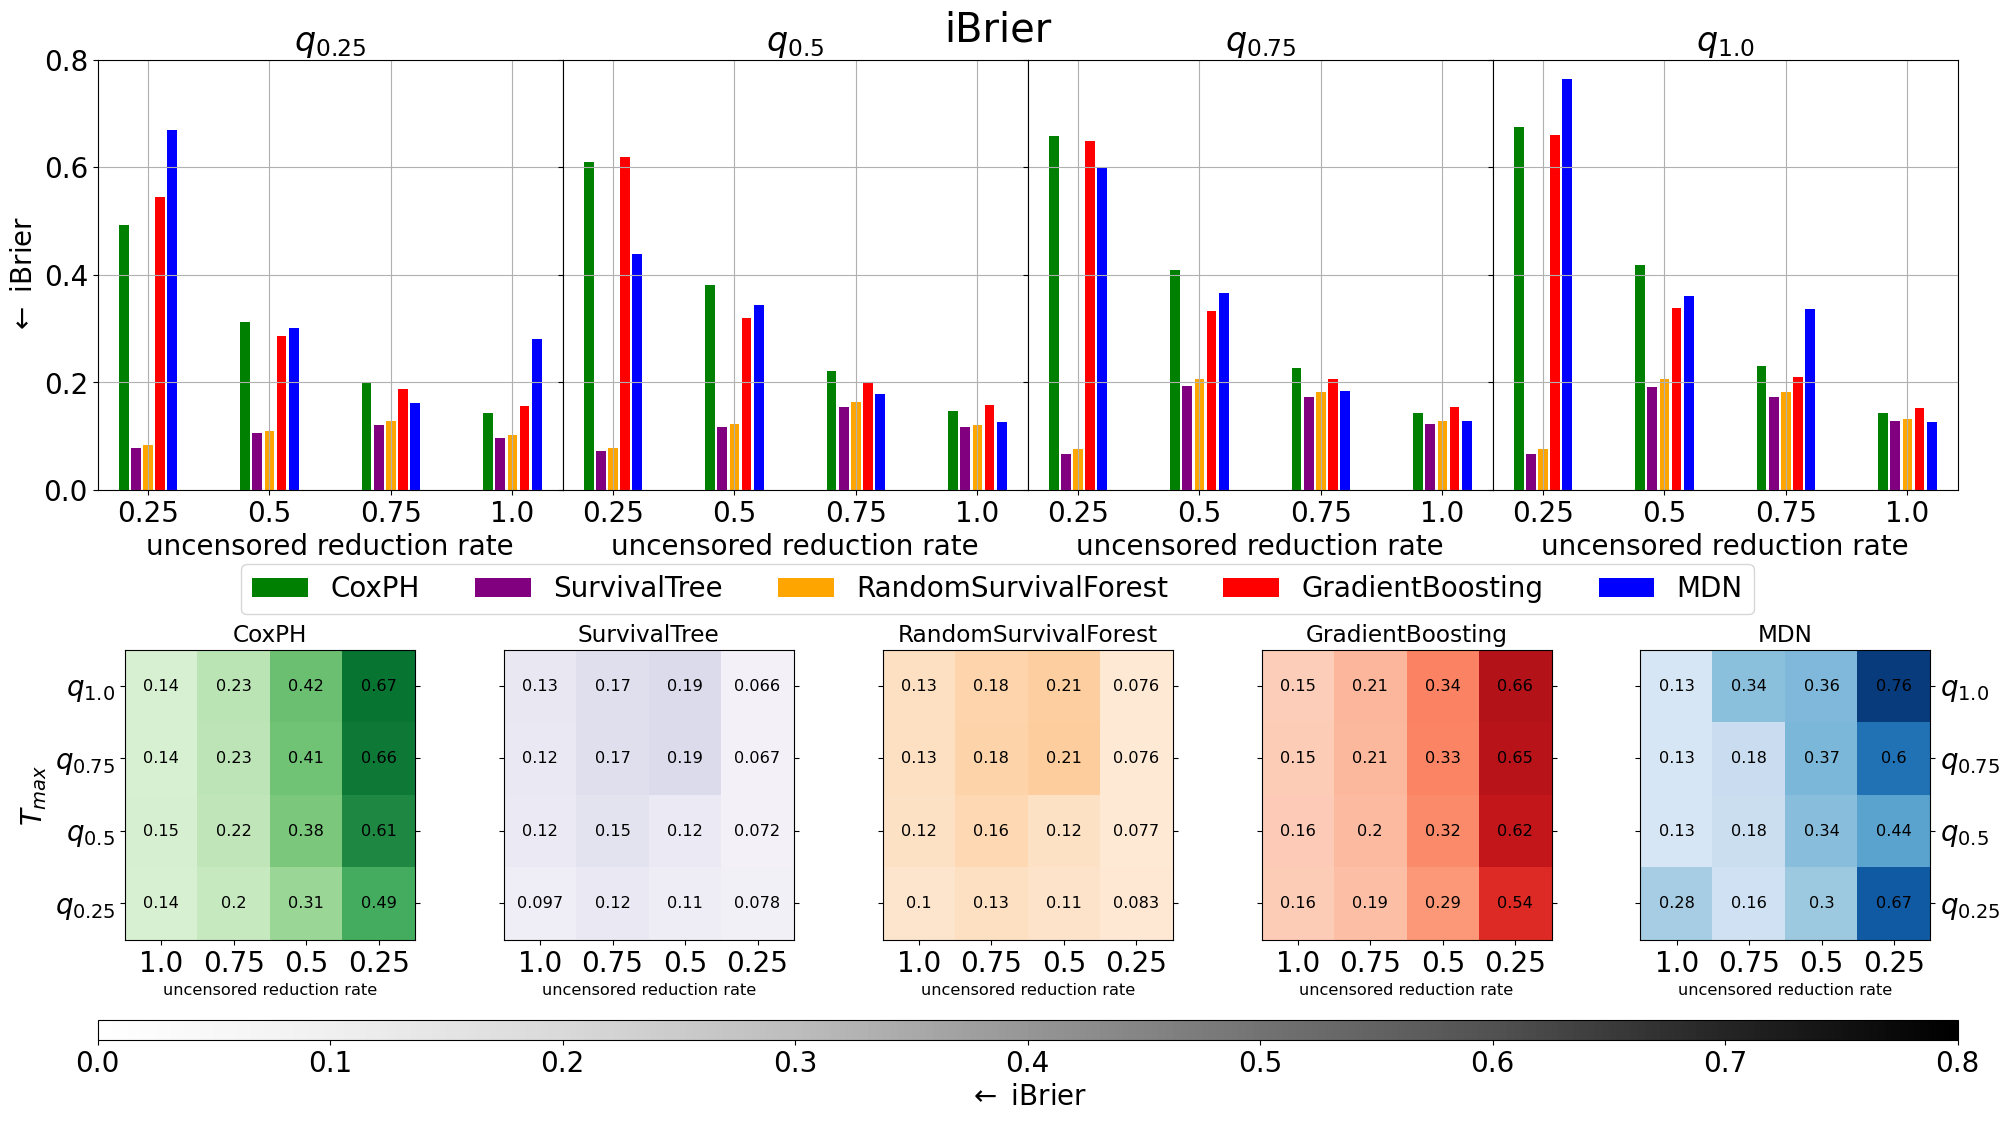

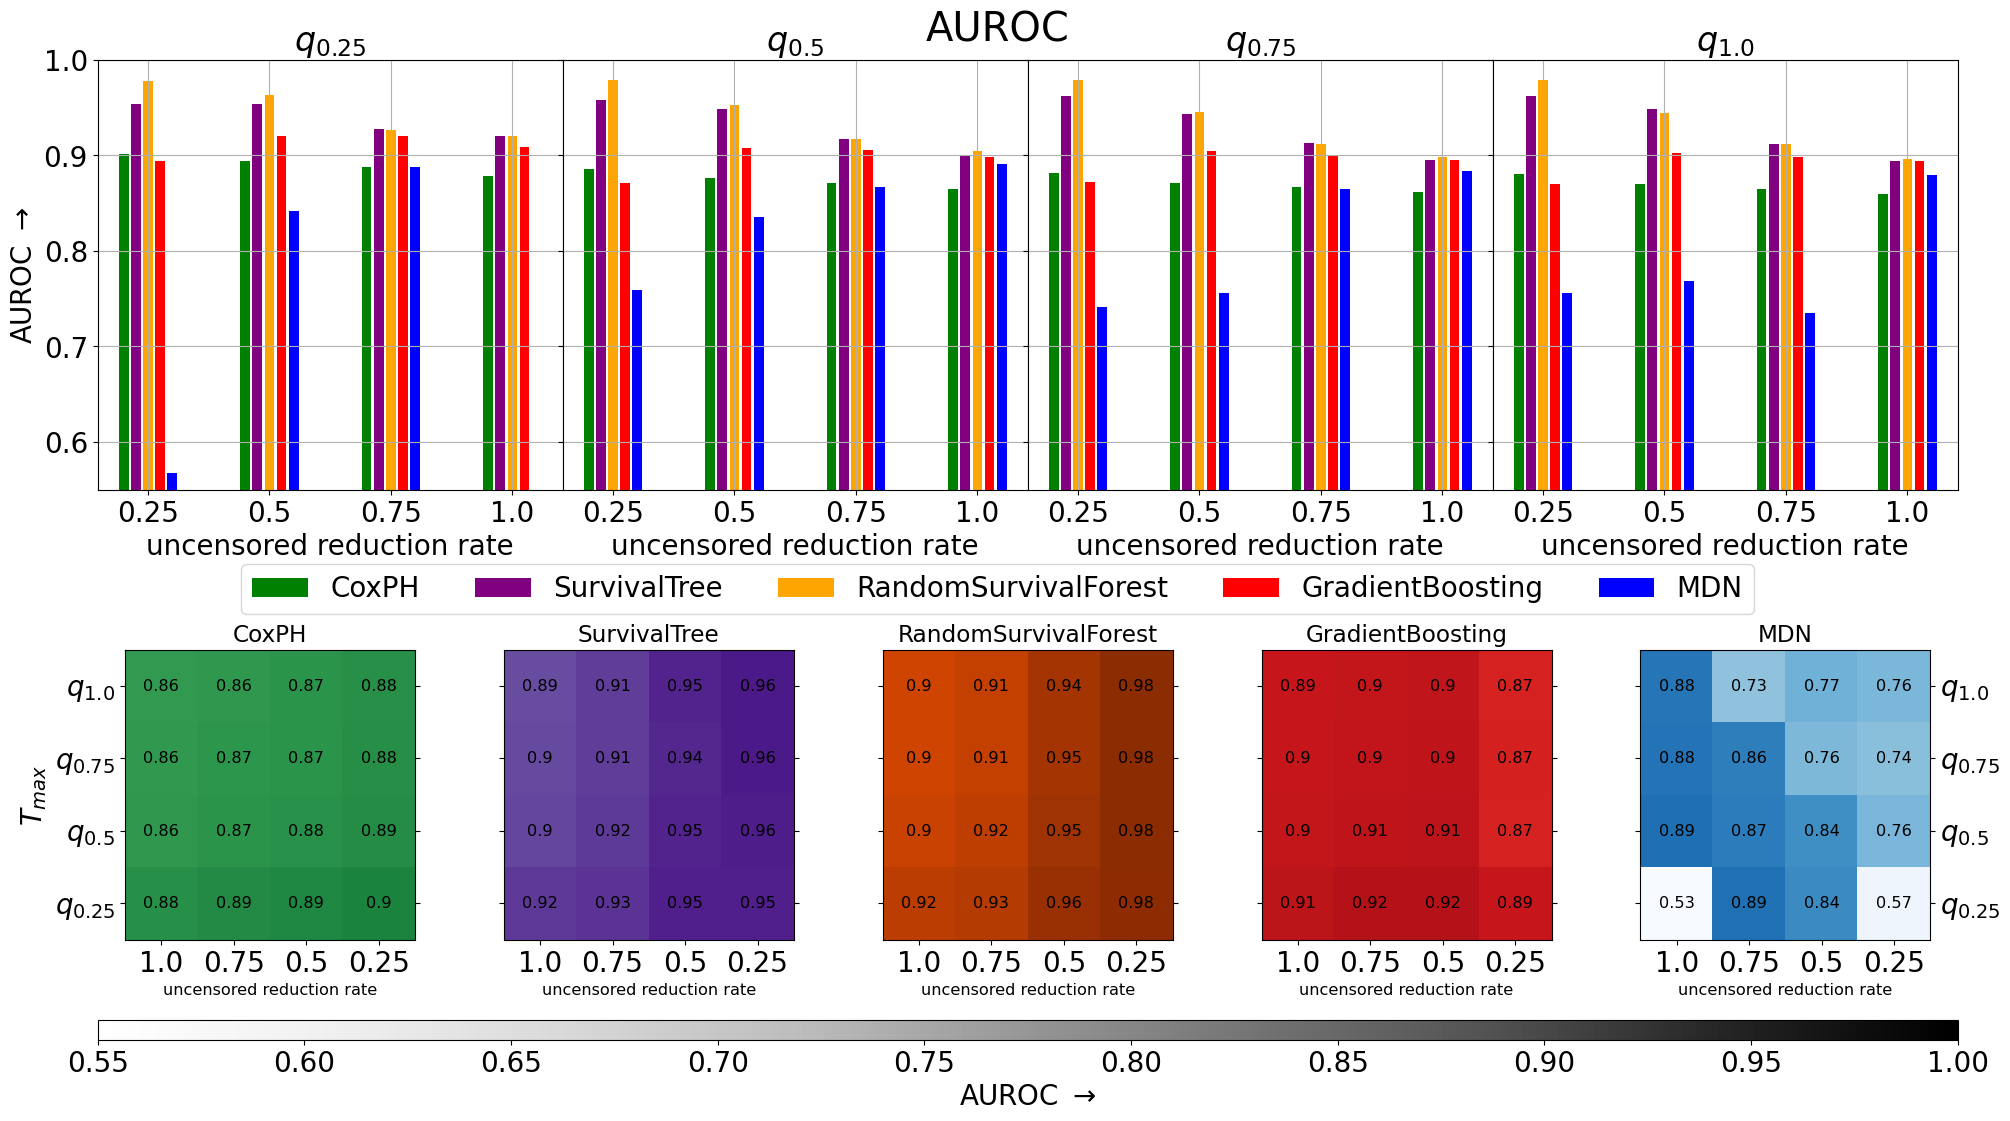

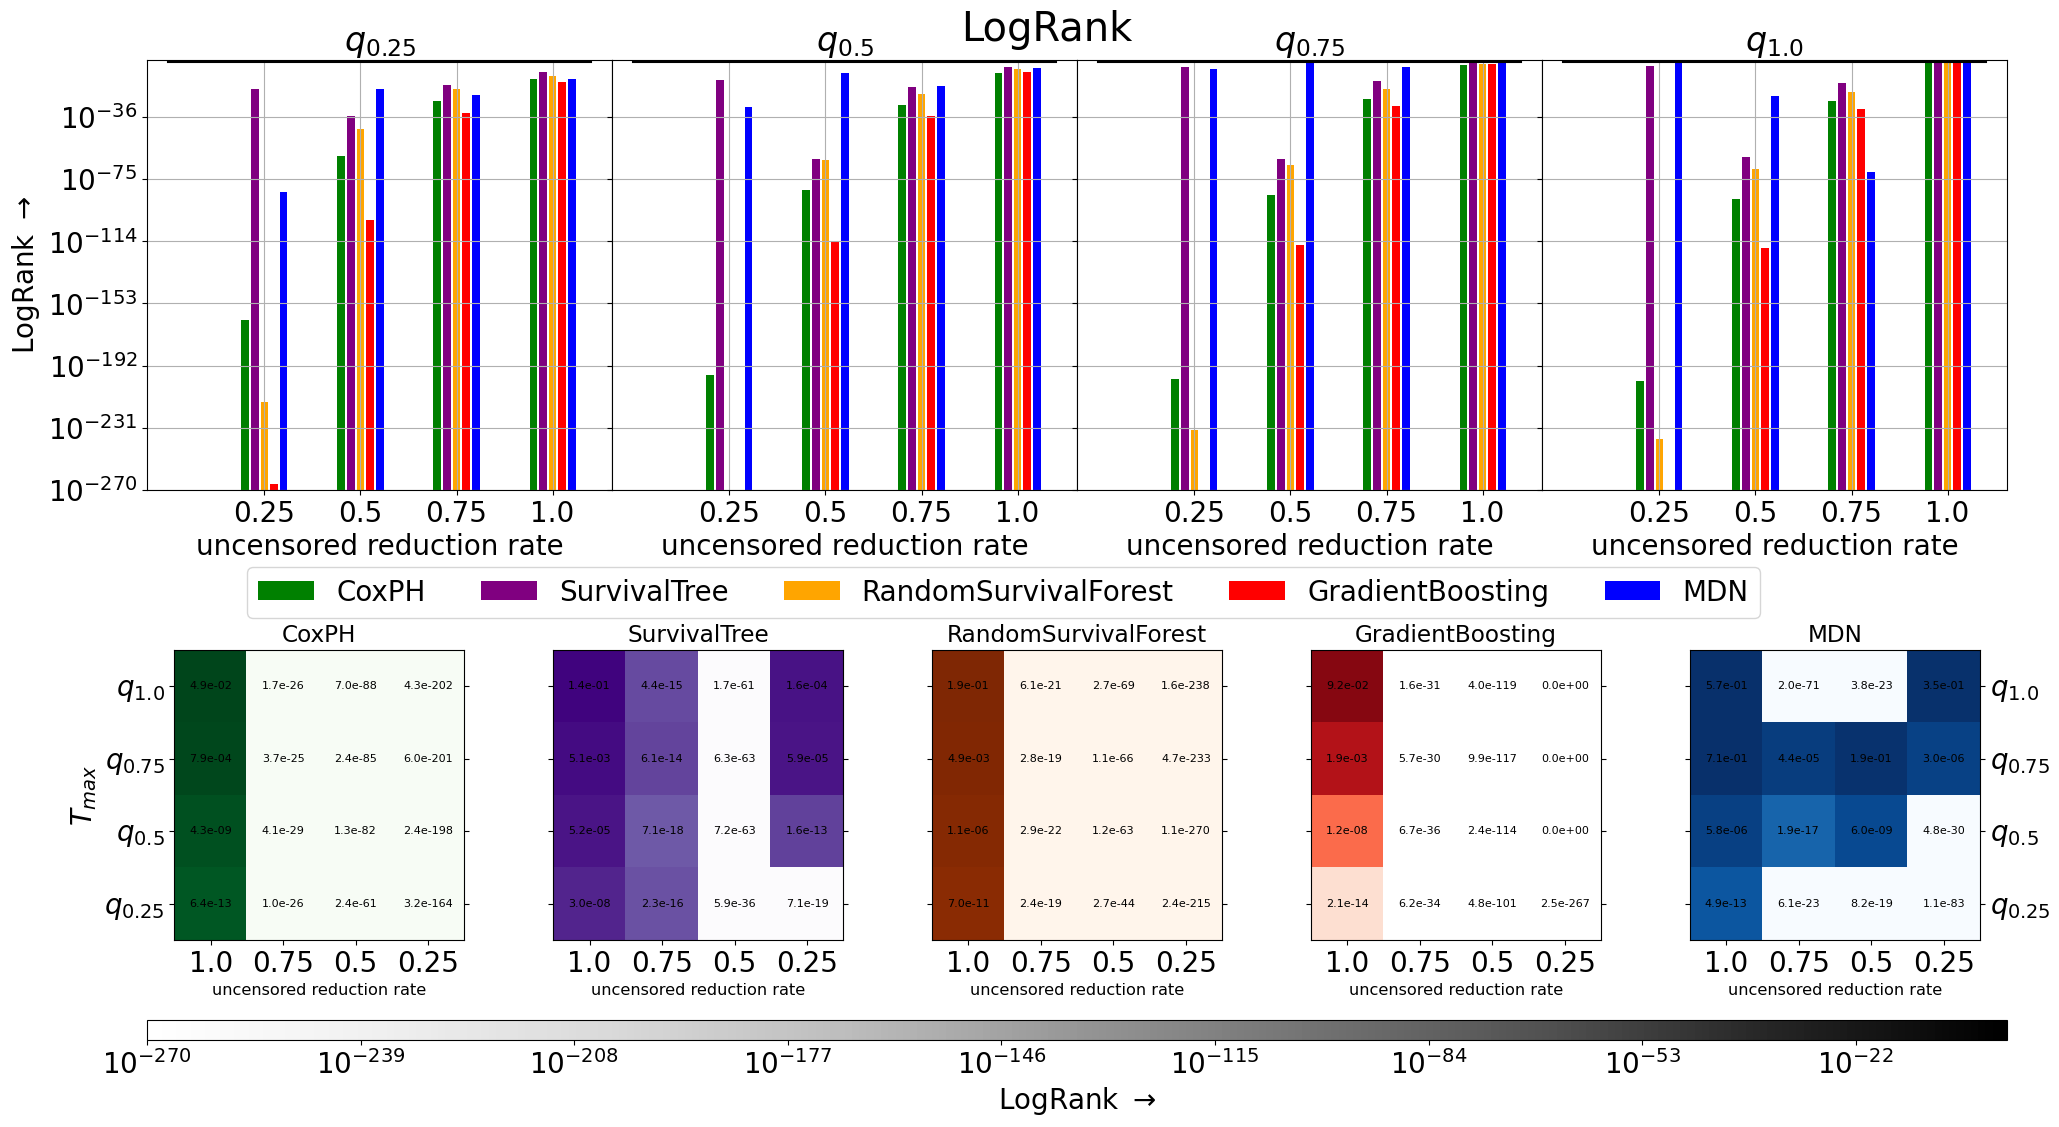

In [28]:
typ = "Hold-out"
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
score_names = ["c-index","iBrier","AUROC","LogRank"]
ylims = [[0.55,0.9],[0.0,0.8],[0.55,1.0],[1e-270,1]]

for scr,scr_nm,ylim in zip(scores,score_names,ylims):
    #print(scr)
    fig = plt.figure(figsize=(20,10))

    # GridSpec for the barplots
    gs1 = GridSpec(1, 4, figure = fig, bottom=0.55, top=0.98, left=0.05, right=0.98, wspace = 0.0)
    bar_axs = []
    bar_locs = [0,1,2,3]
    for loc in bar_locs:
        bar_axs.append(fig.add_subplot(gs1[loc]))

    T_maxs = [0.25,0.5,0.75,1.0]
    for loc,T_max in zip(bar_locs,T_maxs):
        for _,row in sensitivity_analysis_[(sensitivity_analysis_.Type == typ) & (sensitivity_analysis_.Score == scr) & (sensitivity_analysis_.T_max == T_max)].iterrows():
            eb = bar_axs[loc].bar(row["Ts"], height = row["means"],width = 0.02, yerr = row["stds"], color = row.Color, label = row["Model"])

        if scr == "LogRank $\\rightarrow$":
            bar_axs[loc].set_yscale("log")
            bar_axs[loc].plot(np.linspace(0,1.1,100),0.05*np.ones(100),marker = "", color = "black")#, label = "LogRank success > 0.05")

        bar_axs[loc].set_xticks([0.25,0.5,0.75,1.0],["0.25","0.5","0.75","1.0"])
        bar_axs[loc].set_xlabel("uncensored reduction rate")
        if scr == "UnoC $\\rightarrow$":
            bar_axs[loc].set_ylabel("c-index $\\rightarrow$")
        else:
            bar_axs[loc].set_ylabel(scr)
        bar_axs[loc].set_ylim((ylim[0],ylim[1]))
        bar_axs[loc].grid()
        bar_axs[loc].set_title("$q_{" + f"{T_max}" +"}$")
        bar_axs[loc].label_outer()

    # GridSpec for the Heatmaps
    gs2 = GridSpec(1,5, figure = fig, bottom=0.1, top=0.39, left=0.05, right=0.98, wspace = 0.1)
    heat_axs = []
    heat_locs = [0,1,2,3,4]
    for loc in heat_locs:
        heat_axs.append(fig.add_subplot(gs2[loc]))
    # GridSpec for the Colorbar
    gs3 = GridSpec(1,1, figure = fig, bottom=0.00, top=0.02, left=0.05, right=0.98, wspace = 0.1)
    cbar_ax = fig.add_subplot(gs3[0])

    models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
    for loc,model in zip(heat_locs,models):
        for _,row in sensitivity_analysis_heatmap[(sensitivity_analysis_heatmap.Model == model) & (sensitivity_analysis_heatmap.Type == typ) & (sensitivity_analysis_heatmap.Score == scr)].iterrows():
            # Normalization
            if scr == "LogRank $\\rightarrow$":
                norm = LogNorm(vmin = ylim[0], vmax = ylim[1])
            else:
                norm = Normalize(vmin = ylim[0], vmax = ylim[1])

            # Heatmap
            im = heat_axs[loc].imshow(np.array(row.means).reshape(4,4), norm = norm, cmap = f"{row.Color}s")

            # Colorbar
            if loc == heat_locs[-1]:
                cbar = fig.colorbar(ScalarMappable(cmap = "Greys", norm = norm), cax = cbar_ax, orientation='horizontal')
                # Colorbar labels
                if scr == "UnoC $\\rightarrow$":
                    cbar.set_label("c-index $\\rightarrow$")
                else:
                    cbar.set_label(scr)

            # Ticks & Tick labels
            heat_axs[loc].set_xticks(np.arange(np.array(row.means).reshape(4,4).shape[1]), labels=[1.0,0.75,0.5,0.25])
            heat_axs[loc].set_xlabel("uncensored reduction rate", fontsize = "xx-small")
            heat_axs[loc].set_yticks(np.arange(np.array(row.means).reshape(4,4).shape[0]), labels=["$q_{1.0}$","$q_{0.75}$","$q_{0.5}$","$q_{0.25}$"])
            heat_axs[loc].yaxis.set_ticks_position('both')
            heat_axs[loc].tick_params(labelbottom=True, labeltop=False, labelleft = True, labelright = True)
            heat_axs[loc].set_ylabel("$T_{max}$")
            heat_axs[loc].label_outer()

            heat_axs[loc].set_title(model, fontsize = "small")

            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    clr = "black"
                    #clr = ScalarMappable(cmap = f"Greys_r", norm = norm).to_rgba(np.array(row.means).reshape(4,4)[i,j])
                    if scr == "LogRank $\\rightarrow$":
                        #if np.array(row.means).reshape(4,4)[i,j] < 0.05:
                        #    clr = "red"
                        mean = "{:.1e}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.1e}".format(np.array(row.stds).reshape(4,4)[i,j])
                        text_size = 8
                    else:
                        mean = "{:.2}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.2}".format(float(np.array(row.stds).reshape(4,4)[i,j]))
                        text_size = "xx-small"
                    if typ == "5Fold":
                        scr_str = f"${mean}$\n$\pm {std}$"
                    else:
                        scr_str = f"{mean}"
                    text = heat_axs[loc].text(j, i, scr_str,ha="center", va="center", size = text_size, color = clr)

    handles, labels = bar_axs[bar_locs[-1]].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.12,0.452),ncol = 5)
    fig.suptitle(scr_nm, y = 1.03, fontsize = "x-large")
    plt.show()

### Correlation

In [61]:
from scipy.stats import spearmanr

In [62]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["green","purple","orange","red","blue"]
markers = ["o","v","s","D","*"]
opts = [True]
typs = ["5Fold","Hold-out"]
trials = list(product(models,opts,typs))

sensitivity_analysis_corr  = {"Model":[],
                              "Type":[],
                              "corrs":[],
                              "pvals":[]}

for trial in trials:
    sensitivity_analysis_corr["Model"].append(trial[0])
    sensitivity_analysis_corr["Type"].append(trial[2])

    # Baseline
    baseline = []
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1) & (results_table["Uncensored_Reduction"][i] == 1):
            if trial[2] == "5Fold":
                baseline.append(results_table[trial[2]]["UnoC"]["mean"][i])
                baseline.append(results_table[trial[2]]["iBrier"]["mean"][i])
                baseline.append(results_table[trial[2]]["AUROC"]["mean"][i])
                baseline.append(results_table[trial[2]]["LogRank"]["mean"][i])
            else:
                baseline.append(results_table[trial[2]]["UnoC"][i])
                baseline.append(results_table[trial[2]]["iBrier"][i])
                baseline.append(results_table[trial[2]]["AUROC"][i])
                baseline.append(results_table[trial[2]]["LogRank"][i])
    baseline = np.array(baseline)

    ts = []
    corrs = []
    pvals = []
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]):
            if trial[2] == "5Fold":
                current = []
                current.append(results_table[trial[2]]["UnoC"]["mean"][i])
                current.append(results_table[trial[2]]["iBrier"]["mean"][i])
                current.append(results_table[trial[2]]["AUROC"]["mean"][i])
                current.append(results_table[trial[2]]["LogRank"]["mean"][i])
                current = np.array(current)
            else:
                current = []
                current.append(results_table[trial[2]]["UnoC"][i])
                current.append(results_table[trial[2]]["iBrier"][i])
                current.append(results_table[trial[2]]["AUROC"][i])
                current.append(results_table[trial[2]]["LogRank"][i])
                current = np.array(current)
            spearman_result = spearmanr(current,baseline)
            corrs.append(spearman_result.correlation)
            pvals.append(spearman_result.pvalue)
    sensitivity_analysis_corr["corrs"].append(corrs)
    sensitivity_analysis_corr["pvals"].append(pvals)

sensitivity_analysis_corr = pd.DataFrame.from_dict(sensitivity_analysis_corr)

#### Correlation Plots

CoxPH


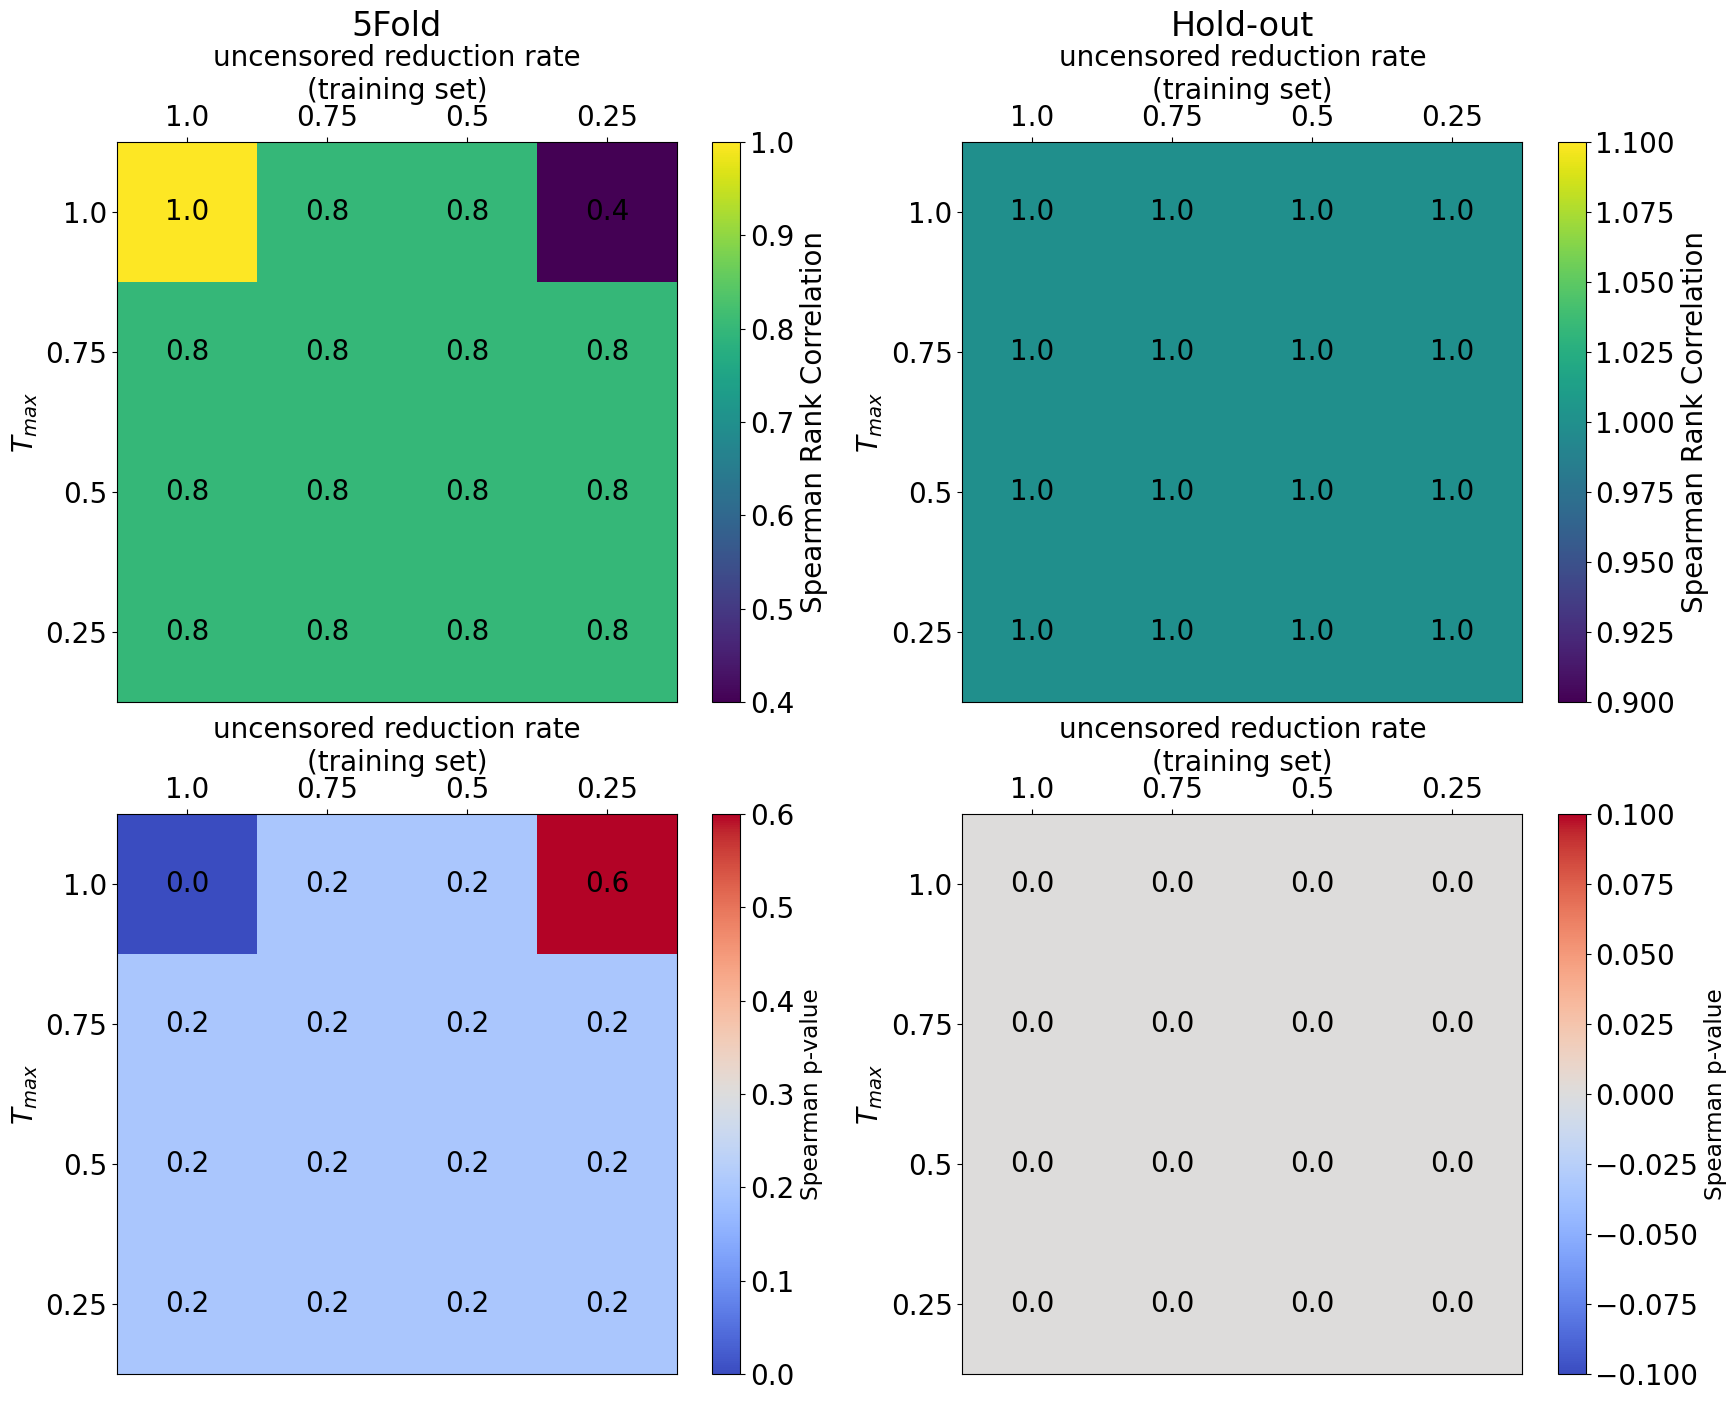

SurvivalTree


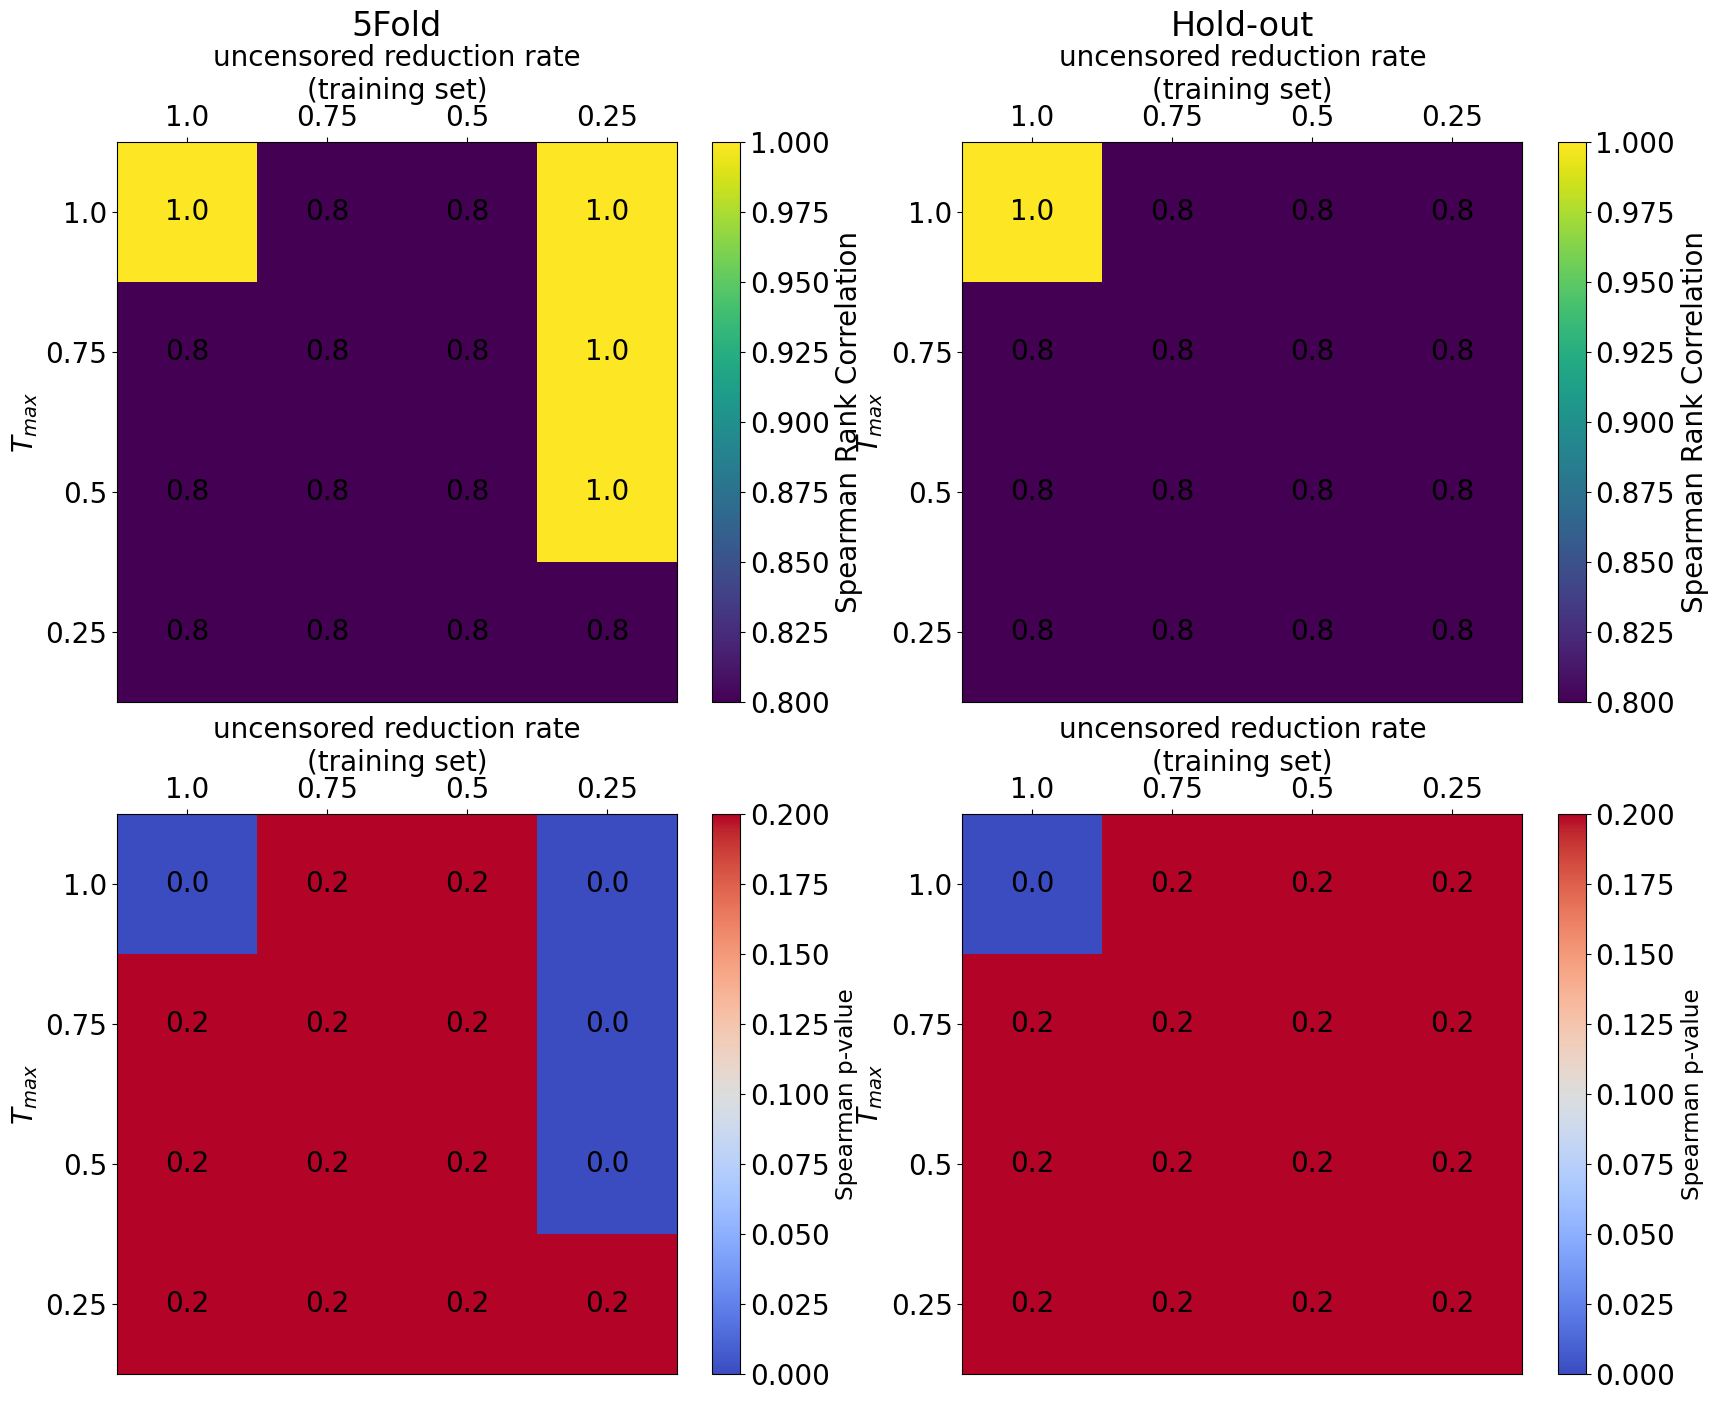

RandomSurvivalForest


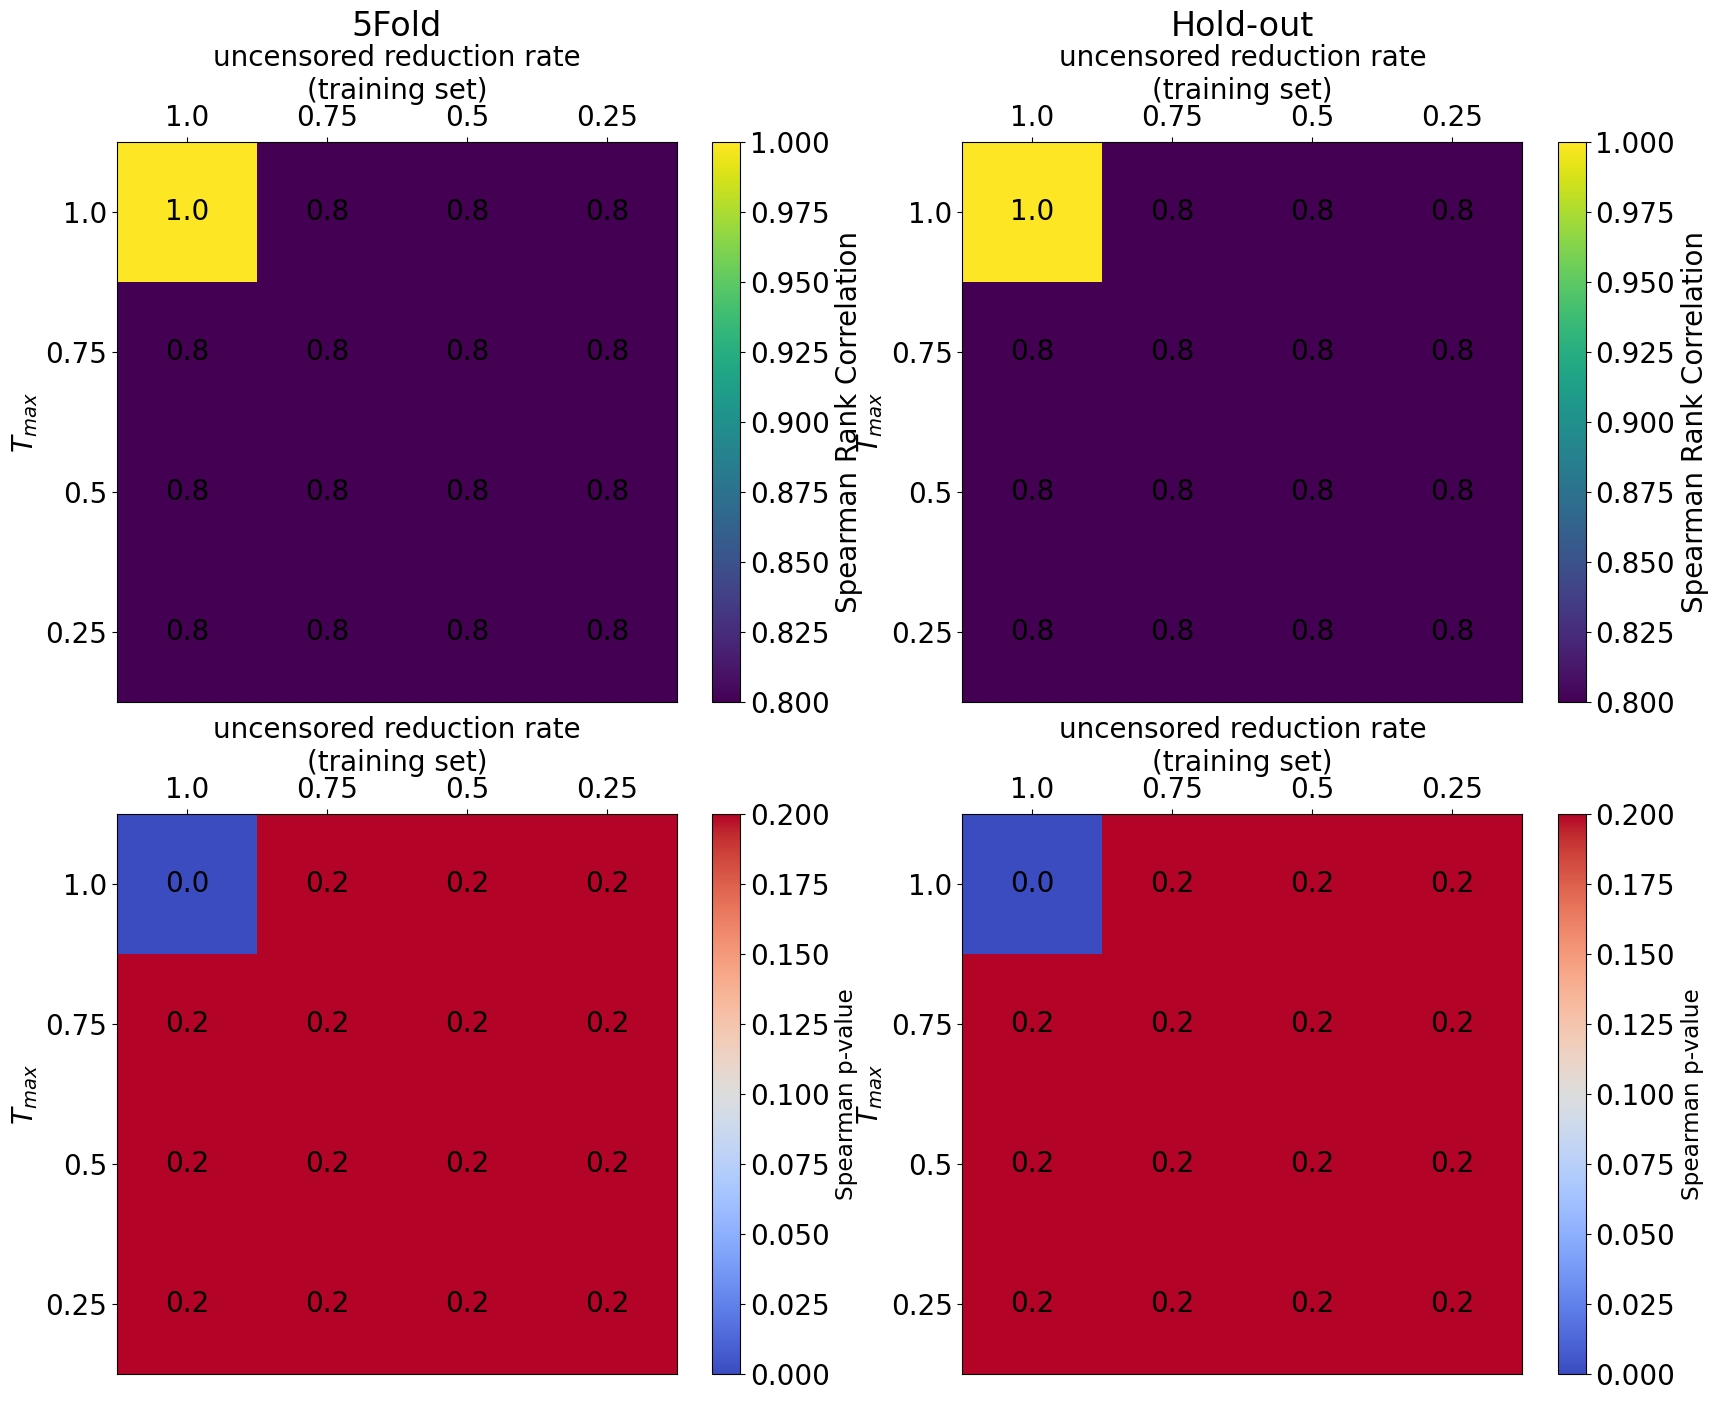

GradientBoosting


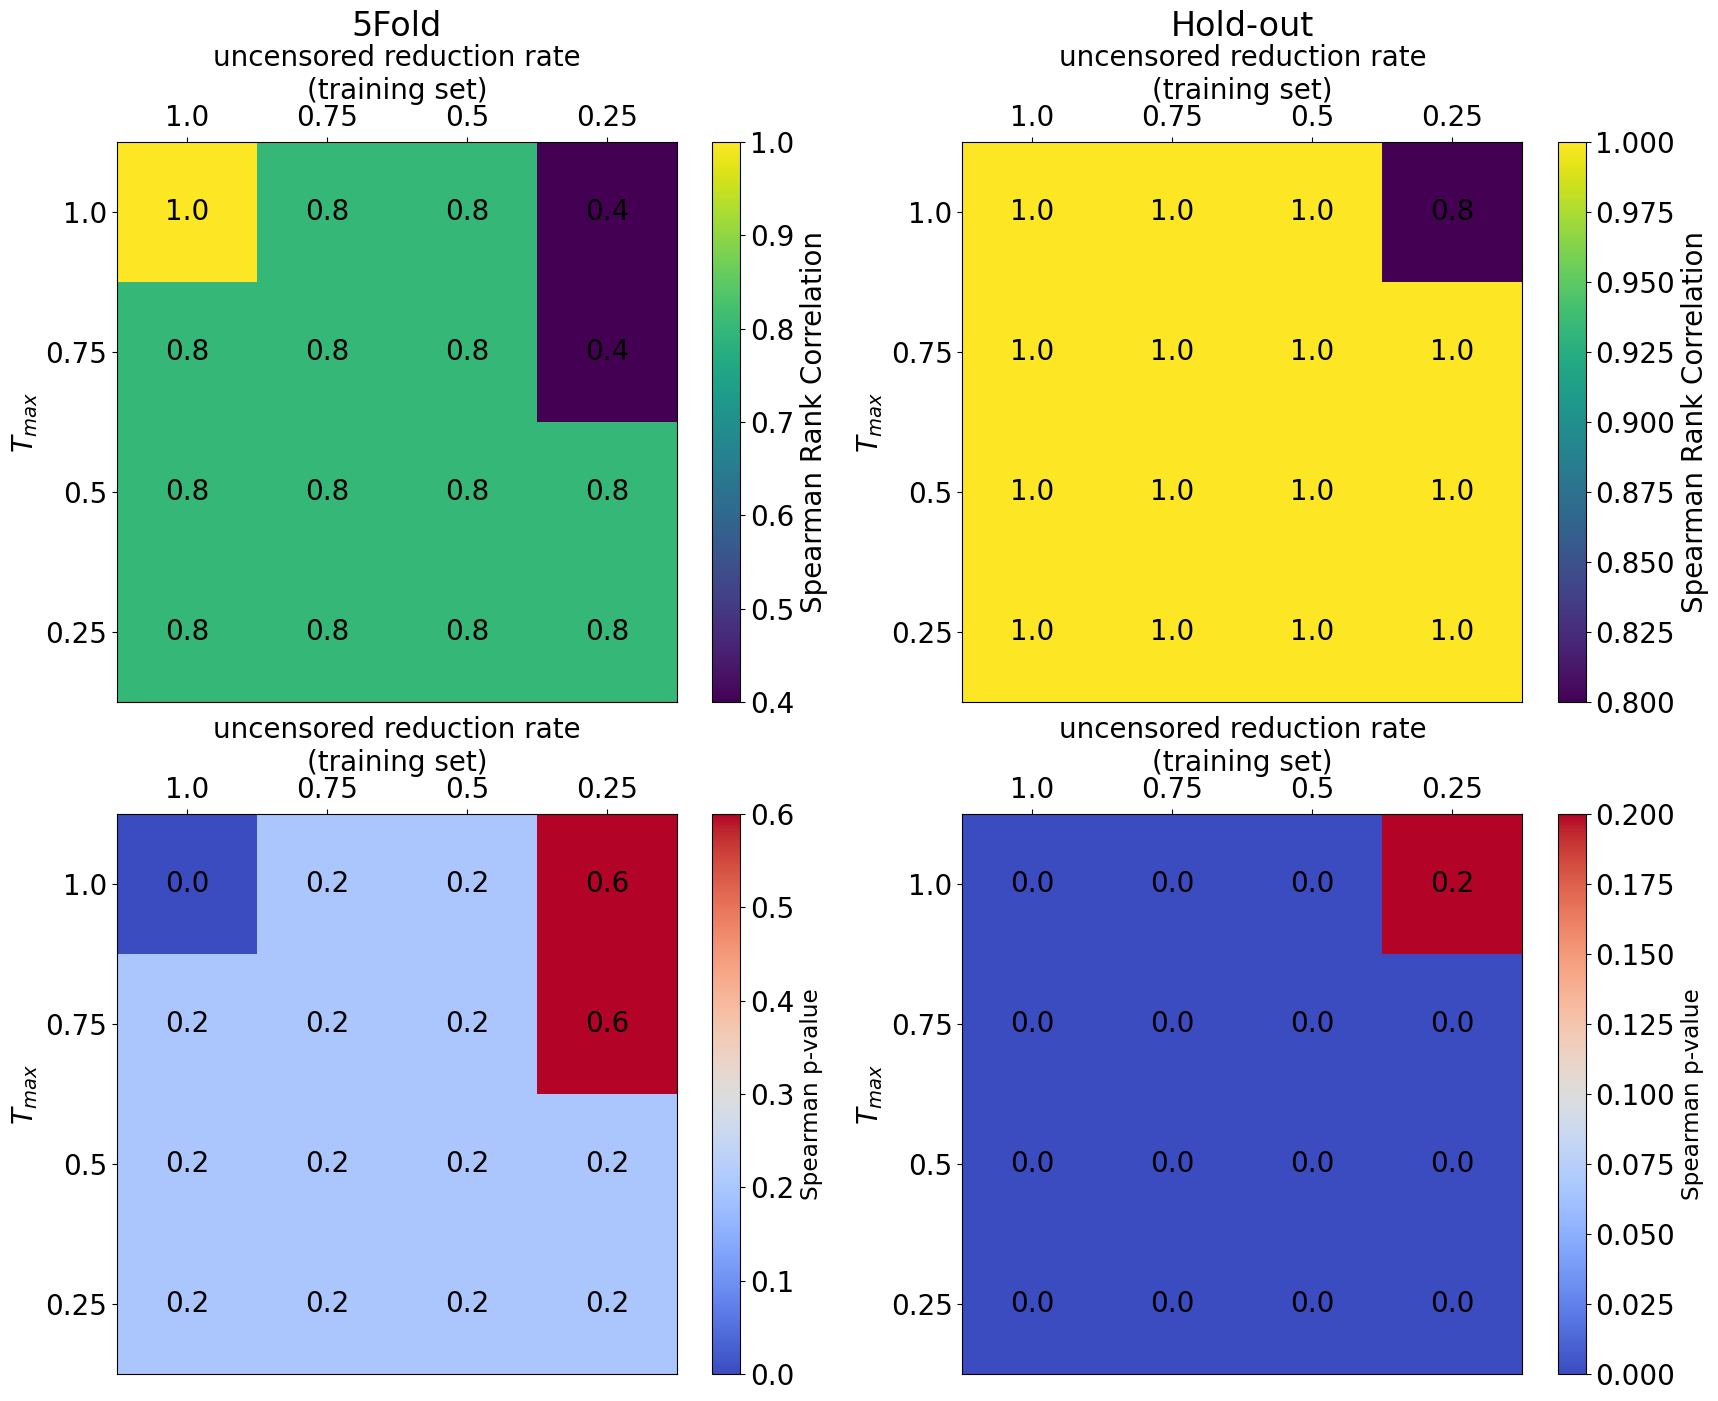

MDN


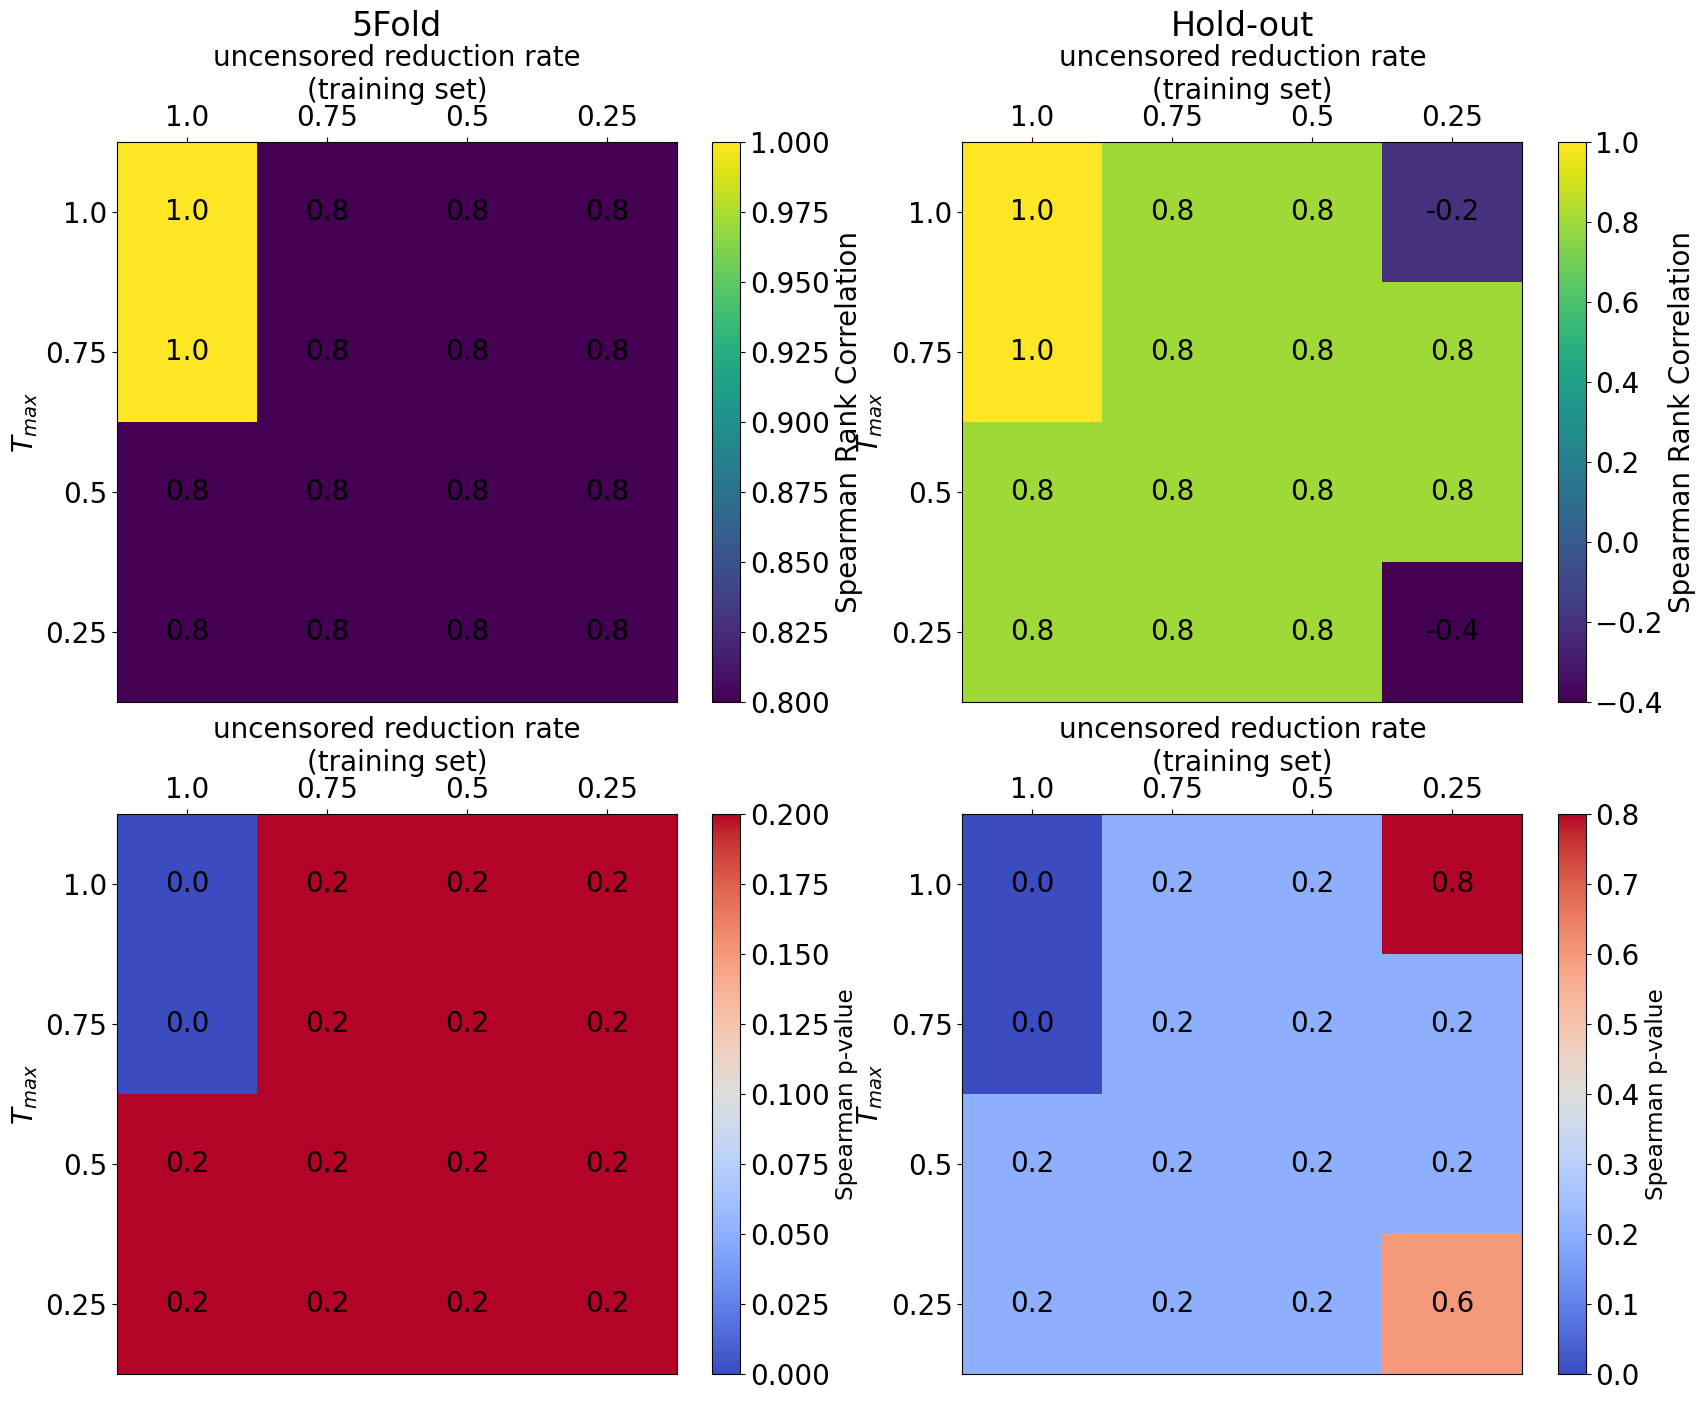

In [63]:
Models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
for model in Models:
    print(model)
    fig, axs = plt.subplots(2,2,figsize=(20,16))
    typs = ["5Fold","Hold-out"]
    locs = [[0,0],[0,1]]
    #ylims = [[0.28,0.85],[-0.7,2.1],[0.5,1.0],[1e-3,1]]

    for typ,loc in zip(typs,locs):
        for _,row in sensitivity_analysis_corr[(sensitivity_analysis_corr.Model == model) & (sensitivity_analysis_corr.Type == typ)].iterrows():
            # Correlation
            # Normalization
            norm = Normalize(vmin = np.array(row.corrs).min(), vmax = np.array(row.corrs).max())
            # Heatmap & Colorbar
            im = axs[loc[0]][loc[1]].imshow(np.array(row.corrs).reshape(4,4), norm = norm)
            cbar = axs[loc[0]][loc[1]].figure.colorbar(im)

            # Ticks & Tick labels
            axs[loc[0]][loc[1]].set_xticks(np.arange(np.array(row.corrs).reshape(4,4).shape[1]), labels=red_rates)
            axs[loc[0]][loc[1]].set_xlabel("uncensored reduction rate\n(training set)")
            axs[loc[0]][loc[1]].xaxis.set_ticks_position('top')
            #axs[loc[0]][loc[1]].tick_params(labelbottom=True, labeltop=True)
            axs[loc[0]][loc[1]].xaxis.set_label_position('top')
            axs[loc[0]][loc[1]].set_yticks(np.arange(np.array(row.corrs).reshape(4,4).shape[0]), labels=[1.0,0.75,0.5,0.25])
            axs[loc[0]][loc[1]].set_ylabel("$T_{max}$")

            # Colorbar labels
            cbar.set_label("Spearman Rank Correlation")

            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    corr = "{:.5}".format(np.array(row.corrs).reshape(4,4)[i,j])
                    scr_str = f"{corr}"
                    text = axs[loc[0]][loc[1]].text(j, i, scr_str,ha="center", va="center", size = "medium")

            # Title
            axs[loc[0]][loc[1]].set_title(typ)

            # p-value
            # Normalization
            norm = Normalize(vmin = np.array(row.pvals).min(), vmax = np.array(row.pvals).max())
            # Heatmap & Colorbar
            im = axs[loc[0]+1][loc[1]].imshow(np.array(row.pvals).reshape(4,4), norm = norm,  cmap = "coolwarm")
            cbar = axs[loc[0]+1][loc[1]].figure.colorbar(im, cmap = "coolwarm")

            # Ticks & Tick labels
            axs[loc[0]+1][loc[1]].set_xticks(np.arange(np.array(row.pvals).reshape(4,4).shape[1]), labels=[1.0,0.75,0.5,0.25])
            axs[loc[0]+1][loc[1]].set_xlabel("uncensored reduction rate\n(training set)")
            axs[loc[0]+1][loc[1]].xaxis.set_ticks_position('top')
            axs[loc[0]+1][loc[1]].xaxis.set_label_position('top')
            axs[loc[0]+1][loc[1]].set_yticks(np.arange(np.array(row.pvals).reshape(4,4).shape[0]), labels=[1.0,0.75,0.5,0.25])
            axs[loc[0]+1][loc[1]].set_ylabel("$T_{max}$")

            # Colorbar labels
            cbar.set_label("Spearman p-value", fontsize = "small")

            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    pval = "{:.5}".format(np.array(row.pvals).reshape(4,4)[i,j])
                    scr_str = f"{pval}"
                    text = axs[loc[0]+1][loc[1]].text(j, i, scr_str,ha="center", va="center", size = "medium")

    #fig.tight_layout()
    plt.show()

#### Visualizing the change in dataset quality

In [33]:
from utils import reduce_T_max,reduce_uncensored
from lifelines.fitters.coxph_fitter import CoxPHFitter

y_baseline = y_train.copy()

five_fold_mean = np.zeros((len(T_maxs),len(red_rates))).flatten()
five_fold_std = np.zeros((len(T_maxs),len(red_rates))).flatten()
hold_out_res = np.zeros((len(T_maxs),len(red_rates))).flatten()

i = 0
for T_max,red_rate in sensitivity_grid:
    y_red = np.copy(y_baseline)
    y_red = reduce_T_max(y_red,T_max)

    # 5Fold
    kf = KFold(n_splits=5,random_state=42,shuffle=True)
    p_vals = []
    for train_index, test_index in kf.split(y_red):
        y_trn, y_tst = y_red[train_index], y_red[test_index]
        y_trn_baseline, y_tst_baseline = y_baseline[train_index], y_baseline[test_index]
        y_trn = reduce_uncensored(y_trn, red_rate)

        cox_test_df = pd.DataFrame(np.append(np.vstack([y_trn,y_trn_baseline]),np.hstack([np.zeros(len(y_trn)).T,np.ones(len(y_trn_baseline))]).reshape(-1,1),axis=1))

        cph = CoxPHFitter()
        cph.fit(df = cox_test_df,
                duration_col = 0,
                event_col = 1)
        pval = cph.log_likelihood_ratio_test().p_value
        if pval == 0.0:
            pval = 1e-300 #Replacing 0 with a very small float, so we can plot it on a logarithmic scale
        p_vals.append(pval)

    # Hold-out
    y_red = reduce_uncensored(y_red, red_rate)

    cox_test_df = pd.DataFrame(np.append(np.vstack([y_red,y_baseline]),np.hstack([np.zeros(len(y_red)).T,np.ones(len(y_baseline))]).reshape(-1,1),axis=1))

    cph = CoxPHFitter()
    cph.fit(df = cox_test_df,
            duration_col = 0,
            event_col = 1)

    p_val = cph.log_likelihood_ratio_test().p_value
    if p_val == 0.0:
        p_val = 1e-300 #Replacing 0 with a very small float, so we can plot it on a logarithmic scale

    # Adding results to the matrices
    hold_out_res[i] = p_val
    five_fold_mean[i] = np.mean(np.array(p_vals))
    five_fold_std[i] = 1.96*np.std(np.array(p_vals))/np.sqrt(5)

    i += 1

hold_out_res = hold_out_res.reshape((4,4))
five_fold_mean = five_fold_mean.reshape((4,4))
five_fold_std = five_fold_std.reshape((4,4))

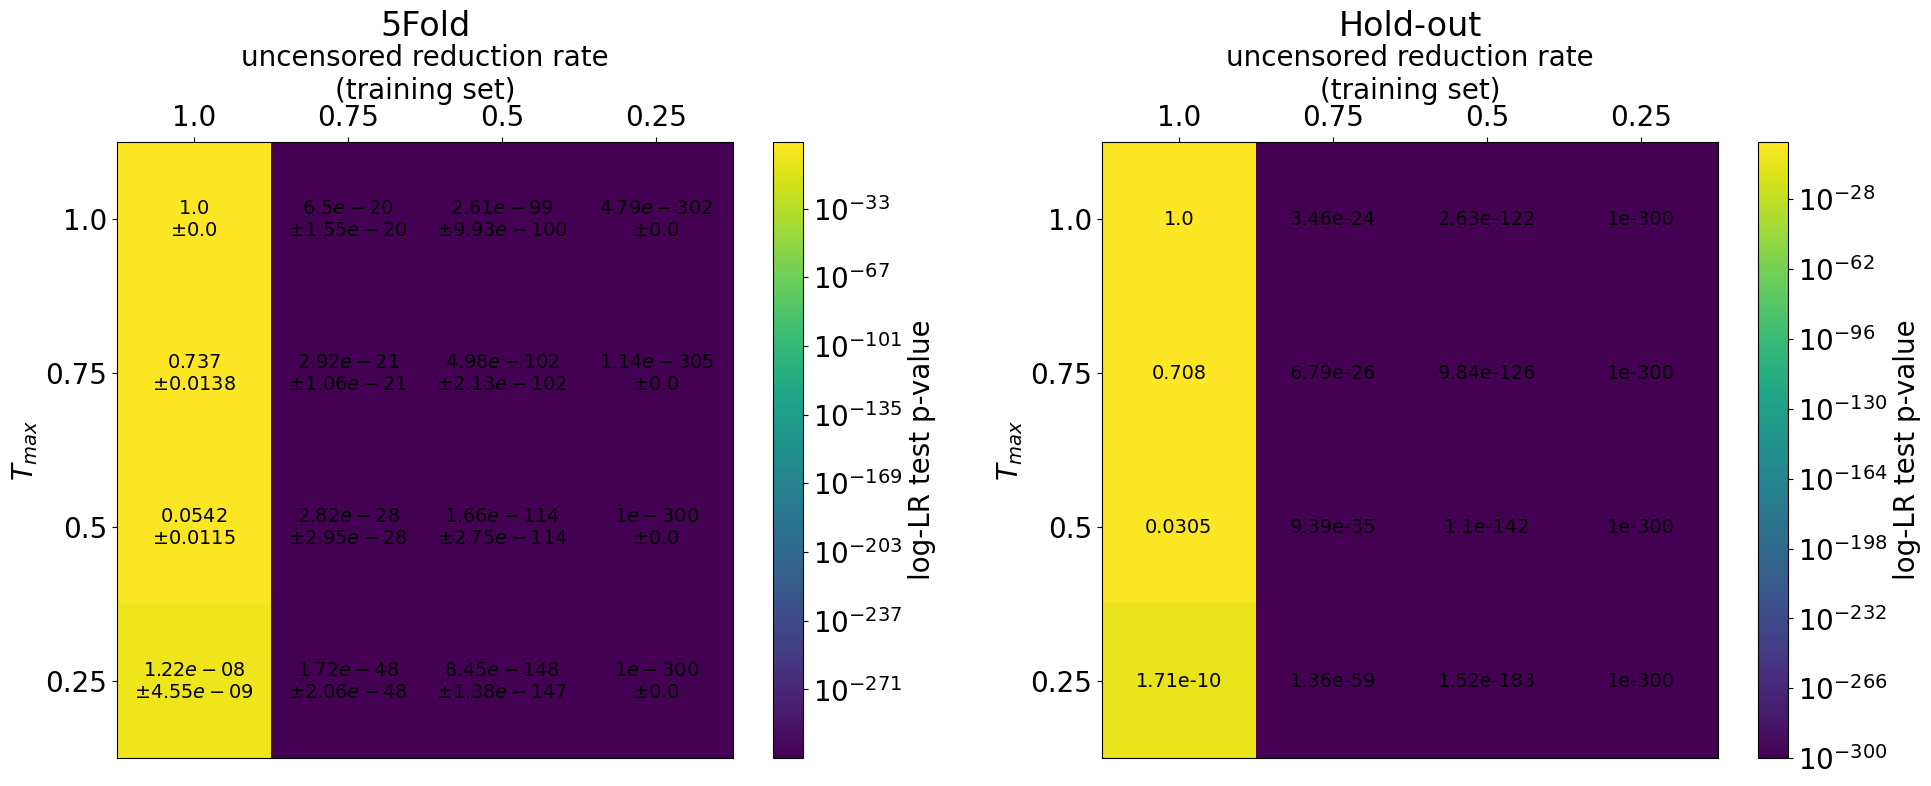

In [34]:
fig, axs = plt.subplots(1,2,figsize=(20,8))
typs = ["5Fold","Hold-out"]
locs = [[0,0],[0,1]]
datas = [five_fold_mean,hold_out_res]

for typ,loc,data in zip(typs,locs,datas):
    # Normalization
    norm = LogNorm(vmin = data.min(), vmax = data.max())

    # Heatmap & Colorbar
    im = axs[loc[1]].imshow(data, norm = norm)
    cbar = axs[loc[1]].figure.colorbar(im)

    # Ticks & Tick labels
    axs[loc[1]].set_xticks(np.arange(data.shape[1]), labels=[1.0,0.75,0.5,0.25])
    axs[loc[1]].set_xlabel("uncensored reduction rate\n(training set)")
    axs[loc[1]].xaxis.set_ticks_position('top')
    #axs[loc[0]][loc[1]].tick_params(labelbottom=True, labeltop=True)
    axs[loc[1]].xaxis.set_label_position('top')
    axs[loc[1]].set_yticks(np.arange(data.shape[0]), labels=[1.0,0.75,0.5,0.25])
    axs[loc[1]].set_ylabel("$T_{max}$")

    # Colorbar labels
    cbar.set_label("log-LR test p-value")

    # Scores as text
    for i in range(len(red_rates)):
        for j in range(len(T_maxs)):
            mean = "{:.3}".format(data[i,j])
            std = "{:.3}".format(five_fold_std[i,j])
            if typ == "5Fold":
                scr_str = f"${mean}$\n$\pm {std}$"
            else:
                scr_str = f"{mean}"
            text = axs[loc[1]].text(j, i, scr_str,ha="center", va="center", size = "x-small")

    # Title
    axs[loc[1]].set_title(typ)

fig.tight_layout()
plt.show()

In [90]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

for _,row in sensitivity_analysis_corr.iterrows():
    print(f"{row.Model}, {row.Type}")
    y_pred = MinMaxScaler().fit_transform(np.array(row.corrs).reshape(-1, 1))
    if row.Type == "5Fold":
        y_true = five_fold_mean.flatten()
        y_true_low = five_fold_mean.flatten() - five_fold_std.flatten()
        y_true_high = five_fold_mean.flatten() + five_fold_std.flatten()
        score = mean_squared_error(y_true, y_pred, squared=False)
        score_low = mean_squared_error(y_true_low, y_pred, squared=False)
        score_high = mean_squared_error(y_true_high, y_pred, squared=False)
        print(f"{score} +/- {score_low-score_high}")
    else:
        y_true = hold_out_res.flatten()
        score = mean_squared_error(y_true, y_pred, squared=False)
        print(score)

CoxPH, 5Fold
0.5975679693161707 +/- 0.0012661674817733282
CoxPH, Hold-out
0.30636890635610375
SurvivalTree, 5Fold
0.4708209319391718 +/- -0.0028761560220646465
SurvivalTree, Hold-out
0.17709293261402353
RandomSurvivalForest, 5Fold
0.18485764780519695 +/- -0.007324960540650738
RandomSurvivalForest, Hold-out
0.17709293261402353
GradientBoosting, 5Fold
0.5738551212413062 +/- 0.0013184850500451706
GradientBoosting, Hold-out
0.9022650404286211
MDN, 5Fold
0.06702682886364202 +/- 0.005610388254347093
MDN, Hold-out
0.744595991232993


## Degradation

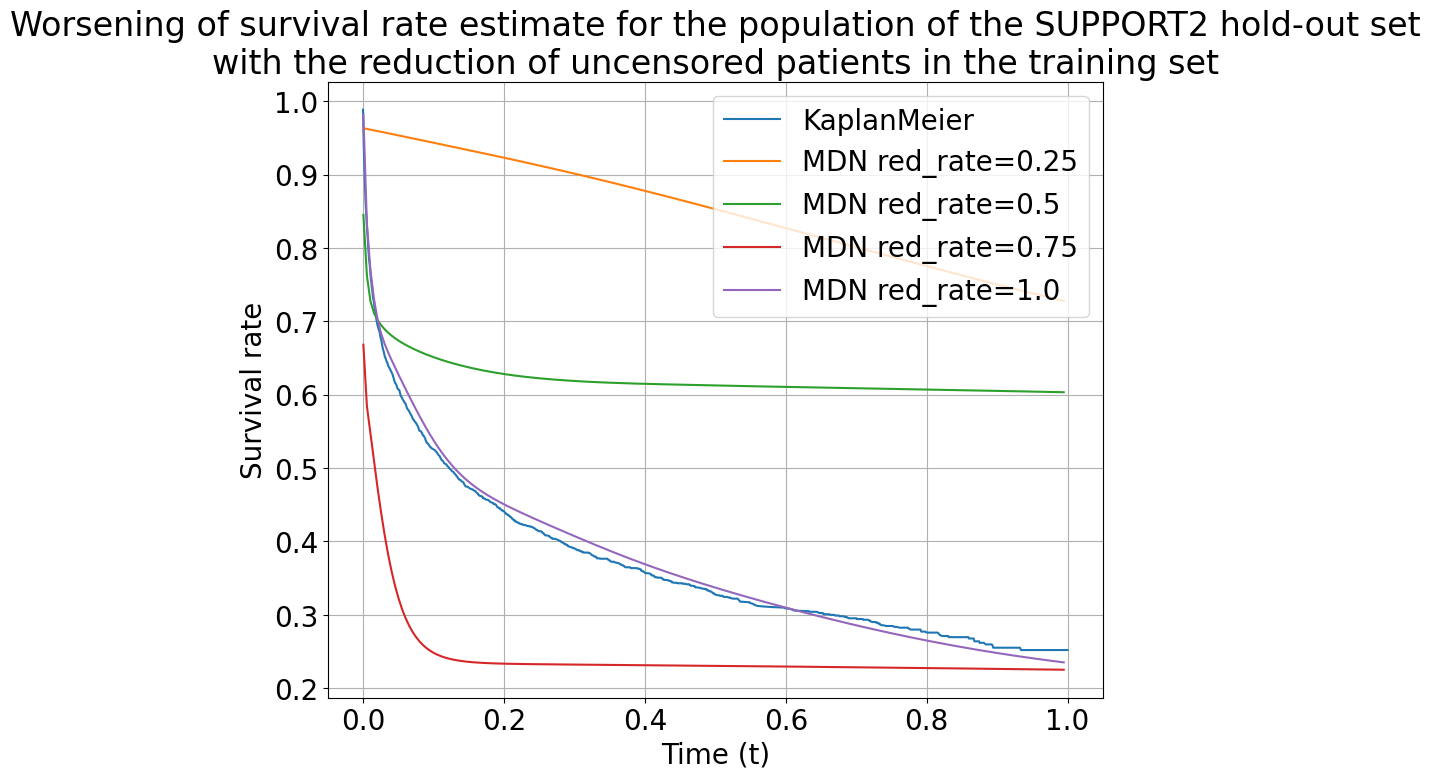

In [29]:
models = ["MDN"]
opts = [True]
red_rates = [0.25,0.5,0.75,1.0]
trials = list(product(models,opts,red_rates))

compare_survival  = {"Model":[],
                     "Timeline":[],
                     "Survival_Function":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == trial[2]):
            compare_survival["Model"].append(f"{trial[0]} red_rate={trial[2]}")
            compare_survival["Timeline"].append(results_table["Timeline"][i])
            compare_survival["Survival_Function"].append(results_table["Overall_Survival_Function"][i])
            

plt.figure(figsize=(10,8))
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]
km_timeline, km_prob_survival = kaplan_meier_estimator(y_test[:,1].astype(bool),y_test[:,0])
plt.plot(km_timeline,km_prob_survival, label = "KaplanMeier")

for i in range(len(compare_survival["Model"])):
    plt.plot(compare_survival["Timeline"][i], compare_survival["Survival_Function"][i], label = compare_survival["Model"][i])
plt.legend()
plt.grid()
plt.title(f"Worsening of survival rate estimate for the population of the {NAME_PLOT} hold-out set\nwith the reduction of uncensored patients in the training set")
plt.xlabel("Time (t)")
plt.ylabel("Survival rate")
#plt.xscale("log")
#plt.yscale("log")
plt.show()

## All results

In [30]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True,False]
T_maxs = [1.0,0.75,0.5,0.25]
red_rates = [1.0,0.75,0.5,0.25]
trials = list(product(models,opts,T_maxs,red_rates))

master_results  = {"Model":[],
                   "T_max":[],
                   "Uncensored Reduction":[],
                   "5Fold - c-index":[],
                   "5Fold - iBrier":[],
                   "5Fold - AUROC":[],
                   "5Fold - LogRank":[],
                   "Hold-out - c-index":[],
                   "Hold-out - iBrier":[],
                   "Hold-out - AUROC":[],
                   "Hold-out - LogRank":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == trial[2]) & (results_table["Uncensored_Reduction"][i] == trial[3]):
            master_results["Model"].append(f"{trial[0]} " + ["$_{LogRank}$" if trial[1] == True else ""][0])
            master_results["T_max"].append(results_table["T_max"][i])
            master_results["Uncensored Reduction"].append(results_table["Uncensored_Reduction"][i])
            master_results["5Fold - c-index"].append( str(round(results_table["5Fold"]["UnoC"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["UnoC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["5Fold - iBrier"].append( str(round(results_table["5Fold"]["iBrier"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["iBrier"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["5Fold - AUROC"].append( str(round(results_table["5Fold"]["AUROC"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["AUROC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["5Fold - LogRank"].append( str(round(results_table["5Fold"]["LogRank"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["LogRank"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["Hold-out - c-index"].append( str(round(results_table["Hold-out"]["UnoC"][i],4)).ljust(6,"0") )
            master_results["Hold-out - iBrier"].append( str(round(results_table["Hold-out"]["iBrier"][i],4)).ljust(6,"0") )
            master_results["Hold-out - AUROC"].append( str(round(results_table["Hold-out"]["AUROC"][i],4)).ljust(6,"0") )
            master_results["Hold-out - LogRank"].append( str(round(results_table["Hold-out"]["LogRank"][i],4)).ljust(6,"0") )

master_results = pd.DataFrame.from_dict(master_results)

In [31]:
master_results

Model  T_max  Uncensored Reduction  5Fold - c-index  \
0    CoxPH $_{LogRank}$   1.00                  1.00  0.8260 ± 0.0069   
1    CoxPH $_{LogRank}$   1.00                  0.75  0.7778 ± 0.0108   
2    CoxPH $_{LogRank}$   1.00                  0.50  0.7213 ± 0.0131   
3    CoxPH $_{LogRank}$   1.00                  0.25  0.6822 ± 0.0150   
4    CoxPH $_{LogRank}$   0.75                  1.00  0.8292 ± 0.0066   
..                  ...    ...                   ...              ...   
155                MDN    0.50                  0.25  0.6780 ± 0.0349   
156                MDN    0.25                  1.00  0.8791 ± 0.0037   
157                MDN    0.25                  0.75  0.8388 ± 0.0131   
158                MDN    0.25                  0.50  0.8068 ± 0.0162   
159                MDN    0.25                  0.25  0.7294 ± 0.0155   

      5Fold - iBrier    5Fold - AUROC  5Fold - LogRank Hold-out - c-index  \
0    0.1409 ± 0.0088  0.8611 ± 0.0099  0.1447 ± 0.0415             0.8269   
1    0.2287 ± 0.0144  0.8676 ± 0.0093  0.0000 ± 0.0000             0.7748   
2    0.4200 ± 0.0233  0.8712 ± 0.0086  0.0000 ± 0.0000             0.7164   
3    0.6905 ± 0.0250  0.8783 ± 0.0088  0.0000 ± 0.0000             0.6808   
4    0.1417 ± 0.0092  0.8619 ± 0.0102  0.0192 ± 0.0102             0.8325   
..               ...              ...              ...                ...   
155  0.5880 ± 0.0568  0.7144 ± 0.0650  0.0000 ± 0.0000             0.7151   
156  0.1221 ± 0.0048  0.9003 ± 0.0082  0.0006 ± 0.0010             0.8779   
157  0.1812 ± 0.0106  0.8677 ± 0.0159  0.0029 ± 0.0031             0.8439   
158  0.2894 ± 0.0242  0.8432 ± 0.0200  0.0008 ± 0.0015             0.7728   
159  0.5122 ± 0.0738  0.7716 ± 0.0151  0.0000 ± 0.0000             0.7633   

    Hold-out - iBrier Hold-out - AUROC Hold-out - LogRank  
0              0.1423           0.8599             0.0495  
1              0.2306           0.8646             0.0000  
2              0.4181           0.8700             0.0000  
3              0.6749           0.8800             0.0000  
4              0.1429           0.8613             0.0008  
..                ...              ...                ...  
155            0.6313           0.7744             0.0000  
156            0.1222           0.9018             0.0000  
157            0.1866           0.8676             0.0000  
158            0.3074           0.7994             0.1022  
159            0.5586           0.8115             0.0000  

[160 rows x 11 columns]

In [32]:
# CSV version for the Paper
master_results.to_csv(f"Logs/{NAME}_results.csv",index=False)